# 草，预处理出问题了

标准栅格发现有空洞，于是在修补的过程中，一边跑代码，一边在写考虑后面建模的代码

In [5]:
import xarray as xr
import matplotlib.pyplot as plt

# 读取数据
ds = xr.open_dataset(r'D:\xarray\abandon_2\chunk_4_49.nc')
ds_2 = xr.open_dataset(r'D:\xarray\abandonment_chunkall\chunk_4_49.nc')


ds_2



<xarray.Dataset> Size: 35MB
Dimensions:               (lat: 500, lon: 500, time: 31)
Coordinates:
  * lat                   (lat) float64 4kB 73.33 73.32 73.31 ... 69.18 69.17
  * lon                   (lon) float64 4kB 24.17 24.18 24.19 ... 28.32 28.33
  * time                  (time) datetime64[ns] 248B 1992-01-01 ... 2022-01-01
Data variables:
    abandonment_year      (lat, lon) float32 1MB ...
    abandonment_duration  (lat, lon) float32 1MB ...
    recultivation         (lat, lon) float32 1MB ...
    current_abandonment   (lat, lon) float32 1MB ...
    landcover             (time, lat, lon) float32 31MB ...

In [ ]:
import os
import gc
import numpy as np
import xarray as xr
import rioxarray

# —— 1. 路径设置 ——
tif_path = r'D:\Photovoltaic_data\Global_rast_gdpTot_1990_2020_30arcsec.tif'
nc_path  = r'D:\xarray\aligned2\firstmask.nc'

os.makedirs(os.path.dirname(nc_path), exist_ok=True)

# —— 2. 读取 GeoTIFF 为 DataArray ——
da = rioxarray.open_rasterio(tif_path, masked=True)
# 取第一个波段而不是squeeze
if 'band' in da.dims:
    da = da.isel(band=0)

# 重命名坐标一致为 lat/lon
if 'x' in da.dims and 'y' in da.dims:
    da = da.rename({'x': 'lon', 'y': 'lat'})


# —— 3. 构建陆域掩膜 ——
land_mask = da.notnull().astype(bool)
land_mask.name = 'land_mask'
land_mask.attrs['description'] = 'True where population density is valid'

# —— 4. 打包为 Dataset ——
ds = xr.Dataset(
    {
        'land_mask':   land_mask
    },
    coords={'lat': da['lat'], 'lon': da['lon']},
    attrs={'title': 'Population Density with simple land mask'}
)

# —— 5. 优化编码并保存 ——
encoding = {
    'land_mask': {
        'dtype': 'bool', 'zlib': True, 'complevel': 5
    }
}
ds.to_netcdf(nc_path, encoding=encoding)

# —— 6. 清理内存 ——
del ds, da, land_mask
gc.collect()

print(f"✅ 已保存简单 NetCDF：{nc_path}")


In [7]:
import xarray as xr
from pathlib import Path
import numpy as np

MASTER = r"D:\xarray\aligned2\firstmask.nc"
FINAL  = r"D:\xarray\final_mask_1km_new.nc"
OUT    = r"D:\xarray\aligned2\master_final.nc"

# 1) 读取
master = xr.open_dataset(MASTER).land_mask          # (lat, lon)
final  = xr.open_dataset(FINAL).final_mask          # (lat, lon 或 y,x)

# 2) 若 final 用 y/x → 改成 lat/lon（不依赖 rioxarray）
if {"x","y"}.issubset(final.dims):
    final = final.rename({"x":"lon", "y":"lat"})

# 3) 对齐：最近邻插值到 final 网格
# 将布尔类型转换为数值类型，因为interp只能处理数值类型数组
master_numeric = master.astype("uint8")  # 将布尔值转换为0和1
aligned = master_numeric.interp(
    lon=final.lon, lat=final.lat, method="nearest"
).astype("uint8")

# 4) 保留 0/1，写 NetCDF
aligned.to_dataset(name="land_mask").to_netcdf(
    OUT, encoding={"land_mask":{"zlib":True,"complevel":4}}
)

print("✓ 新 land_mask 已输出:", OUT)


c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\duck_array_ops.py:215: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


✓ 新 land_mask 已输出: D:\xarray\aligned2\master_final.nc


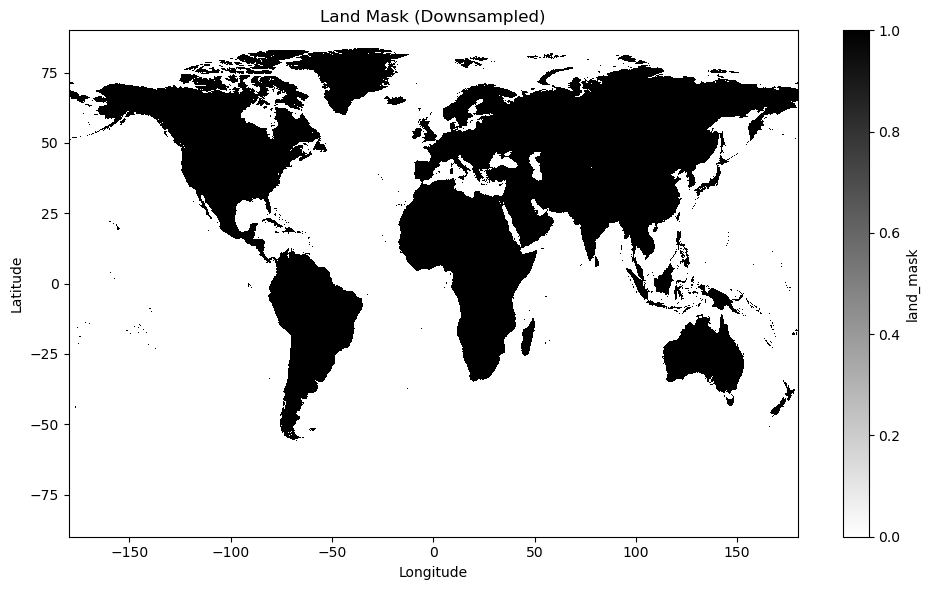

Dataset shape: (21600, 43200)
Data type: uint8


In [8]:
newmaster_path = OUT

newmaster = xr.open_dataset(newmaster_path)

import matplotlib.pyplot as plt

# The dataset is too large to plot directly, so we'll downsample it
# Downsample the data to avoid memory error
n = 10  # Adjust this value based on your memory constraints
downsampled = newmaster.land_mask.isel(lat=slice(None, None, n), lon=slice(None, None, n))

# Create a simple figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the downsampled data with simple colors
downsampled.plot(ax=ax, cmap='binary', add_colorbar=True)

# Add basic title and labels
plt.title('Land Mask (Downsampled)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

# Display basic information about the dataset
print(f"Dataset shape: {newmaster.land_mask.shape}")
print(f"Data type: {newmaster.land_mask.dtype}")


# 气候数据

## RSDS数据

In [ ]:
# batch_align_rsds.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm
import os
import re
import warnings
import psutil
warnings.filterwarnings('ignore')

def print_memory_usage():
    """打印当前内存使用情况"""
    process = psutil.Process()
    print(f"Memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")

def process_chunk(da, lon, lat_chunk, mask_chunk):
    """处理单个数据块"""
    try:
        # 对当前块进行插值
        da_chunk = da.interp(lon=lon, lat=lat_chunk, method="linear")
        # 应用掩膜
        da_chunk_masked = da_chunk.where(mask_chunk)
        return da_chunk_masked
    except Exception as e:
        print(f"Error processing chunk: {str(e)}")
        return None

def process_file(fp, master_data, chunk_size=20):
    """处理单个文件"""
    lat, lon, mask, chunk_lat, chunk_lon = master_data
    out_nc = OUT_DIR / f"{fp.stem}.nc"
    
    if out_nc.exists():
        return f"Skipping existing file: {out_nc}"

    try:
        print(f"\nProcessing {fp.name}")
        print_memory_usage()

        # 使用更小的chunk size读取数据
        da = (
            rxr.open_rasterio(fp, masked=True,
                            chunks={"x": chunk_lon // 4, "y": chunk_lat // 4})
            .squeeze("band", drop=True)
            .rio.set_spatial_dims("x", "y", inplace=False)
            .rename({"x": "lon", "y": "lat"})
        )

        # 将纬度分成多个块进行处理
        lat_chunks = np.array_split(lat.values, chunk_size)
        da_parts = []
        
        for i, lat_chunk in enumerate(tqdm(lat_chunks, desc="Processing chunks")):
            # 获取对应的掩膜块
            mask_chunk = mask.sel(lat=lat_chunk)
            
            # 处理当前块
            da_chunk_masked = process_chunk(da, lon, lat_chunk, mask_chunk)
            if da_chunk_masked is not None:
                da_parts.append(da_chunk_masked)
            
            # 清理当前块的临时变量
            da_chunk_masked = None
            mask_chunk = None
            gc.collect()
            
            # 每处理4个块打印一次内存使用情况
            if (i + 1) % 4 == 0:
                print_memory_usage()

        # 合并所有处理后的块
        da_masked = xr.concat(da_parts, dim="lat")
        
        # 清理临时变量
        da_parts = None
        gc.collect()

        # 创建数据集并设置chunk
        var = da_masked.name or "rsds"
        ds = da_masked.to_dataset(name=var) \
                    .chunk({"lat": chunk_lat // 4, "lon": chunk_lon // 4})

        # 使用保守的压缩设置
        encoding = {
            var: {
                "zlib": True,
                "complevel": 5,  # 使用最低压缩级别
                "chunksizes": (chunk_lat // 4, chunk_lon // 4)
            }
        }
        
        # 写入文件
        ds.to_netcdf(out_nc, encoding=encoding, engine='netcdf4')
        
        result = f"Successfully processed: {fp.name}"

    except Exception as e:
        result = f"Error processing {fp}: {str(e)}"
        if out_nc.exists():
            try:
                os.remove(out_nc)
            except:
                pass
    finally:
        # 清理所有变量
        for var in ['ds', 'da', 'da_masked']:
            if var in locals():
                locals()[var] = None
        gc.collect()
        print_memory_usage()
    
    return result

def main():
    # ───────── 配置 ─────────
    global OUT_DIR
    MASTER   = Path(r"D:\xarray\aligned2\master_final.nc")
    SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_rsds")
    OUT_DIR  = Path(r"D:\xarray\aligned2\rsds")
    OUT_DIR.mkdir(exist_ok=True, parents=True)

    print("Initial memory usage:")
    print_memory_usage()

    # 加载模板数据
    tmpl = xr.open_dataset(MASTER, chunks={})
    lat = tmpl["lat"]
    lon = tmpl["lon"]
    mask = tmpl["land_mask"]

    # 使用更小的chunk size
    chunk_lat = len(lat) // 100  # 进一步减小chunk大小
    chunk_lon = len(lon) // 200

    master_data = (lat, lon, mask, chunk_lat, chunk_lon)

    # 筛选目标文件
    all_files = list(SRC_DIR.glob("*.tif"))
    target_files = [fp for fp in all_files if re.search(r'(2015|2019|2018)', fp.stem)]

    # 处理文件
    for fp in tqdm(target_files, desc="Processing files"):
        try:
            result = process_file(fp, master_data)
            print(result)
        except Exception as e:
            print(f"Error processing {fp}: {str(e)}")
            continue

    # 清理
    tmpl.close()
    gc.collect()
    print("\nFinal memory usage:")
    print_memory_usage()

    print("✅ All done! Aligned files are in:", OUT_DIR)

if __name__ == "__main__":
    main()

In [ ]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
import rasterio
from rasterio.windows import Window
import psutil
import os
from tqdm.auto import tqdm
import logging
import warnings
warnings.filterwarnings('ignore')

# 设置日志
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_memory_usage():
    """获取当前内存使用情况"""
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / 1024 / 1024  # 转换为MB
    return f"{mem:.1f}MB"

def clean_memory():
    """强制进行内存清理"""
    gc.collect()
    if hasattr(xr, 'clear_cache'):
        xr.clear_cache()

def get_window_bounds(src, lat_values, lon_values):
    """计算数据窗口的边界"""
    # 获取源文件的变换矩阵
    transform = src.transform
    
    # 计算窗口的像素坐标
    col_start, row_start = ~transform * (lon_values[0], lat_values[-1])
    col_end, row_end = ~transform * (lon_values[-1], lat_values[0])
    
    # 确保坐标在有效范围内
    col_start = max(0, int(col_start))
    row_start = max(0, int(row_start))
    col_end = min(src.width, int(col_end) + 1)
    row_end = min(src.height, int(row_end) + 1)
    
    return Window(col_start, row_start, col_end - col_start, row_end - row_start)

def process_tif_to_netcdf(tif_path, master_path, out_dir, chunk_lat=250, chunk_lon=250, memory_threshold_mb=8000):
    """
    Process a TIF file to NetCDF format with chunking and masking
    
    Args:
        tif_path (Path): Path to input TIF file
        master_path (str): Path to master NetCDF file with template/mask
        out_dir (Path): Output directory for NetCDF file
        chunk_lat (int): Chunk size for latitude dimension
        chunk_lon (int): Chunk size for longitude dimension
        memory_threshold_mb (int): Memory threshold in MB to trigger garbage collection
    """
    logging.info(f"开始处理文件: {tif_path.name}")
    logging.info(f"初始内存使用: {get_memory_usage()}")
    
    out_nc = out_dir / f"{tif_path.stem}.nc"
    if out_nc.exists():
        logging.info(f"文件已存在，跳过: {out_nc.name}")
        return

    try:
        # 使用上下文管理器确保资源正确释放
        with xr.open_dataset(master_path) as tmpl:
            lat = tmpl["lat"].load()  # 显式加载到内存
            lon = tmpl["lon"].load()
            mask = tmpl["land_mask"].load()
            
            logging.info(f"模板加载后内存使用: {get_memory_usage()}")

        # 创建结果数组
        result_shape = (len(lat), len(lon))
        result = np.full(result_shape, np.nan, dtype=np.float32)
        
        # 处理数据块
        lat_chunks = np.array_split(np.arange(len(lat)), max(1, len(lat) // chunk_lat))
        lon_chunks = np.array_split(np.arange(len(lon)), max(1, len(lon) // chunk_lon))
        
        total_chunks = len(lat_chunks) * len(lon_chunks)
        with tqdm(total=total_chunks, desc="处理数据块") as pbar:
            # 打开源文件一次，重复使用
            with rasterio.open(tif_path) as src:
                for i, lat_indices in enumerate(lat_chunks):
                    lat_values = lat.values[lat_indices]
                    lat_start, lat_end = lat_indices[0], lat_indices[-1] + 1
                    
                    for j, lon_indices in enumerate(lon_chunks):
                        # 检查内存使用
                        current_memory = psutil.Process().memory_info().rss / 1024 / 1024
                        if current_memory > memory_threshold_mb:
                            logging.warning(f"内存使用超过阈值: {current_memory:.1f}MB")
                            clean_memory()
                            
                        lon_values = lon.values[lon_indices]
                        lon_start, lon_end = lon_indices[0], lon_indices[-1] + 1
                        
                        try:
                            # 计算当前块的窗口
                            window = get_window_bounds(src, lat_values, lon_values)
                            
                            # 直接读取数据块
                            data = src.read(1, window=window)
                            
                            # 创建临时数据集进行插值
                            temp_da = xr.DataArray(
                                data,
                                coords={
                                    'lat': np.linspace(lat_values[-1], lat_values[0], window.height),
                                    'lon': np.linspace(lon_values[0], lon_values[-1], window.width)
                                },
                                dims=['lat', 'lon']
                            )
                            
                            # 对当前块进行插值
                            chunk_result = temp_da.interp(
                                lon=lon_values,
                                lat=lat_values,
                                method="nearest"
                            )
                            
                            # 存储结果
                            result[lat_start:lat_end, lon_start:lon_end] = chunk_result.values
                            
                            # 清理临时变量
                            del temp_da, chunk_result, data
                            clean_memory()
                            
                        except Exception as e:
                            logging.error(f"处理数据块时出错 [{i},{j}]: {str(e)}")
                            continue
                        
                        pbar.update(1)
                        pbar.set_postfix({
                            "lat_chunk": f"{i+1}/{len(lat_chunks)}", 
                            "lon_chunk": f"{j+1}/{len(lon_chunks)}",
                            "memory": get_memory_usage()
                        })
        
        # 创建最终数据集
        logging.info("创建最终数据集...")
        da_result = xr.DataArray(
            result,
            coords={"lat": lat, "lon": lon},
            dims=["lat", "lon"],
            name="var"
        )
        
        # 应用掩膜
        da_masked = da_result.where(mask)
        
        # 创建输出数据集
        out_ds = da_masked.to_dataset()
        
        # 设置压缩和分块
        encoding = {
            "var": {
                "zlib": True,
                "complevel": 5,
                "chunksizes": (chunk_lat, chunk_lon),
                "_FillValue": np.nan
            }
        }
        
        # 保存为NetCDF
        logging.info(f"保存到 {out_nc}...")
        out_ds.to_netcdf(out_nc, encoding=encoding)
        out_ds.close()
        
        # 清理内存
        del da_result, da_masked, out_ds, result
        clean_memory()
        
    except Exception as e:
        logging.error(f"处理文件时出错 {tif_path.name}: {str(e)}")
        if out_nc.exists() and out_nc.is_file():
            out_nc.unlink()
    finally:
        clean_memory()
        logging.info(f"最终内存使用: {get_memory_usage()}")

# 配置
MASTER = r"D:\xarray\aligned2\master_final.nc"
SOC_DIR = Path(r"D:\xarray\aligned2\emission\SOC_source")
OUT_DIR = Path(r"D:\xarray\aligned2\emission")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# 处理所有TIF文件
tif_files = list(SOC_DIR.glob("*.tif"))
for tif_file in tqdm(tif_files, desc="处理文件"):
    logging.info(f"\n开始处理 {tif_file.name}...")
    process_tif_to_netcdf(tif_file, MASTER, OUT_DIR)
    
logging.info(f"✅ 所有文件处理完成: {OUT_DIR}")


In [ ]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
import rasterio
import psutil
import os
from tqdm.auto import tqdm
import logging
import warnings
warnings.filterwarnings('ignore')

# 设置日志
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_memory_usage():
    """获取当前内存使用情况"""
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / 1024 / 1024  # 转换为MB
    return f"{mem:.1f}MB"

def clean_memory():
    """强制进行内存清理"""
    gc.collect()
    if hasattr(xr, 'clear_cache'):
        xr.clear_cache()

def process_tif_to_netcdf(tif_path, master_path, out_dir, chunk_lat=250, chunk_lon=250, memory_threshold_mb=8000):
    """
    Process a TIF file to NetCDF format with chunking and masking
    
    Args:
        tif_path (Path): Path to input TIF file
        master_path (str): Path to master NetCDF file with template/mask
        out_dir (Path): Output directory for NetCDF file
        chunk_lat (int): Chunk size for latitude dimension
        chunk_lon (int): Chunk size for longitude dimension
        memory_threshold_mb (int): Memory threshold in MB to trigger garbage collection
    """
    logging.info(f"开始处理文件: {tif_path.name}")
    logging.info(f"初始内存使用: {get_memory_usage()}")
    
    out_nc = out_dir / f"{tif_path.stem}.nc"
    if out_nc.exists():
        logging.info(f"文件已存在，跳过: {out_nc.name}")
        return

    try:
        # 使用上下文管理器确保资源正确释放
        with xr.open_dataset(master_path) as tmpl:
            lat = tmpl["lat"].load()  # 显式加载到内存
            lon = tmpl["lon"].load()
            mask = tmpl["land_mask"].load()
            
            logging.info(f"模板加载后内存使用: {get_memory_usage()}")

        # 创建结果数组
        result_shape = (len(lat), len(lon))
        result = np.full(result_shape, np.nan, dtype=np.float32)
        
        # 处理数据块
        lat_chunks = np.array_split(np.arange(len(lat)), max(1, len(lat) // chunk_lat))
        lon_chunks = np.array_split(np.arange(len(lon)), max(1, len(lon) // chunk_lon))
        
        total_chunks = len(lat_chunks) * len(lon_chunks)
        with tqdm(total=total_chunks, desc="处理数据块") as pbar:
            for i, lat_indices in enumerate(lat_chunks):
                lat_values = lat.values[lat_indices]
                lat_start, lat_end = lat_indices[0], lat_indices[-1] + 1
                
                for j, lon_indices in enumerate(lon_chunks):
                    # 检查内存使用
                    current_memory = psutil.Process().memory_info().rss / 1024 / 1024
                    if current_memory > memory_threshold_mb:
                        logging.warning(f"内存使用超过阈值: {current_memory:.1f}MB")
                        clean_memory()
                        
                    lon_values = lon.values[lon_indices]
                    lon_start, lon_end = lon_indices[0], lon_indices[-1] + 1
                    
                    try:
                        # 使用rioxarray读取数据
                        with rasterio.open(tif_path) as src:
                            window = None  # 可以根据需要设置读取窗口
                            da = (
                                rxr.open_rasterio(tif_path, masked=True, window=window)
                                .isel(band=0)
                                .rio.set_spatial_dims("x", "y", inplace=False)
                                .rename({"x": "lon", "y": "lat"})
                            )
                            
                            # 对当前块进行插值
                            chunk_result = da.interp(
                                lon=lon_values,
                                lat=lat_values,
                                method="nearest"
                            ).compute()
                            
                            # 存储结果
                            result[lat_start:lat_end, lon_start:lon_end] = chunk_result.values
                            
                            # 清理临时变量
                            del da, chunk_result
                            clean_memory()
                            
                    except Exception as e:
                        logging.error(f"处理数据块时出错 [{i},{j}]: {str(e)}")
                        continue
                    
                    pbar.update(1)
                    pbar.set_postfix({
                        "lat_chunk": f"{i+1}/{len(lat_chunks)}", 
                        "lon_chunk": f"{j+1}/{len(lon_chunks)}",
                        "memory": get_memory_usage()
                    })
        
        # 创建最终数据集
        logging.info("创建最终数据集...")
        da_result = xr.DataArray(
            result,
            coords={"lat": lat, "lon": lon},
            dims=["lat", "lon"],
            name="var"
        )
        
        # 应用掩膜
        da_masked = da_result.where(mask)
        
        # 创建输出数据集
        out_ds = da_masked.to_dataset()
        
        # 设置压缩和分块
        encoding = {
            "var": {
                "zlib": True,
                "complevel": 5,
                "chunksizes": (chunk_lat, chunk_lon),
                "_FillValue": np.nan
            }
        }
        
        # 保存为NetCDF
        logging.info(f"保存到 {out_nc}...")
        out_ds.to_netcdf(out_nc, encoding=encoding)
        out_ds.close()
        
        # 清理内存
        del da_result, da_masked, out_ds, result
        clean_memory()
        
    except Exception as e:
        logging.error(f"处理文件时出错 {tif_path.name}: {str(e)}")
        if out_nc.exists() and out_nc.is_file():
            out_nc.unlink()
    finally:
        clean_memory()
        logging.info(f"最终内存使用: {get_memory_usage()}")

# 配置
MASTER = r"D:\xarray\aligned2\master_final.nc"
SOC_DIR = Path(r"D:\xarray\aligned2\emission\SOC_source")
OUT_DIR = Path(r"D:\xarray\aligned2\emission")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# 处理所有TIF文件
tif_files = list(SOC_DIR.glob("*.tif"))
for tif_file in tqdm(tif_files, desc="处理文件"):
    logging.info(f"\n开始处理 {tif_file.name}...")
    process_tif_to_netcdf(tif_file, MASTER, OUT_DIR)
    
logging.info(f"✅ 所有文件处理完成: {OUT_DIR}")


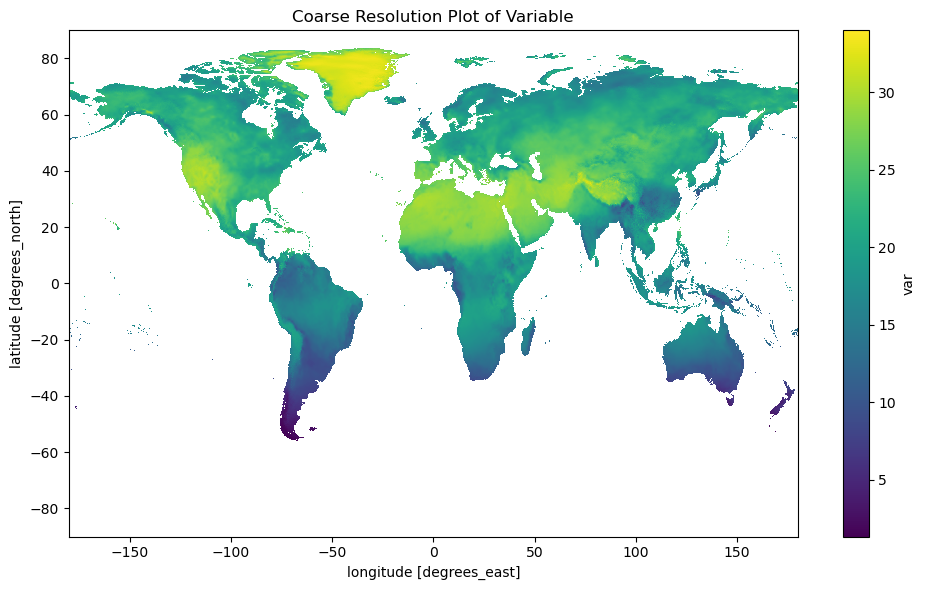

<xarray.Dataset> Size: 4GB
Dimensions:      (lon: 43200, lat: 21600)
Coordinates:
    spatial_ref  int32 4B ...
  * lon          (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat          (lat) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    band         int32 4B ...
    time         datetime64[ns] 8B ...
Data variables:
    var          (lat, lon) float32 4GB nan nan nan nan nan ... nan nan nan nan

In [2]:
import xarray as xr 

ds_path=r'D:\xarray\aligned2\rsds\CHELSA_rsds_2015_06_V.2.1.nc'
ds=xr.open_dataset(ds_path)
import matplotlib.pyplot as plt

# Plot the variable with coarse resolution for better performance
plt.figure(figsize=(10, 6))
ds['var'].coarsen(lat=20, lon=20).mean().plot()
plt.title('Coarse Resolution Plot of Variable')
plt.tight_layout()
plt.show()





In [6]:
MASTER = r"D:\xarray\aligned2\master_final.nc"
ds = xr.open_dataset(ds_path)
FINAL = r"D:\xarray\final_mask_1km_new.nc"

# 打印三者的经度与纬度分辨率，并观察小数位数后几位
master_ds = xr.open_dataset(MASTER)
final_ds = xr.open_dataset(FINAL)

print("MASTER resolution:")
print(f"Longitude resolution: {master_ds.lon[1] - master_ds.lon[0]:.15f}")
print(f"Latitude resolution: {master_ds.lat[0] - master_ds.lat[1]:.15f}")

print("\nds resolution:")
print(f"Longitude resolution: {ds.lon[1] - ds.lon[0]:.15f}")
print(f"Latitude resolution: {ds.lat[0] - ds.lat[1]:.15f}")

print("\nFINAL resolution:")
print(f"Longitude resolution: {final_ds.lon[1] - final_ds.lon[0]:.15f}")
print(f"Latitude resolution: {final_ds.lat[0] - final_ds.lat[1]:.15f}")

# 关闭数据集以释放内存
master_ds.close()
final_ds.close()


MASTER resolution:
Longitude resolution: 0.008333333333326
Latitude resolution: 0.008333333333354

ds resolution:
Longitude resolution: 0.008333333333326
Latitude resolution: 0.008333333333354

FINAL resolution:
Longitude resolution: 0.008333333333326
Latitude resolution: 0.008333333333354


## TAS气温并取平均

In [9]:
# batch_align_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm
import os
import re

# ───────── 配置 ─────────
MASTER   = Path(r"D:\xarray\aligned2\master_final.nc")
SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_tas")
OUT_DIR  = Path(r"D:\xarray\aligned2\tas")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────── 1. 读取模板 & 掩膜 ─────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat  = tmpl["lat"]                # size 21600
lon  = tmpl["lon"]                # size 43200
mask = tmpl["land_mask"]          # bool mask

# 选一个能整除的块大小，保证 chunksizes 合法
chunk_lat = len(lat) // 40        # 21600 / 40 = 540
chunk_lon = len(lon) // 80        # 43200 / 80 = 540

# ───────── 2. 批量处理所有 .tif ─────────
# 筛选出2015年、2018年和2019年的文件
all_files = list(SRC_DIR.glob("*.tif"))
target_files = []
for fp in all_files:
    # 使用正则表达式检查文件名中是否包含2015、2018或2019年
    if re.search(r'(2015|2018|2019)', fp.stem):
        target_files.append(fp)

for fp in tqdm(target_files, desc="Aligning TIFs"):
    out_nc = OUT_DIR / f"{fp.stem}.nc"
    
    # 如果文件已存在，则跳过处理
    if out_nc.exists():
        print(f"Skipping existing file: {out_nc}")
        continue

    try:
        # 2.1 读入时就分块
        da = (
            rxr.open_rasterio(fp, masked=True,
                              chunks={"x": chunk_lon, "y": chunk_lat})
              .squeeze("band", drop=True)
              .rio.set_spatial_dims("x", "y", inplace=False)
              .rename({"x": "lon", "y": "lat"})
        )

        # 2.2 按模板经纬度插值对齐（使用线性插值但降低内存使用）
        # 为了避免内存错误，我们将插值操作分成多个小块处理
        lat_chunks = np.array_split(lat.values, 10)  # 将纬度分成10个块
        da_parts = []
        
        for lat_chunk in lat_chunks:
            # 对每个纬度块进行插值
            da_chunk = da.interp(lon=lon, lat=lat_chunk, method="linear")
            # 应用掩膜
            mask_chunk = mask.sel(lat=lat_chunk)
            da_chunk_masked = da_chunk.where(mask_chunk)
            da_parts.append(da_chunk_masked)
            
            # 立即清理内存
            da_chunk = None
            mask_chunk = None
            gc.collect()
        
        # 沿纬度方向合并所有块
        da_masked = xr.concat(da_parts, dim="lat")
        
        # 清理临时变量
        da_parts = None
        gc.collect()

        # 2.4 构造 Dataset 并分块
        var = da_masked.name or "var"
        ds = da_masked.to_dataset(name=var) \
                      .chunk({"lat": chunk_lat, "lon": chunk_lon})

        # 2.5 写出 NetCDF（合法 chunksizes + 压缩）
        encoding = {
            var: {
                "zlib": True,
                "complevel": 5,
                "chunksizes": (chunk_lat, chunk_lon)
            }
        }
        # 使用compute=True确保立即计算并写入文件
        ds.to_netcdf(out_nc, encoding=encoding, compute=True)

    except Exception as e:
        print(f"Error processing {fp}: {str(e)}")
        # 如果处理失败，删除可能部分写入的文件
        if out_nc.exists():
            try:
                os.remove(out_nc)
                print(f"Removed incomplete file: {out_nc}")
            except:
                print(f"Failed to remove incomplete file: {out_nc}")
    finally:
        # 2.6 关闭 & 回收
        try:
            if 'ds' in locals():
                ds.close()
            if 'da' in locals():
                da = None
            if 'da_masked' in locals():
                da_masked = None
            gc.collect()
        except:
            pass

print("✅ All done! Aligned files are in:", OUT_DIR)


Aligning TIFs: 100%|██████████| 36/36 [1:17:17<00:00, 128.82s/it]

✅ All done! Aligned files are in: D:\xarray\aligned2\tas


## WIND风速

In [14]:
# batch_align_rsds.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm import tqdm
import os
import re
import warnings
import psutil
warnings.filterwarnings('ignore')

def print_memory_usage():
    """打印当前内存使用情况"""
    process = psutil.Process()
    print(f"Memory usage: {process.memory_info().rss / 1024 / 1024:.2f} MB")

def process_chunk(da, lon, lat_chunk, mask_chunk):
    """处理单个数据块"""
    try:
        # 对当前块进行插值
        da_chunk = da.interp(lon=lon, lat=lat_chunk, method="linear")
        # 应用掩膜
        da_chunk_masked = da_chunk.where(mask_chunk)
        return da_chunk_masked
    except Exception as e:
        print(f"Error processing chunk: {str(e)}")
        return None

def process_file(fp, master_data, chunk_size=20):
    """处理单个文件"""
    lat, lon, mask, chunk_lat, chunk_lon = master_data
    out_nc = OUT_DIR / f"{fp.stem}.nc"
    
    if out_nc.exists():
        return f"Skipping existing file: {out_nc}"

    try:
        print(f"\nProcessing {fp.name}")
        print_memory_usage()

        # 使用更小的chunk size读取数据
        da = (
            rxr.open_rasterio(fp, masked=True,
                            chunks={"x": chunk_lon // 4, "y": chunk_lat // 4})
            .squeeze("band", drop=True)
            .rio.set_spatial_dims("x", "y", inplace=False)
            .rename({"x": "lon", "y": "lat"})
        )

        # 将纬度分成多个块进行处理
        lat_chunks = np.array_split(lat.values, chunk_size)
        da_parts = []
        
        for i, lat_chunk in enumerate(tqdm(lat_chunks, desc="Processing chunks")):
            # 获取对应的掩膜块
            mask_chunk = mask.sel(lat=lat_chunk)
            
            # 处理当前块
            da_chunk_masked = process_chunk(da, lon, lat_chunk, mask_chunk)
            if da_chunk_masked is not None:
                da_parts.append(da_chunk_masked)
            
            # 清理当前块的临时变量
            da_chunk_masked = None
            mask_chunk = None
            gc.collect()
            
            # 每处理4个块打印一次内存使用情况
            if (i + 1) % 4 == 0:
                print_memory_usage()

        # 合并所有处理后的块
        da_masked = xr.concat(da_parts, dim="lat")
        
        # 清理临时变量
        da_parts = None
        gc.collect()

        # 创建数据集并设置chunk
        var = da_masked.name or "rsds"
        ds = da_masked.to_dataset(name=var) \
                    .chunk({"lat": chunk_lat // 4, "lon": chunk_lon // 4})

        # 使用保守的压缩设置
        encoding = {
            var: {
                "zlib": True,
                "complevel": 5,  # 使用最低压缩级别
                "chunksizes": (chunk_lat // 4, chunk_lon // 4)
            }
        }
        
        # 写入文件
        ds.to_netcdf(out_nc, encoding=encoding, engine='netcdf4')
        
        result = f"Successfully processed: {fp.name}"

    except Exception as e:
        result = f"Error processing {fp}: {str(e)}"
        if out_nc.exists():
            try:
                os.remove(out_nc)
            except:
                pass
    finally:
        # 清理所有变量
        for var in ['ds', 'da', 'da_masked']:
            if var in locals():
                locals()[var] = None
        gc.collect()
        print_memory_usage()
    
    return result

def main():
    # ───────── 配置 ─────────
    global OUT_DIR
    MASTER   = Path(r"D:\xarray\aligned2\master_final.nc")
    SRC_DIR  = Path(r"D:\xarray\pre-process\Climate_wind")
    OUT_DIR  = Path(r"D:\xarray\aligned2\wind")
    OUT_DIR.mkdir(exist_ok=True, parents=True)

    print("Initial memory usage:")
    print_memory_usage()

    # 加载模板数据
    tmpl = xr.open_dataset(MASTER, chunks={})
    lat = tmpl["lat"]
    lon = tmpl["lon"]
    mask = tmpl["land_mask"]

    # 使用更小的chunk size
    chunk_lat = len(lat) // 100  # 进一步减小chunk大小
    chunk_lon = len(lon) // 200

    master_data = (lat, lon, mask, chunk_lat, chunk_lon)

    # 筛选目标文件
    all_files = list(SRC_DIR.glob("*.tif"))
    target_files = [fp for fp in all_files if re.search(r'(2015|2019|2018)', fp.stem)]

    # 处理文件
    for fp in tqdm(target_files, desc="Processing files"):
        try:
            result = process_file(fp, master_data)
            print(result)
        except Exception as e:
            print(f"Error processing {fp}: {str(e)}")
            continue

    # 清理
    tmpl.close()
    gc.collect()
    print("\nFinal memory usage:")
    print_memory_usage()

    print("✅ All done! Aligned files are in:", OUT_DIR)

if __name__ == "__main__":
    main()

Initial memory usage:
Memory usage: 258.36 MB


Processing files:   0%|          | 0/28 [00:00<?, ?it/s]

Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_01_2015_V.2.1.nc

Processing CHELSA_sfcWind_01_2018_V.2.1.tif
Memory usage: 259.84 MB


Memory usage: 1061.04 MB


Memory usage: 1774.82 MB


Memory usage: 2489.16 MB


Memory usage: 3203.36 MB


Processing chunks: 100%|██████████| 20/20 [01:07<00:00,  3.40s/it]

Memory usage: 3918.49 MB


Memory usage: 2800.42 MB


Processing files:   7%|▋         | 2/28 [12:32<2:43:02, 376.26s/it]

Successfully processed: CHELSA_sfcWind_01_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_01_2019_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_02_2015_V.2.1.nc

Processing CHELSA_sfcWind_02_2018_V.2.1.tif
Memory usage: 1763.73 MB


Memory usage: 1868.58 MB


Memory usage: 1955.04 MB


Memory usage: 2604.87 MB


Memory usage: 3315.36 MB


Processing chunks: 100%|██████████| 20/20 [00:49<00:00,  2.48s/it]

Memory usage: 4025.77 MB


Memory usage: 2736.60 MB


Processing files:  18%|█▊        | 5/28 [24:27<1:48:11, 282.24s/it]

Successfully processed: CHELSA_sfcWind_02_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_02_2019_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_03_2015_V.2.1.nc

Processing CHELSA_sfcWind_03_2018_V.2.1.tif
Memory usage: 1808.42 MB


Memory usage: 1913.29 MB


Memory usage: 2000.12 MB


Memory usage: 2602.77 MB


Memory usage: 3314.03 MB


Processing chunks: 100%|██████████| 20/20 [00:46<00:00,  2.33s/it]

Memory usage: 4024.75 MB


Memory usage: 2721.99 MB


Processing files:  29%|██▊       | 8/28 [36:21<1:26:47, 260.39s/it]

Successfully processed: CHELSA_sfcWind_03_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_03_2019_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_04_2015_V.2.1.nc

Processing CHELSA_sfcWind_04_2018_V.2.1.tif
Memory usage: 1890.08 MB


Memory usage: 1994.95 MB


Memory usage: 2081.38 MB


Memory usage: 2598.10 MB


Memory usage: 3309.41 MB


Processing chunks: 100%|██████████| 20/20 [00:48<00:00,  2.43s/it]

Memory usage: 4020.96 MB


Memory usage: 2802.16 MB


Processing files:  39%|███▉      | 11/28 [48:10<1:10:58, 250.49s/it]

Successfully processed: CHELSA_sfcWind_04_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_04_2019_V.2.1.nc
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_05_2015_V.2.1.nc

Processing CHELSA_sfcWind_05_2018_V.2.1.tif
Memory usage: 1961.80 MB


Memory usage: 2072.39 MB


Memory usage: 2158.75 MB


Memory usage: 2598.59 MB


Memory usage: 3310.02 MB


Processing chunks: 100%|██████████| 20/20 [00:45<00:00,  2.28s/it]

Memory usage: 4021.38 MB


Memory usage: 2874.38 MB


Processing files:  50%|█████     | 14/28 [1:00:00<57:14, 245.35s/it]

Successfully processed: CHELSA_sfcWind_05_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_06_2015_V.2.1.nc

Processing CHELSA_sfcWind_06_2018_V.2.1.tif
Memory usage: 2024.46 MB


Memory usage: 2130.72 MB


Memory usage: 2217.24 MB


Memory usage: 2603.72 MB


Memory usage: 3314.43 MB


Processing chunks: 100%|██████████| 20/20 [00:47<00:00,  2.36s/it]

Memory usage: 4023.92 MB


Memory usage: 2894.25 MB


Processing files:  57%|█████▋    | 16/28 [1:11:56<54:57, 274.76s/it]

Successfully processed: CHELSA_sfcWind_06_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_07_2015_V.2.1.nc

Processing CHELSA_sfcWind_07_2018_V.2.1.tif
Memory usage: 2017.36 MB


Memory usage: 2124.41 MB


Memory usage: 2209.77 MB


Memory usage: 2595.46 MB


Memory usage: 3306.55 MB


Processing chunks: 100%|██████████| 20/20 [00:47<00:00,  2.38s/it]

Memory usage: 4018.28 MB


Memory usage: 2937.77 MB


Processing files:  64%|██████▍   | 18/28 [1:23:46<49:25, 296.59s/it]

Successfully processed: CHELSA_sfcWind_07_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_08_2015_V.2.1.nc

Processing CHELSA_sfcWind_08_2018_V.2.1.tif
Memory usage: 2045.16 MB


Memory usage: 2153.99 MB


Memory usage: 2240.18 MB


Memory usage: 2608.00 MB


Memory usage: 3318.12 MB


Processing chunks: 100%|██████████| 20/20 [00:48<00:00,  2.44s/it]

Memory usage: 4027.29 MB


Memory usage: 2919.91 MB


Processing files:  71%|███████▏  | 20/28 [1:35:43<41:51, 313.88s/it]

Successfully processed: CHELSA_sfcWind_08_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_09_2015_V.2.1.nc

Processing CHELSA_sfcWind_09_2018_V.2.1.tif
Memory usage: 2036.58 MB


Memory usage: 2142.87 MB


Memory usage: 2229.30 MB


Memory usage: 2599.67 MB


Memory usage: 3309.96 MB


Processing chunks: 100%|██████████| 20/20 [00:46<00:00,  2.35s/it]

Memory usage: 4020.98 MB


Memory usage: 2927.62 MB


Processing files:  79%|███████▊  | 22/28 [1:47:19<32:21, 323.62s/it]

Successfully processed: CHELSA_sfcWind_09_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_10_2015_V.2.1.nc

Processing CHELSA_sfcWind_10_2018_V.2.1.tif
Memory usage: 2041.74 MB


Memory usage: 2147.35 MB


Memory usage: 2233.80 MB


Memory usage: 2605.89 MB


Memory usage: 3316.37 MB


Processing chunks: 100%|██████████| 20/20 [00:49<00:00,  2.46s/it]

Memory usage: 4026.83 MB


Memory usage: 2911.77 MB


Processing files:  86%|████████▌ | 24/28 [1:59:24<22:19, 334.94s/it]

Successfully processed: CHELSA_sfcWind_10_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_11_2015_V.2.1.nc

Processing CHELSA_sfcWind_11_2018_V.2.1.tif
Memory usage: 2064.67 MB


Memory usage: 2170.64 MB


Memory usage: 2256.73 MB


Memory usage: 2604.45 MB


Memory usage: 3315.82 MB


Processing chunks: 100%|██████████| 20/20 [00:49<00:00,  2.45s/it]

Memory usage: 4027.44 MB


Memory usage: 2942.92 MB


Processing files:  93%|█████████▎| 26/28 [2:11:25<11:24, 342.36s/it]

Successfully processed: CHELSA_sfcWind_11_2018_V.2.1.tif
Skipping existing file: D:\xarray\aligned2\wind\CHELSA_sfcWind_12_2015_V.2.1.nc

Processing CHELSA_sfcWind_12_2018_V.2.1.tif
Memory usage: 2097.29 MB


Memory usage: 2206.29 MB


Memory usage: 2292.74 MB


Memory usage: 2604.09 MB


Memory usage: 3315.16 MB


Processing chunks: 100%|██████████| 20/20 [00:49<00:00,  2.49s/it]

Memory usage: 4026.83 MB


Memory usage: 2966.59 MB


Processing files: 100%|██████████| 28/28 [2:23:28<00:00, 307.44s/it]

Successfully processed: CHELSA_sfcWind_12_2018_V.2.1.tif

Final memory usage:
Memory usage: 2067.16 MB
✅ All done! Aligned files are in: D:\xarray\aligned2\wind


## GDMP

In [24]:
from pathlib import Path
import xarray as xr
def collect_gdmp_files(base_dir):
    """
    收集所有GDMP文件夹中的NC文件路径
    
    Parameters:
    -----------
    base_dir : str
        基础目录路径
    
    Returns:
    --------
    list
        包含所有NC文件绝对路径的列表
    """
    base_path = Path(base_dir)
    
    # 获取所有以c_gls_GDMP开头的文件夹
    gdmp_folders = [f for f in base_path.iterdir() if f.is_dir() and f.name.startswith('c_gls_GDMP')]
    
    # 收集所有NC文件路径
    nc_files = []
    for folder in gdmp_folders:
        nc_files.extend(folder.glob('*.nc'))
    
    # 转换为绝对路径
    nc_files = [str(f.absolute()) for f in nc_files]
    
    return nc_files


base_dir = r"D:\xarray\pre-process\Gross_productivity"

nc_files = collect_gdmp_files(base_dir)
    
print(nc_files)


['D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT0_202006300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT0_202006300000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201403310000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201403310000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201406300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201406300000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201409300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201409300000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201412310000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201412310000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201503310000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_201503310000_GLOBE_PROBAV_V2.0.1.nc', 'D:\\xarray\\pre-process\\Gross_productivity\\c_gls_GDMP-RT6_201506300000_GLOBE_PROBAV_V2.0.1\\c_gls_GDMP-RT6_2

In [26]:
# batch_align_lowmem.py
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
import re
from tqdm import tqdm

# ───────── 配置 ─────────
MASTER   = Path(r"D:\xarray\aligned2\master_final.nc")
OUT_DIR  = Path(r"D:\xarray\aligned2\gdmp")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# ───────── 1. 读取模板 & 掩膜 ─────────
tmpl = xr.open_dataset(MASTER, chunks={})
lat  = tmpl["lat"]                # size 21600
lon  = tmpl["lon"]                # size 43200
mask = tmpl["land_mask"]          # bool mask

# 选一个能整除的块大小，保证 chunksizes 合法
chunk_lat = len(lat) // 40        # 21600 / 40 = 540
chunk_lon = len(lon) // 80        # 43200 / 80 = 540

# 使用正则表达式筛选2018年的文件
filtered_files = []
for fp in nc_files:
    if re.search(r'2018', fp):
        filtered_files.append(fp)

print(f"找到 {len(filtered_files)} 个2018年，共 {len(nc_files)} 个文件")

# 创建一个已处理文件列表
processed_files = 0
skipped_files = 0

for fp in tqdm(filtered_files, desc="Aligning TIFs"):
    file_path = Path(fp)
    out_nc = OUT_DIR / f"{file_path.stem}.nc"
    
    # 检查输出文件是否已存在，如果存在则跳过
    if out_nc.exists():
        skipped_files += 1
        continue
    
    try:
        # 对于NetCDF文件的特殊处理
        # 使用更小的块大小来减少内存使用
        ds = xr.open_dataset(str(file_path), chunks={'lat': chunk_lat, 'lon': chunk_lon})
        
        # 获取主要变量名（通常是第二个数据变量，第一个可能是坐标或辅助变量）
        var_names = list(ds.data_vars)
        var_name = var_names[0] if len(var_names) == 1 else var_names[1]
        
        # 获取数据数组
        da = ds[var_name]
        
        # 处理可能存在的时间维度
        if 'time' in da.dims:
            da = da.isel(time=0)
        
        # 确保坐标系统正确
        if 'lon' in da.dims and 'lat' in da.dims:
            # 使用float32而不是float64来减少内存使用
            da = da.astype('float64')
            
            # 使用双线性插值进行重采样（对于连续数据如GDMP更合适）
            da_al = da.interp(lon=lon, lat=lat, method="linear")
            
            # 应用陆地掩膜
            da_masked = da_al.where(mask)
            
            # 构造输出数据集
            out_ds = da_masked.to_dataset(name=var_name)
            
            # 设置压缩和分块参数
            encoding = {
                var_name: {
                    "zlib": True,
                    "complevel": 5,
                    "chunksizes": (chunk_lat, chunk_lon),
                    "_FillValue": np.nan,  # 使用NaN作为填充值
                    "dtype": "float64"     # 强制使用float32
                }
            }
            
            # 保存为NetCDF文件
            out_ds.to_netcdf(out_nc, encoding=encoding)
            processed_files += 1
            
            # 立即关闭和清理资源
            out_ds.close()
            del out_ds
            del da_masked
            del da_al
        else:
            print(f"警告: {file_path.name} 缺少经纬度坐标，跳过处理")
            
    except Exception as e:
        print(f"处理 {file_path.name} 时出错: {str(e)}")
    finally:
        # 清理内存
        if 'ds' in locals():
            ds.close()
            del ds
        if 'da' in locals():
            del da
        gc.collect()

print(f"✅ 处理完成! 新处理: {processed_files} 个文件, 跳过: {skipped_files} 个已存在文件")
print(f"对齐后的文件保存在: {OUT_DIR}")


找到 4 个2018年，共 82 个文件


Aligning TIFs:   0%|          | 0/4 [00:00<?, ?it/s]c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 540. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
c:\Users\zpy10\anaconda3\envs\glbcropland\Lib\site-packages\xarray\core\dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 540. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
Aligning TIFs: 100%|██████████| 4/4 [04:08<00:00, 62.15s/it]

✅ 处理完成! 新处理: 1 个文件, 跳过: 3 个已存在文件
对齐后的文件保存在: D:\xarray\aligned2\gdmp


## GDP\人均GDP（已执行）
## 人口、坡度(已经执行)

In [16]:
from pathlib import Path
import xarray as xr
import numpy as np
import logging
from tqdm import tqdm

def check_nc_alignment(directory_path):
    """
    检查指定目录下所有NetCDF文件的对齐情况
    
    Parameters:
    -----------
    directory_path : str or Path
        要检查的目录路径
    
    Returns:
    --------
    dict
        包含检查结果的字典
    """
    # 配置日志
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler('nc_alignment_check.log'),
            logging.StreamHandler()
        ]
    )
    
    # 转换为Path对象
    dir_path = Path(directory_path)
    
    # 获取所有.nc文件
    nc_files = list(dir_path.glob("*.nc"))
    if not nc_files:
        logging.error(f"No .nc files found in {directory_path}")
        return None
    
    # 存储检查结果
    results = {
        "total_files": len(nc_files),
        "aligned_files": [],
        "misaligned_files": [],
        "errors": []
    }
    
    # 读取第一个文件作为参考
    try:
        ref_ds = xr.open_dataset(nc_files[0])
        ref_lat = ref_ds.lat.values
        ref_lon = ref_ds.lon.values
        ref_lat_size = len(ref_lat)
        ref_lon_size = len(ref_lon)
        ref_lat_min, ref_lat_max = ref_lat.min(), ref_lat.max()
        ref_lon_min, ref_lon_max = ref_lon.min(), ref_lon.max()
        
        logging.info(f"Reference file: {nc_files[0].name}")
        logging.info(f"Reference grid size: {ref_lat_size}x{ref_lon_size}")
        logging.info(f"Reference lat range: [{ref_lat_min}, {ref_lat_max}]")
        logging.info(f"Reference lon range: [{ref_lon_min}, {ref_lon_max}]")
        
        # 检查其他文件
        for nc_file in tqdm(nc_files[1:], desc="Checking files"):
            try:
                ds = xr.open_dataset(nc_file)
                
                # 检查坐标是否存在
                if 'lat' not in ds.coords or 'lon' not in ds.coords:
                    results["misaligned_files"].append({
                        "file": nc_file.name,
                        "reason": "Missing lat/lon coordinates"
                    })
                    continue
                
                # 检查网格大小
                lat_size = len(ds.lat)
                lon_size = len(ds.lon)
                if lat_size != ref_lat_size or lon_size != ref_lon_size:
                    results["misaligned_files"].append({
                        "file": nc_file.name,
                        "reason": f"Grid size mismatch: {lat_size}x{lon_size} vs {ref_lat_size}x{ref_lon_size}"
                    })
                    continue
                
                # 检查坐标范围
                lat_min, lat_max = ds.lat.min().values, ds.lat.max().values
                lon_min, lon_max = ds.lon.min().values, ds.lon.max().values
                
                if not (np.allclose(lat_min, ref_lat_min) and 
                       np.allclose(lat_max, ref_lat_max) and
                       np.allclose(lon_min, ref_lon_min) and
                       np.allclose(lon_max, ref_lon_max)):
                    results["misaligned_files"].append({
                        "file": nc_file.name,
                        "reason": f"Coordinate range mismatch"
                    })
                    continue
                
                # 检查坐标值
                if not (np.allclose(ds.lat.values, ref_lat) and 
                       np.allclose(ds.lon.values, ref_lon)):
                    results["misaligned_files"].append({
                        "file": nc_file.name,
                        "reason": "Coordinate values mismatch"
                    })
                    continue
                
                # 如果通过所有检查，则添加到对齐文件列表
                results["aligned_files"].append(nc_file.name)
                
            except Exception as e:
                results["errors"].append({
                    "file": nc_file.name,
                    "error": str(e)
                })
            finally:
                if 'ds' in locals():
                    ds.close()
        
        # 关闭参考数据集
        ref_ds.close()
        
        # 打印总结
        logging.info("\n=== Alignment Check Summary ===")
        logging.info(f"Total files checked: {results['total_files']}")
        logging.info(f"Aligned files: {len(results['aligned_files'])}")
        logging.info(f"Misaligned files: {len(results['misaligned_files'])}")
        logging.info(f"Files with errors: {len(results['errors'])}")
        
        if results["misaligned_files"]:
            logging.info("\nMisaligned files:")
            for file_info in results["misaligned_files"]:
                logging.info(f"- {file_info['file']}: {file_info['reason']}")
        
        if results["errors"]:
            logging.info("\nFiles with errors:")
            for error_info in results["errors"]:
                logging.info(f"- {error_info['file']}: {error_info['error']}")
        
        return results
        
    except Exception as e:
        logging.error(f"Error processing reference file: {str(e)}")
        return None

# 使用示例
if __name__ == "__main__":
    directory = r"D:\xarray\aligned2\social"
    results = check_nc_alignment(directory)

2025-05-12 16:39:10,510 - INFO - Reference file: Dist_GUR_masked_2015.nc
2025-05-12 16:39:10,522 - INFO - Reference grid size: 21600x43200
2025-05-12 16:39:10,524 - INFO - Reference lat range: [-89.99583333333334, 89.99583333333335]
2025-05-12 16:39:10,527 - INFO - Reference lon range: [-179.9958333333333, 179.9958333333333]
Checking files: 100%|██████████| 14/14 [00:00<00:00, 15.74it/s]
2025-05-12 16:39:11,430 - INFO - 
=== Alignment Check Summary ===
2025-05-12 16:39:11,432 - INFO - Total files checked: 15
2025-05-12 16:39:11,434 - INFO - Aligned files: 14
2025-05-12 16:39:11,434 - INFO - Misaligned files: 0
2025-05-12 16:39:11,437 - INFO - Files with errors: 0


# 特征集构建

逻辑：特征集尽量保保持数据的一致性

情况说明：
    气候数据集基本上都有三个年份的数据，但仅更新到2019年，因此直接用2019年替代2020年数据。
    
    其中，风速仅更新到2018年，因此用1/3的变化量+2018来进行估计。

    对于仅有2015与2020年的数据（GUR距离），采用3/5的变化量+2015=2018来对2018年进行估计。

    对于仅有1年的数据
    

In [1]:
# 列出 D:\xarray\aligned2 下的所有文件夹

import os

# 确保没有名为print的变量覆盖了内置print函数
if 'print' in locals() or 'print' in globals():
    del print

aligned_dir = r"D:\xarray\aligned2"
folders = [f for f in os.listdir(aligned_dir) if os.path.isdir(os.path.join(aligned_dir, f))]

# 检查每个文件夹下是否存在 'mean' 子目录
for folder in folders:
    folder_path = os.path.join(aligned_dir, folder)
    mean_path = os.path.join(folder_path, 'mean')
    if os.path.isdir(mean_path):
        # 将当前元素名称加上 '\mean'
        folders[folders.index(folder)] = folder + '\\mean'

# 创建一个新的dir_list，包含特定的文件夹，使用绝对路径
dir_list = [
            os.path.join(aligned_dir, folders[1]),
            os.path.join(aligned_dir, folders[5]),
            os.path.join(aligned_dir, folders[6]),
            os.path.join(aligned_dir, folders[7]),
            os.path.join(aligned_dir, folders[8])]

for i in dir_list:
    print(i)


D:\xarray\aligned2\gdmp\mean
D:\xarray\aligned2\rsds\mean
D:\xarray\aligned2\social
D:\xarray\aligned2\tas\mean
D:\xarray\aligned2\wind\mean


In [4]:
def time_and_name(path_in, feature, year=None):
    """
    处理NetCDF文件：打开文件，重命名变量，对于动态变量添加时间维度
    
    Args:
        path_in: 输入文件路径
        feature: 特征名称
        year: 年份（对于静态变量可以为None）
        
    Returns:
        处理后的xarray数据集
    """
    # 使用chunks='auto'以启用延迟计算和减少内存使用
    ds = xr.open_dataset(path_in, chunks='auto')

    # 取出原始唯一变量名，重命名为 feature
    orig_var = list(ds.data_vars)[0]
    ds = ds.rename({orig_var: feature})

    # 如果是动态变量（有年份），则扩展出 time 维度
    if year is not None:
        ds = ds.expand_dims({
            "time": [np.datetime64(f"{year}-01-01", 'ns')]
        })

        # 设置 CF-标准的 time 属性
        ds["time"].attrs.update({
            "long_name": "time",
            "standard_name": "time",
            "axis": "T"
        })
    
    return ds

def save_nc_file(ds, path_out):
    """
    保存处理后的NetCDF文件，使用分块计算减少内存消耗
    
    Args:
        ds: 要保存的xarray数据集
        path_out: 输出文件路径
    """
    # 使用计算模式和分块写入来减少内存消耗
    comp = dict(zlib=True, complevel=5)
    encoding = {var: comp for var in ds.data_vars}
    
    # 使用dask进行并行计算并写入文件
    ds.to_netcdf(path_out, encoding=encoding)
    print(f"已写入：{path_out}")

# 源目录和目标目录
src_dir = dir_list
dst_dir = r"D:\xarray\aligned2\Feature_all"
os.makedirs(dst_dir, exist_ok=True)

import re
import numpy as np
import xarray as xr
import gc
from tqdm.notebook import tqdm

# 计算总文件数量
total_files = 0
for src_folder in src_dir:
    nc_files = [f for f in os.listdir(src_folder) if f.endswith('.nc')]
    total_files += len(nc_files)

# 创建总进度条
with tqdm(total=total_files, desc="处理文件") as pbar:
    # 逐个处理文件以减少内存占用
    for src_folder in src_dir:
        # 获取文件夹中的所有nc文件
        nc_files = [f for f in os.listdir(src_folder) if f.endswith('.nc')]
        
        for fn in nc_files:
            # 尝试匹配动态变量格式 (feature_YYYY.nc)
            m = re.match(r"([^_]+)_(\d{4})\.nc", fn)
            
            path_in = os.path.join(src_folder, fn)
            path_out = os.path.join(dst_dir, fn)
            
            if m:
                # 动态变量处理
                feature, year = m.group(1), int(m.group(2))
                processed_ds = time_and_name(path_in, feature, year)
            else:
                # 静态变量处理（如 DEM.nc）
                feature = os.path.splitext(fn)[0]  # 获取文件名（不含扩展名）
                processed_ds = time_and_name(path_in, feature)  # 不传入year参数
            
            # 保存文件
            save_nc_file(processed_ds, path_out)
            
            # 显式关闭数据集并清理内存
            processed_ds.close()
            del processed_ds
            gc.collect()
            
            # 更新总进度条
            pbar.update(1)

处理文件:   0%|          | 0/26 [00:00<?, ?it/s]

已写入：D:\xarray\aligned2\Feature_all\gdmp_2015.nc
已写入：D:\xarray\aligned2\Feature_all\gdmp_2018.nc
已写入：D:\xarray\aligned2\Feature_all\gdmp_2020.nc
已写入：D:\xarray\aligned2\Feature_all\rsds_2015.nc
已写入：D:\xarray\aligned2\Feature_all\rsds_2018.nc
已写入：D:\xarray\aligned2\Feature_all\rsds_2020.nc
已写入：D:\xarray\aligned2\Feature_all\DEM.nc
已写入：D:\xarray\aligned2\Feature_all\GDPpc_2015.nc
已写入：D:\xarray\aligned2\Feature_all\GDPpc_2018.nc
已写入：D:\xarray\aligned2\Feature_all\GDPpc_2020.nc
已写入：D:\xarray\aligned2\Feature_all\GDPtot_2015.nc
已写入：D:\xarray\aligned2\Feature_all\GDPtot_2020.nc
已写入：D:\xarray\aligned2\Feature_all\GURdist_2015.nc
已写入：D:\xarray\aligned2\Feature_all\GURdist_2020.nc
已写入：D:\xarray\aligned2\Feature_all\Population_2015.nc
已写入：D:\xarray\aligned2\Feature_all\Population_2020.nc
已写入：D:\xarray\aligned2\Feature_all\Powerdist.nc
已写入：D:\xarray\aligned2\Feature_all\PrimaryRoad.nc
已写入：D:\xarray\aligned2\Feature_all\SecondaryRoad.nc
已写入：D:\xarray\aligned2\Feature_all\Slope.nc
已写入：D:\xarray\align

In [6]:
plot_dir = r'D:\xarray\aligned2\Feature_all'

# Print information about files in the directory
print("Files in directory:", plot_dir)
print("\nDetailed information about each file:")
print("-" * 80)
print(f"{'Filename':<25} {'Variable':<15} {'Year':<10} {'Resolution':<20} {'Dimensions (rows x cols)':<20}")
print("-" * 80)

for filename in os.listdir(plot_dir):
    if filename.endswith('.nc'):
        try:
            # Extract variable name and year from filename
            parts = filename.split('_')
            if len(parts) >= 2 and parts[1].replace('.nc', '').isdigit():
                variable = parts[0]
                year = parts[1].replace('.nc', '')
            else:
                variable = filename
                year = "N/A"
                
            # Open dataset to get resolution and dimensions
            filepath = os.path.join(plot_dir, filename)
            ds = xr.open_dataset(filepath)
            
            # Calculate resolution
            if 'lat' in ds.dims and 'lon' in ds.dims:
                lat_res = abs(float(ds.lat[1] - ds.lat[0]))
                lon_res = abs(float(ds.lon[1] - ds.lon[0]))
                resolution = f"{lat_res:.6f}° x {lon_res:.6f}°"
                # Use ds.sizes instead of ds.dims to avoid FutureWarning
                rows = ds.sizes['lat']
                cols = ds.sizes['lon']
                dimensions = f"{rows} x {cols}"
            else:
                resolution = "Unknown"
                dimensions = "Unknown"
                
            print(f"{filename:<25} {variable:<15} {year:<10} {resolution:<20} {dimensions:<20}")
            ds.close()
        except Exception as e:
            print(f"{filename:<25} Error: {str(e)}")
            
print("-" * 80)


Files in directory: D:\xarray\aligned2\Feature_all

Detailed information about each file:
--------------------------------------------------------------------------------
Filename                  Variable        Year       Resolution           Dimensions (rows x cols)
--------------------------------------------------------------------------------
DEM.nc                    DEM.nc          N/A        0.008333° x 0.008333° 21600 x 43200       
gdmp_2015.nc              gdmp            2015       0.008333° x 0.008333° 21600 x 43200       
gdmp_2018.nc              gdmp            2018       0.008333° x 0.008333° 21600 x 43200       
gdmp_2020.nc              gdmp            2020       0.008333° x 0.008333° 21600 x 43200       
GDPpc_2015.nc             GDPpc           2015       0.008333° x 0.008333° 21600 x 43200       
GDPpc_2018.nc             GDPpc           2018       0.008333° x 0.008333° 21600 x 43200       
GDPpc_2020.nc             GDPpc           2020       0.008333° x 0.008333

In [2]:
# Open all files in Feature_all directory
ds_all = xr.open_mfdataset(
    "D:/xarray/aligned2/Feature_all/*.nc",
    combine    = "by_coords",       # 用坐标自动对齐／拼接
    chunks     = {"time":1, "lat":500, "lon":500},
    parallel   = True
)

# Print all variables in the dataset
print("\nVariables in Feature_all:")
print("-" * 40)
for var_name, var in ds_all.data_vars.items():
    print(f"Variable: {var_name}")
    print(f"Dimensions: {var.dims}")
    print(f"Shape: {var.shape}")
    print("-" * 40)

ds_all

c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\dask\_task_spec.py:763: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\dask\_task_spec.py:763: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\dask\_task_spec.py:763: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\dask\_task_spec.py:763: UserWarning: The spec


Variables in Feature_all:
----------------------------------------
Variable: DEM
Dimensions: ('lat', 'lon')
Shape: (21600, 43200)
----------------------------------------
Variable: GDPpc
Dimensions: ('time', 'lat', 'lon')
Shape: (3, 21600, 43200)
----------------------------------------
Variable: GDPtot
Dimensions: ('time', 'lat', 'lon')
Shape: (3, 21600, 43200)
----------------------------------------
Variable: GURdist
Dimensions: ('time', 'lat', 'lon')
Shape: (3, 21600, 43200)
----------------------------------------
Variable: Population
Dimensions: ('time', 'lat', 'lon')
Shape: (3, 21600, 43200)
----------------------------------------
Variable: Powerdist
Dimensions: ('lat', 'lon')
Shape: (21600, 43200)
----------------------------------------
Variable: PrimaryRoad
Dimensions: ('lat', 'lon')
Shape: (21600, 43200)
----------------------------------------
Variable: SecondaryRoad
Dimensions: ('lat', 'lon')
Shape: (21600, 43200)
----------------------------------------
Variable: Slope


<xarray.Dataset> Size: 146GB
Dimensions:        (lon: 43200, lat: 21600, time: 3)
Coordinates:
    spatial_ref    int32 4B 0
  * lon            (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0
  * lat            (lat) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    band           int32 4B 1
  * time           (time) datetime64[ns] 24B 2015-01-01 2018-01-01 2020-01-01
Data variables: (12/14)
    DEM            (lat, lon) float32 4GB dask.array<chunksize=(500, 500), meta=np.ndarray>
    GDPpc          (time, lat, lon) float32 11GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    GDPtot         (time, lat, lon) float32 11GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    GURdist        (time, lat, lon) float32 11GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    Population     (time, lat, lon) float32 11GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    Powerdist      (lat, lon) float32 4GB dask.array<chunksize=(500, 500), meta=np.ndarray>
    ...             ...
    Slope          (lat, lon) float32 4GB dask.array<chunksize=(500, 500), meta=np.ndarray>
    TertiaryRoad   (lat, lon) float64 7GB dask.array<chunksize=(500, 500), meta=np.ndarray>
    gdmp           (time, lat, lon) float64 22GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    rsds           (time, lat, lon) float32 11GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    tas            (time, lat, lon) float64 22GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    wind           (time, lat, lon) float32 11GB dask.array<chunksize=(1, 500, 500), meta=np.ndarray>

### 线性差值
1.针对只有2020和2015的，差值生成2018；
2.针对缺少2020的，用2019替代（减少误差传播）；
3.针对风速，差值生成2020；

In [1]:
import xarray as xr
import numpy as np
import os
from tqdm import tqdm

# 配置
features = ["GURdist"]
y0, y1, yt = 2015, 2018 , 2020
weight = (yt - y1) / (y1 - y0)  # =3/5
src_dir = r"D:\xarray\aligned2\GURdist"  # 修改：src_dir = r"D:/xarray/aligned2/Feature_all"
out_dir = src_dir
os.makedirs(out_dir, exist_ok=True)

for feat in tqdm(features, desc="处理特征"):
    # 按需打开 2015 和 2020 两个文件
    f0 = os.path.join(src_dir, f"{feat}_{y0}.nc")
    f1 = os.path.join(src_dir, f"{feat}_{y1}.nc")
    
    # 先打开数据集查看原始分块
    with xr.open_dataset(f1) as temp_ds:
        # Check if spatial_ref exists and drop it
        if 'spatial_ref' in temp_ds:
            temp_ds = temp_ds.drop_vars('spatial_ref')
            # Save the modified dataset
            temp_ds.to_netcdf(os.path.join('D:/xarray/aligned2/Feature_all', os.path.basename(f1)))
            
        print("\nDataset Info:")
        print("-" * 40)
        print(f"Dimensions: {temp_ds.dims}")
        print("\nCoordinates:")
        for coord_name, coord in temp_ds.coords.items():
            print(f"{coord_name}: {coord.dims} {coord.shape}")
        print("\nData Variables:") 
        for var_name, var in temp_ds.data_vars.items():
            print(f"{var_name}:")
            print(f"  Dimensions: {var.dims}")
            print(f"  Shape: {var.shape}")
            print(f"  Dtype: {var.dtype}")
            print(f"  Attributes: {var.attrs}")


处理特征: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Dataset Info:
----------------------------------------
Dimensions: FrozenMappingWarningOnValuesAccess({'time': 1, 'lon': 43200, 'lat': 21600})

Coordinates:
time: ('time',) (1,)
lon: ('lon',) (43200,)
lat: ('lat',) (21600,)

Data Variables:
GURdist:
  Dimensions: ('time', 'lat', 'lon')
  Shape: (1, 21600, 43200)
  Dtype: float32
  Attributes: {}


In [5]:
import xarray as xr
import numpy as np
import os
from tqdm import tqdm
from dask.diagnostics import ProgressBar

# 配置
features = ["GURdist"]
y0, y1, yt = 2015, 2020, 2018  # 修改：y0=2015, y1=2020, yt=2018 
weight = (yt - y0) / (y1 - y0)  # 修改：(2018-2015)/(2020-2015) = 3/5
src_dir = r"D:/xarray/aligned2/Feature_all"
out_dir = src_dir
os.makedirs(out_dir, exist_ok=True)

for feat in tqdm(features, desc="处理特征"):
    # 1) 打开 2015 和 2020 两个文件，只读这一变量，并保留分块
    ds0 = xr.open_dataset(f"{src_dir}/{feat}_{y0}.nc", chunks={"lat":500,"lon":500})
    ds1 = xr.open_dataset(f"{src_dir}/{feat}_{y1}.nc", chunks={"lat":500,"lon":500})
    v0 = ds0[feat].sel(time=f"{y0}-01-01")  # dims: (lat, lon)
    v1 = ds1[feat].sel(time=f"{y1}-01-01")  # dims: (lat, lon)

    # 2) 懒算线性插值到2018年，结果维度 (lat, lon)
    vi = v0 + (v1 - v0) * weight  # 插值公式：v0 + (v1-v0)*(2018-2015)/(2020-2015)

    # 3) 扩展 time 维度到 2018-01-01
    vi = vi.expand_dims(time=[np.datetime64(f"{yt}-01-01", "ns")])
    vi["time"].attrs.update({
        "long_name":     "time",
        "standard_name": "time", 
        "axis":          "T"
    })
    vi.name = feat

    # 4) 直接转 Dataset，保留 lat/lon 坐标和属性
    ds_out = vi.to_dataset()

    # 5) 写盘编码：分块 + 压缩
    encoding = {
        feat: {
            "chunksizes": (1, 500, 500),
            "zlib": True,
            "complevel": 4
        }
    }
    out_fn = os.path.join(out_dir, f"{feat}_{yt}.nc")

    # 6) 用 Dask ProgressBar 显示写盘进度
    with ProgressBar():
        ds_out.to_netcdf(
            out_fn,
            mode="w",
            format="NETCDF4",
            encoding=encoding
        )
    print(f"已保存：{out_fn}")


处理特征:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\zpy10\AppData\Local\Temp\ipykernel_42016\2223492905.py:17: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  ds0 = xr.open_dataset(f"{src_dir}/{feat}_{y0}.nc", chunks={"lat":500,"lon":500})
C:\Users\zpy10\AppData\Local\Temp\ipykernel_42016\2223492905.py:17: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  ds0 = xr.open_dataset(f"{src_dir}/{feat}_{y0}.nc", chunks={"lat":500,"lon":500})
C:\Users\zpy10\AppData\Local\Temp\ipykernel_42016\2223492905.py:18: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  ds1 = xr.open_dataset(f"{src_dir}/{feat

[########################################] | 100% Completed | 126.25 s


处理特征: 100%|██████████| 1/1 [02:09<00:00, 129.03s/it]

已保存：D:/xarray/aligned2/Feature_all\GURdist_2018.nc


In [13]:
import os
import glob
import xarray as xr
from tqdm import tqdm

# ─── 1. 路径设置 ────────────────────────────────────────────────
# ESA CCI 土地覆盖原始文件（一次完整打开，分块加载）
DS_LAND_PATH = r"D:/xarray/reclass_lccs_1km.nc"

# 撂荒结果分块目录（输入）
ABANDON_CHUNK_DIR = r"D:/xarray/abandon_2"

# 合并后分块目录（输出）
MERGED_CHUNK_DIR = r"D:/xarray/merged_chunk_2"
os.makedirs(MERGED_CHUNK_DIR, exist_ok=True)

# ─── 2. 预打开 ds_land 并设置 Dask chunk ─────────────────────────
ds_land = xr.open_dataset(
    DS_LAND_PATH,
    chunks={"time": 1, "lat": 500, "lon": 500}
)
# 重命名，避免 merge 时冲突
ds_land = ds_land.rename({"lccs_class": "landcover"})

# ─── 3. 列出所有撂荒块文件 ───────────────────────────────────────
chunk_files = sorted(glob.glob(os.path.join(ABANDON_CHUNK_DIR, "*.nc")))

# ─── 4. 逐块处理 ───────────────────────────────────────────────
for infile in tqdm(chunk_files, desc="Merging chunks"):
    # 4.1 打开单个撂荒块
    ds_chunk = xr.open_dataset(infile, chunks={"lat": 500, "lon": 500})

    # 4.2 提取该块的经纬度范围，以便只对这一小范围做下采样
    lat0, lat1 = float(ds_chunk.lat.min()), float(ds_chunk.lat.max())
    lon0, lon1 = float(ds_chunk.lon.min()), float(ds_chunk.lon.max())

    # 4.3 在 ds_land 上先切片再最近邻插值
    ds_land_sub = (
        ds_land
        .sel(lat=slice(lat1, lat0), lon=slice(lon0, lon1))  # 注意：lat slice 从大到小
        .interp(lat=ds_chunk.lat, lon=ds_chunk.lon, method="nearest")
    )

    # 4.4 合并变量
    ds_merged = xr.merge([ds_chunk, ds_land_sub])

    # 4.5 写出到新的 NetCDF
    fname = os.path.basename(infile)
    outfile = os.path.join(MERGED_CHUNK_DIR, fname)
    encoding = {
        var: {"zlib": True, "complevel": 4}
        for var in ds_merged.data_vars
    }
    ds_merged.to_netcdf(outfile, mode="w", encoding=encoding)

    # 4.6 关闭 dataset 释放资源
    ds_chunk.close()
    ds_land_sub.close()
    ds_merged.close()

# ─── 5. 完成 ────────────────────────────────────────────────────
print("All chunks merged and saved to:", MERGED_CHUNK_DIR)


Merging chunks: 100%|██████████| 974/974 [10:55<00:00,  1.49it/s]

All chunks merged and saved to: D:/xarray/merged_chunk_2


In [3]:
import pandas as pd
import geopandas as gpd

# 1. 读入 PV 点 CSV
csv_path = r"D:\xarray\aligned2\pv\PV_2018.csv"
df = pd.read_csv(csv_path)

# 2. 转为 GeoDataFrame，注意字段名是 'lon','lat'
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326"
)

# 3. 读入 GADM 边界 GeoPackage（国家一级）
gadm_path = r"D:\xarray\aligned2\process_OSMdata\data\gadm.gpkg"
# 如果文件中有多个图层，替换 layer="level0" 为你的国家图层名
gadm = gpd.read_file(gadm_path, layer="level0")[["GID_0", "geometry"]]

# 4. 空间连接：把每个点落在哪个国家多边形里
gdf2 = gpd.sjoin(
    gdf, gadm,
    how="left",
    predicate="within"
)

# 5. 用 GID_0 填充原来缺失的 country 列
if 'country' in gdf2.columns:
    gdf2['country'] = gdf2['country'].fillna(gdf2['GID_0'])
else:
    # 如果原始没有 country 列，也可以直接新建
    gdf2['country'] = gdf2['GID_0']

# 6. 丢掉中间列并保存
out = gdf2.drop(columns=['geometry', 'index_right', 'GID_0'])
out.to_csv(r"D:\xarray\aligned2\pv\PV_2018_filled.csv", index=False)

print("已生成带国家信息的 CSV：", r"D:\xarray\aligned2\pv\PV_2018_filled.csv")


C:\Users\zpy10\AppData\Local\Temp\ipykernel_36088\1337028303.py:21: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...

  gdf2 = gpd.sjoin(


已生成带国家信息的 CSV： D:\xarray\aligned2\pv\PV_2018_filled.csv


# GUR与电网可达性修正

## 电网距离修正

In [ ]:
import os
import tempfile
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray  # noqa: F401
import rasterio
from rasterio.windows import Window
from rasterio.features import rasterize
from osgeo import gdal
from shapely.geometry import box
from tqdm.auto import tqdm
import dask.array as da
import warnings

warnings.filterwarnings('ignore', category=UserWarning, message='CRS mismatch')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered')


def compute_powerline_distance(
    template_path: str,
    lines_path: str,
    out_path: str,
    *,
    test: bool = False,
    test_bounds: dict[str, float] | None = None,
    land_mask_var: str = "land_mask",
    land_value: int = 1,
    proj_crs: str = "EPSG:6933",   # 投影用的 CRS（米）
    dtype: str = "float32",
    compress: bool = True,
    window_size: int = 512,
):
    """
    ---------------
    功能：
    ---------------
    1. 先读取原始模板（经纬度 CRS，比如 EPSG:4326），保留它的分辨率、范围、坐标等信息。
    2. 将矢量电力线和模板都重投影到投影 CRS（EPSG:6933）下，在投影空间中做 rasterize + GDAL ComputeProximity，
       得到"米"为单位的距离栅格（dist_m）。
    3. 把投影空间下的距离栅格（带 EPSG:6933 信息）重投影回原始模板的 CRS 和网格，保持原始分辨率。
    4. 用原始模板的 land_mask 打掩膜，然后按块写入 NetCDF，输出即与原始模板在 CRS+分辨率+范围上一致。

    参数：
    ----------
    template_path : str
        原始 template NetCDF 文件路径（比如 master_final.nc），其 CRS 应该是 EPSG:4326。
    lines_path : str
        矢量电力线文件路径（GeoPackage、Shapefile 等），最好在 EPSG:4326 下；如果不是，代码会先转为 EPSG:4326。
    out_path : str
        计算完毕后要输出的 NetCDF 文件路径。
    test : bool
        是否启用"测试模式"——先在经纬度下切块再投影。默认为 False。
    test_bounds : dict 或 None
        测试模式下，传入的经纬度边界：{"minx":..., "miny":..., "maxx":..., "maxy":...}。
    land_mask_var : str
        模板里用于表示"土地掩膜"的变量名，默认为 "land_mask"。
    land_value : int
        在 land_mask_var 里表示"农田/目标区域"的值。非该值区域会被设为 NaN。
    proj_crs : str
        投影 CRS，用来做距离计算（米）。默认为 "EPSG:6933"。
    dtype : str
        输出 NetCDF 里数据类型，默认为 "float32"。
    compress : bool
        是否对输出 NetCDF 做 zlib 压缩，默认为 True。
    window_size : int
        做 rasterize 和写 NetCDF 时的块大小（像元数），默认为 512。

    ---------------
    返回值：
    ---------------
    无，直接把结果写到 out_path。
    """

    # ─────────────
    # 步骤 1：读取 原始模板（经纬度 CRS） 和 矢量
    # ─────────────
    print("🔄 读取原始模板（template）和矢量…")
    # 1.1 读矢量
    lines = gpd.read_file(lines_path, engine="pyogrio")
    # 如果矢量没有 CRS 或不是 EPSG:4326，就先转为 EPSG:4326
    if lines.crs is None or lines.crs.to_string() != "EPSG:4326":
        lines = lines.to_crs("EPSG:4326")

    # 1.2 读 NetCDF 模板，并写入 CRS（假定它本身是 EPSG:4326）
    ds_orig = xr.open_dataset(template_path)
    try:
        # 如果 template 本身没有明确定义 CRS，就主动写一下
        ds_orig = ds_orig.rio.write_crs("EPSG:4326", inplace=False)
    except Exception:
        # 有可能已经带了 CRS，就忽略
        ds_orig = ds_orig

    # 测试模式下在经纬度（EPSG:4326）先做切片
    if test:
        if not test_bounds:
            raise ValueError("test=True 时必须提供 test_bounds")
        print("✂️  测试模式：在经纬度下切片…")
        minx, miny = test_bounds["minx"], test_bounds["miny"]
        maxx, maxy = test_bounds["maxx"], test_bounds["maxy"]
        # ds_orig.sel 传入的 "lat" 要从大到小，lon 从小到大
        ds_sub = ds_orig.sel(lon=slice(minx, maxx), lat=slice(maxy, miny))
        # 矢量也相应切片
        bbox_wgs = box(minx, miny, maxx, maxy)
        lines_sub = lines[lines.intersects(bbox_wgs)].copy()
    else:
        ds_sub = ds_orig
        lines_sub = lines

    # ─────────────
    # 步骤 2：将 ds_sub 和 lines_sub 重投影到 投影 CRS（proj_crs）
    # ─────────────
    print("🌐 将栅格和矢量投影到", proj_crs, "…")
    # 2.1 栅格重投影
    try:
        ds_proj = ds_sub.rio.reproject(proj_crs)
    except Exception:
        # 如果 ds_sub 本身没写 CRS，就先写个 EPSG:4326 再重投影
        ds_sub = ds_sub.rio.write_crs("EPSG:4326")
        ds_proj = ds_sub.rio.reproject(proj_crs)
    # 2.2 矢量重投影
    lines_proj = lines_sub.to_crs(proj_crs)

    # ─────────────
    # 步骤 3：在投影 CRS 下做"用掩膜 DataArray 获取投影网格信息"
    # ─────────────
    if land_mask_var not in ds_proj:
        raise KeyError(f"在投影后数据里找不到字段 '{land_mask_var}'")
    da_mask = ds_proj[land_mask_var]  # 这是已经投影到投影 CRS 下的掩膜
    transform_proj = da_mask.rio.transform()      # affine 变换（单位：米）
    crs_proj_wkt = da_mask.rio.crs.to_wkt()        # 投影 CRS 的 WKT
    height_proj, width_proj = da_mask.shape
    pixel_size_proj = abs(da_mask.rio.resolution()[0])  # 单位：米，比如 ~780.79m

    print(f"🗺 投影后网格大小：{height_proj} 行 × {width_proj} 列；像元大小 ≈ {pixel_size_proj:.1f} m")

    # ─────────────
    # 步骤 4：在投影 CRS 下 栅格化 电力线 & 计算到最近电力线的"像素距离"
    # ─────────────
    with tempfile.TemporaryDirectory() as tmpdir:
        mask_tif = os.path.join(tmpdir, "mask_proj.tif")
        dist_tif = os.path.join(tmpdir, "distpix_proj.tif")

        # —— 4.1 创建空白掩膜 GeoTIFF （仅包含 0/1 数据，1 表示有电力线）
        driver = gdal.GetDriverByName("GTiff")
        ds_mask = driver.Create(mask_tif, width_proj, height_proj, 1, gdal.GDT_Byte)
        ds_mask.SetGeoTransform(transform_proj.to_gdal())    # 投影 affine
        ds_mask.SetProjection(crs_proj_wkt)                  # 投影 CRS
        ds_mask.FlushCache()
        ds_mask = None

        # —— 4.2 分窗口把电力线栅格化到 mask_tif
        print("🖼  窗口化栅格化电力线（投影下）…")
        with rasterio.open(mask_tif, "r+") as ds_mask_ds:
            n_cols = width_proj // window_size + (width_proj % window_size > 0)
            n_rows = height_proj // window_size + (height_proj % window_size > 0)

            for i in tqdm(range(n_rows), desc="Rasterizing rows"):
                for j in range(n_cols):
                    row_off = i * window_size
                    col_off = j * window_size
                    win_w = min(window_size, width_proj - col_off)
                    win_h = min(window_size, height_proj - row_off)
                    window = Window(col_off, row_off, win_w, win_h)
                    win_transform = rasterio.windows.transform(window, transform_proj)

                    left, bottom, right, top = rasterio.windows.bounds(window, transform_proj)
                    win_bbox = box(left, bottom, right, top)
                    sub_geoms = lines_proj[lines_proj.geometry.intersects(win_bbox)].geometry

                    if sub_geoms.empty:
                        data = np.zeros((win_h, win_w), dtype="uint8")
                    else:
                        data = rasterize(
                            [(geom, 1) for geom in sub_geoms],
                            out_shape=(win_h, win_w),
                            transform=win_transform,
                            fill=0,
                            dtype="uint8"
                        )

                    ds_mask_ds.write(data, 1, window=window)

        # —— 4.3 用 ComputeProximity 计算"像素距离"
        print("📏  运行 GDAL ComputeProximity（投影下）…")
        ds_dist = driver.Create(dist_tif, width_proj, height_proj, 1, gdal.GDT_Float32)
        ds_dist.SetGeoTransform(transform_proj.to_gdal())
        ds_dist.SetProjection(crs_proj_wkt)

        src_ds = gdal.Open(mask_tif)
        src_band = src_ds.GetRasterBand(1)
        dst_band = ds_dist.GetRasterBand(1)
        # "VALUES=1" 表示对所有值 != 1（即 0）计算到最近 "1" 的距离
        gdal.ComputeProximity(src_band, dst_band, ["VALUES=1"])
        ds_dist.FlushCache()
        ds_dist = None
        src_ds = None

        # 4.4 读取"像素距离"，并转成"米"
        with rasterio.open(dist_tif) as src_dist:
            dist_pix = src_dist.read(1)  # 投影网格下的像素距离（单位：像素）
        # 把"像素距离" * "像元大小（米）" → 得到以米为单位的距离
        dist_m = dist_pix * pixel_size_proj

    # ─────────────
    # 步骤 5：把投影下计算好的"米"距离栅格【dist_m】包成 DataArray，赋予投影 CRS 信息
    # ─────────────
    print("🔄 构造投影空间的距离 DataArray…")
    dist_da_proj = xr.DataArray(
        da.from_array(dist_m, chunks=(window_size, window_size)),
        dims=("y", "x"),  # Changed from y_proj/x_proj to y/x
        coords={
            # Changed coordinate names to match dims
            "y": ("y", da_mask.coords["y"].values),
            "x": ("x", da_mask.coords["x"].values),
        },
        name="Powerdist_proj"
    ).rio.write_crs(proj_crs)  # 明确写上投影 CRS
    
    # Set spatial dimensions explicitly
    dist_da_proj = dist_da_proj.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

    # ─────────────
    # 步骤 6：把投影下的距离 重投影（reproject_match）到"原始模板"的网格（经纬度 EPSG:4326）
    # ─────────────
    print("↩️  将投影结果重投影到 原始模板 的 CRS/网格…")
    # 6.1 原始模板里对应的掩膜，用来"匹配网格尺寸"
    template_mask = ds_orig[land_mask_var]  # 已带 EPSG:4326、lat/lon 维度

    # 6.2 调用 rioxarray 的 reproject_match：自动把 dist_da_proj → 重新采样到 template_mask 的"经纬度网格"
    dist_da_latlon = dist_da_proj.rio.reproject_match(template_mask)

    # ─────────────
    # 步骤 7：在原始经纬度网格上打掩膜（非田地处设为 NaN）并写 NetCDF
    # ─────────────
    print("🌱  在原始经纬度网格上应用 land_mask 掩膜…")
    mask_orig = (template_mask.values == land_value)  # True/False 二值掩膜
    # reproject_match 之后，dist_da_latlon 的维度正好与 template_mask 对齐
    dist_da_latlon = dist_da_latlon.where(mask_orig)

    # 为了保证和 template_mask 一样的坐标名，用 'lat','lon'
    # 有时候 reproject_match 会自动给出维度名称为 ['y','x']，这里改一下：
    dist_da_latlon = dist_da_latlon.rename({"y": "lat", "x": "lon"})

    # 更新属性
    dist_da_latlon.name = "Powerdist"
    dist_da_latlon.attrs.update({
        "units": "meters",
        "long_name": "Distance to nearest power line"
    })
    # 写入与 template_mask 相同的 CRS
    dist_da_latlon = dist_da_latlon.rio.write_crs(ds_orig.rio.crs)

    # 准备编码参数
    encoding = {
        "Powerdist": {
            "dtype": dtype,
            "zlib": compress,
            "complevel": 4 if compress else 0,
            "chunksizes": (window_size, window_size)
        }
    }

    # 最后把 dist_da_latlon 写进 NetCDF
    print("💾  写出最终 NetCDF，与模板对齐…")
    write_task = dist_da_latlon.to_netcdf(
        out_path,
        encoding=encoding,
        compute=False,
        engine="netcdf4"
    )
    write_task.compute()

    print("✅ 完成。输出文件已写到：", out_path)


# ========== 示例调用 ==========
if __name__ == "__main__":
    template_nc = r"D:\xarray\aligned2\master_final.nc"
    lines_gpkg = r"D:\Photovoltaic_data\Global_power_data.gpkg"
    out_nc = r"D:\xarray\aligned2\powerdist\Powerdist.nc"

    ca_bounds = {
        "minx": -124.5,
        "miny": 32.5,
        "maxx": -114.1,
        "maxy": 42.0
    }

    # 测试模式（可选）
    # compute_powerline_distance(
    #     template_path=template_nc,
    #     lines_path=lines_gpkg,
    #     out_path=out_nc,
    #     test=True,
    #     test_bounds=ca_bounds,
    #     window_size=512
    # )

    # 全图模式
    compute_powerline_distance(
        template_path=template_nc,
        lines_path=lines_gpkg,
        out_path=out_nc,
        test=False,
        window_size=1024
    )


🔄 读取原始模板（template）和矢量…
🌐 将栅格和矢量投影到 EPSG:6933 …
🗺 投影后网格大小：18807 行 × 44487 列；像元大小 ≈ 780.8 m
🖼  窗口化栅格化电力线（投影下）…


Rasterizing rows: 100%|██████████| 19/19 [03:39<00:00, 11.54s/it]


📏  运行 GDAL ComputeProximity（投影下）…
🔄 构造投影空间的距离 DataArray…
↩️  将投影结果重投影到 原始模板 的 CRS/网格…
🌱  在原始经纬度网格上应用 land_mask 掩膜…
💾  写出最终 NetCDF，与模板对齐…
✅ 完成。输出文件已写到： D:\xarray\aligned2\powerdist\Powerdist.nc


### 诊断

In [2]:
import os
import tempfile
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray  # noqa: F401
import rasterio
from rasterio.windows import Window
from rasterio.features import rasterize
from osgeo import gdal
from shapely.geometry import box
from shapely.ops import transform as shp_transform
from pyproj import Transformer
from tqdm.auto import tqdm
import dask.array as da
import warnings

warnings.filterwarnings('ignore', category=UserWarning, message='CRS mismatch')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered')


def compute_powerline_distance(
    template_path: str,
    lines_path: str,
    out_path: str,
    *,
    # ---- 新增/调整参数 ----
    layer: str | None = None,          # GPKG 图层名（如需）
    test: bool = False,
    test_bounds: dict[str, float] | None = None,
    land_mask_var: str = "land_mask",
    land_value: int = 1,
    proj_crs: str = "EPSG:5070",       # 改为 CONUS Albers（米）
    line_buffer_m: float = 150.0,      # 线宽缓冲（米）
    all_touched: bool = True,          # 栅格化策略
    maxdist_m: int = 300_000,          # 近邻最大距离上限（米），防无意义的大常数
    dtype: str = "float32",
    compress: bool = True,
    window_size: int = 512,
):
    """
    以模板 NetCDF（经纬度网格）为准，计算到最近电力线的距离（米），并输出与模板一致的经纬度 NetCDF。
    计算在投影 CRS（默认 EPSG:5070）下完成：矢量/栅格重投影 -> 栅格化电力线 -> GDAL ComputeProximity（像素距离）
    -> 像素距离×像元大小（米） -> 重投影回模板网格 -> 掩膜写出。

    关键改动：
      - 使用 EPSG:5070（米）；
      - 栅格化前裁剪电力线至投影空间外包框；
      - 电力线缓冲 + all_touched=True；
      - ComputeProximity 增加 MAXDIST/NODATA，最后将 0 设为 NaN；
      - 多处 sanity check 打印。
    """

    # ─────────────
    # 步骤 1：读取 原始模板（经纬度 CRS） 和 矢量
    # ─────────────
    print("🔄 读取原始模板和电力线矢量 …")
    # 1.1 读矢量（可指定图层）
    lines = gpd.read_file(lines_path, layer=layer) if layer else gpd.read_file(lines_path)
    if lines.empty:
        raise ValueError("读取的电力线矢量为空，请检查路径或图层名（layer）。")

    # 矢量统一写为 WGS84 再转投影
    if lines.crs is None:
        lines = lines.set_crs("EPSG:4326")
    elif lines.crs.to_string() != "EPSG:4326":
        lines = lines.to_crs("EPSG:4326")

    # 1.2 读 NetCDF 模板，并写入 CRS（假定 EPSG:4326）
    ds_orig = xr.open_dataset(template_path)
    try:
        ds_orig = ds_orig.rio.write_crs("EPSG:4326", inplace=False)
    except Exception:
        pass

    # 测试模式（在经纬度下先切片）
    if test:
        if not test_bounds:
            raise ValueError("test=True 时必须提供 test_bounds")
        print("✂️  测试模式：在经纬度下切片 …")
        minx, miny = test_bounds["minx"], test_bounds["miny"]
        maxx, maxy = test_bounds["maxx"], test_bounds["maxy"]
        ds_sub = ds_orig.sel(lon=slice(minx, maxx), lat=slice(maxy, miny))
        bbox_wgs = box(minx, miny, maxx, maxy)
        lines_sub = lines[lines.intersects(bbox_wgs)].copy()
    else:
        ds_sub = ds_orig
        lines_sub = lines

    # ─────────────
    # 步骤 2：重投影到投影 CRS（米）
    # ─────────────
    print(f"🌐 重投影到 {proj_crs}（米） …")
    try:
        ds_proj = ds_sub.rio.reproject(proj_crs)
    except Exception:
        ds_sub = ds_sub.rio.write_crs("EPSG:4326")
        ds_proj = ds_sub.rio.reproject(proj_crs)

    lines_proj = lines_sub.to_crs(proj_crs)

    # 2.1 获取投影网格信息
    if land_mask_var not in ds_proj:
        raise KeyError(f"在投影后数据里找不到字段 '{land_mask_var}'")
    da_mask = ds_proj[land_mask_var]
    transform_proj = da_mask.rio.transform()
    crs_proj_wkt = da_mask.rio.crs.to_wkt()
    height_proj, width_proj = da_mask.shape
    resx, resy = da_mask.rio.resolution()
    pixel_size_proj = float(np.mean(np.abs([resx, resy])))

    print(f"🗺 投影网格：{height_proj}×{width_proj}，像元 ≈ {pixel_size_proj:.2f} m")

    # 2.2 在投影空间裁剪电力线至模板外包框，避免空窗
    left, bottom, right, top = rasterio.transform.array_bounds(height_proj, width_proj, transform_proj)
    bbox_proj = gpd.GeoDataFrame(geometry=[box(left, bottom, right, top)], crs=proj_crs)
    try:
        lines_proj = gpd.overlay(lines_proj, bbox_proj, how='intersection')
    except Exception:
        lines_proj = lines_proj.clip(bbox_proj.geometry.iloc[0])

    if lines_proj.empty:
        raise ValueError("裁剪到投影外包框后电力线为空，请检查数据或坐标。")

    # ─────────────
    # 步骤 3：窗口化栅格化电力线
    # ─────────────
    with tempfile.TemporaryDirectory() as tmpdir:
        mask_tif = os.path.join(tmpdir, "mask_proj.tif")
        dist_tif = os.path.join(tmpdir, "distpix_proj.tif")

        # 3.1 创建空白掩膜 GeoTIFF
        driver = gdal.GetDriverByName("GTiff")
        ds_mask = driver.Create(mask_tif, width_proj, height_proj, 1, gdal.GDT_Byte)
        ds_mask.SetGeoTransform(transform_proj.to_gdal())
        ds_mask.SetProjection(crs_proj_wkt)
        ds_mask.FlushCache()
        ds_mask = None

        # 3.2 按窗口栅格化（加缓冲 & all_touched=True）
        print("🖼  窗口化栅格化电力线 …")
        with rasterio.open(mask_tif, "r+") as ds_mask_ds:
            n_cols = width_proj // window_size + (width_proj % window_size > 0)
            n_rows = height_proj // window_size + (height_proj % window_size > 0)

            # 空间索引（显著加速窗口查询）
            try:
                lines_proj.sindex
            except Exception:
                pass

            for i in tqdm(range(n_rows), desc="Rasterizing rows"):
                for j in range(n_cols):
                    row_off = i * window_size
                    col_off = j * window_size
                    win_w = min(window_size, width_proj - col_off)
                    win_h = min(window_size, height_proj - row_off)
                    window = Window(col_off, row_off, win_w, win_h)
                    win_transform = rasterio.windows.transform(window, transform_proj)

                    w_left, w_bottom, w_right, w_top = rasterio.windows.bounds(window, transform_proj)
                    win_bbox = box(w_left, w_bottom, w_right, w_top)

                    # 先用空间索引粗筛
                    try:
                        idx = list(lines_proj.sindex.query(win_bbox, predicate='intersects'))
                        sub = lines_proj.iloc[idx]
                    except Exception:
                        sub = lines_proj[lines_proj.intersects(win_bbox)]

                    if sub.empty:
                        data = np.zeros((win_h, win_w), dtype="uint8")
                    else:
                        # 小缓冲（米）：避免细线“穿孔”
                        geoms = sub.geometry.buffer(line_buffer_m, cap_style=2, join_style=2)
                        data = rasterize(
                            [(geom, 1) for geom in geoms],
                            out_shape=(win_h, win_w),
                            transform=win_transform,
                            fill=0,
                            dtype="uint8",
                            all_touched=all_touched
                        )

                    ds_mask_ds.write(data, 1, window=window)

        # 3.3 sanity check：=1 像素计数
        with rasterio.open(mask_tif) as src:
            arr_sample = src.read(1, window=Window(0, 0, min(4096, width_proj), min(4096, height_proj)))
            ones = int(np.count_nonzero(arr_sample == 1))
            print(f"✅ 栅格化快检：样本窗口内 =1 像素数 ≈ {ones}")

        # ─────────────
        # 步骤 4：ComputeProximity（像素距离）
        # ─────────────
        print("📏  运行 GDAL ComputeProximity …")
        ds_dist = driver.Create(dist_tif, width_proj, height_proj, 1, gdal.GDT_Float32)
        ds_dist.SetGeoTransform(transform_proj.to_gdal())
        ds_dist.SetProjection(crs_proj_wkt)

        src_ds = gdal.Open(mask_tif)
        src_band = src_ds.GetRasterBand(1)
        dst_band = ds_dist.GetRasterBand(1)

        # VALUES=1 对“0 像素”求距离；MAXDIST 限制上限；NODATA=0
        gdal.ComputeProximity(
            src_band, dst_band,
            [f"VALUES=1", f"MAXDIST={int(maxdist_m / max(pixel_size_proj, 1.0))}", "NODATA=0"]
        )
        ds_dist.FlushCache()
        ds_dist = None
        src_ds = None

        # 4.1 读取像素距离并转米；0（NODATA）→ NaN
        with rasterio.open(dist_tif) as src_dist:
            dist_pix = src_dist.read(1)
        dist_m = dist_pix.astype("float64") * pixel_size_proj
        dist_m[dist_pix == 0] = np.nan

    # ─────────────
    # 步骤 5：打包为投影 DataArray
    # ─────────────
    print("🔄 构造投影空间距离 DataArray …")
    dist_da_proj = xr.DataArray(
        da.from_array(dist_m, chunks=(window_size, window_size)),
        dims=("y", "x"),
        coords={"y": ("y", da_mask.coords["y"].values),
                "x": ("x", da_mask.coords["x"].values)},
        name="Powerdist_proj"
    ).rio.write_crs(proj_crs).rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

    # ─────────────
    # 步骤 6：重投影回模板网格（经纬度）
    # ─────────────
    print("↩️  重投影回模板经纬度网格 …")
    template_mask = ds_orig[land_mask_var]
    dist_da_latlon = dist_da_proj.rio.reproject_match(template_mask)

    # ─────────────
    # 步骤 7：掩膜并写出 NetCDF
    # ─────────────
    print("🌱  应用 land_mask 掩膜并写出 …")
    mask_orig = (template_mask.values == land_value)
    dist_da_latlon = dist_da_latlon.where(mask_orig)

    dist_da_latlon = dist_da_latlon.rename({"y": "lat", "x": "lon"})
    dist_da_latlon.name = "Powerdist"
    dist_da_latlon.attrs.update({"units": "meters", "long_name": "Distance to nearest power line"})
    dist_da_latlon = dist_da_latlon.rio.write_crs(ds_orig.rio.crs)

    encoding = {
        "Powerdist": {
            "dtype": dtype,
            "zlib": compress,
            "complevel": 4 if compress else 0,
            "chunksizes": (window_size, window_size)
        }
    }

    # 简单直方图看一下是否仍有“单一大常数”
    finite_vals = np.asarray(dist_da_latlon.values)
    finite_vals = finite_vals[np.isfinite(finite_vals)]
    if finite_vals.size > 0:
        q = np.nanquantile(finite_vals, [0.5, 0.9, 0.99])
        print(f"📊 距离分布（m）：median={q[0]:.1f}, p90={q[1]:.1f}, p99={q[2]:.1f}")

    print("💾  写出 NetCDF …")
    write_task = dist_da_latlon.to_netcdf(out_path, encoding=encoding, compute=False, engine="netcdf4")
    write_task.compute()
    print("✅ 完成：", out_path)


template_nc = r"D:\xarray\aligned2\master_final.nc"
lines_gpkg  = r"D:\Photovoltaic_data\Global_power_data.gpkg"
out_nc      = r"D:\xarray\aligned2\powerdist\Ca_Powerdist_20251027.nc"

# compute_powerline_distance(
#     template_path=template_nc,
#     lines_path=lines_gpkg,
#     out_path=out_nc,
#     layer=None,             # 如果 GPKG 有多个图层，这里填具体图层名
#     proj_crs="EPSG:5070",   # CONUS Albers
#     line_buffer_m=150,
#     all_touched=True,
#     maxdist_m=300_000,      # 300 km 上限（可按需调大/调小）
#     window_size=1024
# )

# California 测试边界（经纬度，EPSG:4326）
ca_bounds = {
    "minx": -124.5,
    "miny":  32.5,
    "maxx": -114.1,
    "maxy":  42.0
}

# 仅在 ca_bounds 子区运行（test=True + test_bounds）
compute_powerline_distance(
    template_path=template_nc,
    lines_path=lines_gpkg,
    out_path=out_nc,
    layer=None,             # GPKG 仅一个图层时可省略
    proj_crs="EPSG:5070",   # CONUS Albers (米制距离更可靠)
    line_buffer_m=150,      # 线缓冲（像素化更稳）
    all_touched=True,       # 栅格化时所有触及像元都算
    maxdist_m=300_000,      # 最大距离截断：300 km
    window_size=1024,       # 分块大小
    test=True,              # << 开启测试模式，仅处理 ca_bounds 范围
    test_bounds=ca_bounds
)

print("✅ 子区测试完成：", out_nc)

🔄 读取原始模板和电力线矢量 …


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


✂️  测试模式：在经纬度下切片 …
🌐 重投影到 EPSG:5070（米） …
🗺 投影网格：1511×1380，像元 ≈ 828.58 m
🖼  窗口化栅格化电力线 …


c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Rasterizing rows:   0%|          | 0/2 [00:00<?, ?it/s]

✅ 栅格化快检：样本窗口内 =1 像素数 ≈ 111559
📏  运行 GDAL ComputeProximity …
🔄 构造投影空间距离 DataArray …
↩️  重投影回模板经纬度网格 …
🌱  应用 land_mask 掩膜并写出 …
📊 距离分布（m）：median=10382.1, p90=60048.0, p99=143890.0
💾  写出 NetCDF …
✅ 完成： D:\xarray\aligned2\powerdist\Ca_Powerdist_20251027.nc
✅ 子区测试完成： D:\xarray\aligned2\powerdist\Ca_Powerdist_20251027.nc


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os

def plot_distance_map_with_bounds(nc_path, var="Powerdist",
                                  bounds=None,  # {"minx":..., "maxx":..., "miny":..., "maxy":...}
                                  vmax=None, figsize=(8,6),
                                  cmap="viridis", robust=True,
                                  return_stats=True,
                                  point_data=None,  # 新增：点数据GeoDataFrame或DataFrame
                                  point_lat_col='lat',  # 纬度列名
                                  point_lon_col='lon',  # 经度列名
                                  point_size=1,  # 点大小
                                  point_color='red',  # 点颜色
                                  point_alpha=0.5,  # 点透明度
                                  point_label=None):  # 点的标签
    """
    快速绘制 NetCDF 距离图（可自动裁剪至 bounds）
    -------------------------------------------------
    Parameters
    ----------
    nc_path : str
        NetCDF 文件路径
    var : str
        变量名（默认 Powerdist）
    bounds : dict or None
        经纬度范围，如 {"minx": -124.5, "maxx": -114.1, "miny": 32.5, "maxy": 42.0}
    vmax : float or None
        色标上限（默认自动设为 p99）
    figsize : tuple
        图幅大小
    cmap : str
        颜色表
    robust : bool
        使用 xarray robust=True 防止极值干扰
    return_stats : bool
        是否返回统计信息
    """

    print(f"🗺 正在读取: {os.path.basename(nc_path)}")
    ds = xr.open_dataset(nc_path)
    da = ds[var]

    # ---- 处理点数据 ----
    plot_points = None
    if point_data is not None:
        print(f"📍 加载点数据: {len(point_data)} 个点")
        
        # 裁剪到bounds
        if bounds is not None:
            plot_points = point_data[
                (point_data[point_lon_col] >= bounds['minx']) &
                (point_data[point_lon_col] <= bounds['maxx']) &
                (point_data[point_lat_col] >= bounds['miny']) &
                (point_data[point_lat_col] <= bounds['maxy'])
            ]
            print(f"    裁剪后: {len(plot_points)} 个点在bounds内")
        else:
            plot_points = point_data.copy()

    # ---- 计算统计（在裁剪前，只针对bounds区域）----
    stats_dict = {}
    if return_stats and bounds is not None:
        # 先裁剪到bounds区域（节省内存）
        da_clipped = da.sel(
            lon=slice(bounds["minx"], bounds["maxx"]),
            lat=slice(bounds["maxy"], bounds["miny"])
        )
        
        # 加载到内存进行计算（只针对bounds内的数据）
        vals = da_clipped.values
        valid_vals = vals[np.isfinite(vals)]
        
        if len(valid_vals) > 0:
            stats_dict = {
                'file': os.path.basename(nc_path),
                'total_cells': vals.size,
                'valid_cells': len(valid_vals),
                'nan_cells': np.isnan(vals).sum(),
                'zero_cells': (vals == 0).sum() if np.isfinite(vals).any() else 0,
                'min': float(np.nanmin(vals)),
                'max': float(np.nanmax(vals)),
                'mean': float(np.nanmean(vals)),
                'median': float(np.nanmedian(valid_vals)),
                'std': float(np.nanstd(valid_vals)),
                'q25': float(np.nanpercentile(valid_vals, 25)),
                'q75': float(np.nanpercentile(valid_vals, 75)),
                'q90': float(np.nanpercentile(valid_vals, 90)),
                'q99': float(np.nanpercentile(valid_vals, 99)),
                'valid_pct': len(valid_vals) / vals.size * 100 if vals.size > 0 else 0,
                'zero_pct': ((vals == 0).sum() / vals.size * 100) if vals.size > 0 else 0
            }
            
            # 打印统计信息
            print(f"📊 {os.path.basename(nc_path)} 统计信息 (bounds内):")
            print(f"   总像元数: {stats_dict['total_cells']:,}")
            print(f"   有效值: {stats_dict['valid_cells']:,} ({stats_dict['valid_pct']:.1f}%)")
            print(f"   NaN值: {stats_dict['nan_cells']:,}")
            print(f"   零值: {stats_dict['zero_cells']:,} ({stats_dict['zero_pct']:.1f}%)")
            print(f"   最小值: {stats_dict['min']:.2f} m")
            print(f"   最大值: {stats_dict['max']:.2f} m")
            print(f"   均值: {stats_dict['mean']:.2f} m")
            print(f"   中位数: {stats_dict['median']:.2f} m")
            print(f"   标准差: {stats_dict['std']:.2f} m")
            print(f"   分位数: Q25={stats_dict['q25']:.1f}, Q75={stats_dict['q75']:.1f}, Q90={stats_dict['q90']:.1f}, Q99={stats_dict['q99']:.1f}")
        
        # 清理内存
        del vals, valid_vals, da_clipped
        da_clipped = None
    elif return_stats:
        # 如果没有bounds，计算全图统计（谨慎使用，可能占用大量内存）
        print("⚠️  未指定bounds，计算全图统计可能占用大量内存")
        vals = da.values
        valid_vals = vals[np.isfinite(vals)]
        
        if len(valid_vals) > 0:
            stats_dict = {
                'file': os.path.basename(nc_path),
                'total_cells': vals.size,
                'valid_cells': len(valid_vals),
                'mean': float(np.nanmean(vals)),
                'median': float(np.nanmedian(valid_vals)),
                'min': float(np.nanmin(vals)),
                'max': float(np.nanmax(vals)),
            }
            print(f"📊 全图统计: mean={stats_dict['mean']:.2f}, median={stats_dict['median']:.2f}")

    # ---- Step 1: 可选地裁剪到 bounds ----
    plot_bounds = bounds
    if bounds is not None:
        print(f"✂️  裁剪范围至 bounds: {bounds}")
        da = da.sel(
            lon=slice(bounds["minx"], bounds["maxx"]),
            lat=slice(bounds["maxy"], bounds["miny"])  # 注意纬度是倒序
        )

    # ---- Step 2: 去除 NaN 并设置色标 ----
    vals = da.values
    vals = vals[np.isfinite(vals)]
    if vmax is None and vals.size > 0:
        vmax = np.nanpercentile(vals, 99)
        print(f"📊 自动设置 vmax={vmax:.1f} m (p99)")
    elif vmax is None:
        vmax = 1e5

    # ---- Step 3: 绘图 ----
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree())

    da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        vmin=0,
        vmax=vmax,
        robust=robust,
        cbar_kwargs={"label": "Distance to Power Line (m)"}
    )

    # set_extent 需要 bounds，即使为 None 对全国图也会自动适配范围
    if plot_bounds is not None:
        ax.set_extent([plot_bounds["minx"], plot_bounds["maxx"], plot_bounds["miny"], plot_bounds["maxy"]], crs=ccrs.PlateCarree())
    
    # ===== 新增：叠加点数据 =====
    if plot_points is not None and len(plot_points) > 0:
        ax.scatter(
            plot_points[point_lon_col], 
            plot_points[point_lat_col],
            s=point_size,
            c=point_color,
            alpha=point_alpha,
            transform=ccrs.PlateCarree(),
            label=point_label or "Points",
            zorder=10  # 确保点在栅格之上
        )
        if point_label:
            ax.legend(loc='upper right')
    
    # 添加地理要素
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4)
    ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor="gray")
    
    # 标题
    title = f"Distance to Power Lines (m)\n{os.path.basename(nc_path)}"
    if point_label:
        title += f"\n+ {len(plot_points):,} {point_label}"
    ax.set_title(title)
    
    plt.tight_layout()
    plt.show()
    
    # 关闭数据集释放内存
    ds.close()
    
    if return_stats:
        return stats_dict
    return None


def compare_two_datasets(nc_path1, nc_path2, bounds, var="Powerdist"):
    """
    对比两个数据集的统计信息
    """
    print("="*90)
    print("                          双数据集对比")
    print("="*90)
    
    # 获取统计信息
    stats1 = plot_distance_map_with_bounds(nc_path1, var, bounds, return_stats=True)
    print()
    stats2 = plot_distance_map_with_bounds(nc_path2, var, bounds, return_stats=True)
    
    if stats1 and stats2:
        print("\n" + "="*90)
        print("                           对比分析")
        print("="*90)
        print(f"{'指标':<20} {'数据集1':<30} {'数据集2':<30}")
        print("-"*90)
        print(f"{'文件':<20} {stats1['file']:<30} {stats2['file']:<30}")
        print(f"{'总像元数':<20} {stats1['total_cells']:<30,} {stats2['total_cells']:<30,}")
        print(f"{'有效值数':<20} {stats1['valid_cells']:<30,} {stats2['valid_cells']:<30,}")
        print(f"{'有效值比例':<20} {stats1['valid_pct']:<30.1f}% {stats2['valid_pct']:<30.1f}%")
        print(f"{'零值数':<20} {stats1['zero_cells']:<30,} {stats2['zero_cells']:<30,}")
        print(f"{'零值比例':<20} {stats1['zero_pct']:<30.1f}% {stats2['zero_pct']:<30.1f}%")
        print(f"{'均值':<20} {stats1['mean']:<30.2f} {stats2['mean']:<30.2f}")
        print(f"{'中位数':<20} {stats1['median']:<30.2f} {stats2['median']:<30.2f}")
        print(f"{'标准差':<20} {stats1['std']:<30.2f} {stats2['std']:<30.2f}")
        print(f"{'最小值':<20} {stats1['min']:<30.2f} {stats2['min']:<30.2f}")
        print(f"{'最大值':<20} {stats1['max']:<30.2f} {stats2['max']:<30.2f}")
        print(f"{'Q25':<20} {stats1['q25']:<30.2f} {stats2['q25']:<30.2f}")
        print(f"{'Q75':<20} {stats1['q75']:<30.2f} {stats2['q75']:<30.2f}")
        print(f"{'Q99':<20} {stats1['q99']:<30.2f} {stats2['q99']:<30.2f}")
        
        # 计算差异
        mean_diff = abs(stats1['mean'] - stats2['mean'])
        median_diff = abs(stats1['median'] - stats2['median'])
        
        print("\n差异分析:")
        print(f"  均值差异: {mean_diff:.2f} m ({mean_diff/max(stats1['mean'], stats2['mean'])*100:.1f}%)")
        print(f"  中位数差异: {median_diff:.2f} m ({median_diff/max(stats1['median'], stats2['median'])*100:.1f}%)")
        
        if mean_diff > 1000:
            print(f"  ⚠️  均值差异显著（>1000m），数据可能来自不同来源或不同处理")
        
        return stats1, stats2
    
    return None, None


# 使用示例：
ca_bounds = {
    "minx": -124.5,
    "maxx": -114.1,
    "miny": 32.5,
    "maxy": 42.0
}





# 在你的notebook中调用
stats = plot_distance_map_with_bounds(
    nc_path=r"D:\xarray\aligned2\powerdist\Powerdist.nc",
    var="Powerdist",
    bounds=ca_bounds,
    cmap="viridis",
    figsize=(12,8),
    point_data=df_abandon_filtered,  # 叠加点数据
    point_lat_col='lat',
    point_lon_col='lon',
    point_size=2,
    point_color='red',
    point_alpha=0.3,
    point_label='Abandoned Land'
)

# 同时对比两个数据集
stats1 = plot_distance_map_with_bounds(
    nc_path=r"D:\xarray\aligned2\powerdist\Ca_Powerdist_20251027.nc",
    var="Powerdist",
    bounds=ca_bounds,
    cmap="viridis",
    point_data=df_abandon_filtered,
    point_label='Abandonment Points'
)

In [16]:
import xarray as xr
import pandas as pd
import numpy as np

def extract_raster_values_at_points(nc_path, point_data, 
                                    var="Powerdist",
                                    lat_col='lat', 
                                    lon_col='lon',
                                    method='nearest',
                                    bounds=None):
    """
    从栅格数据中提取点位置的变量值
    
    Parameters
    ----------
    nc_path : str
        NetCDF文件路径
    point_data : DataFrame
        包含lat和lon列的点数据
    var : str
        要提取的变量名（默认Powerdist）
    lat_col, lon_col : str
        点数据中的经纬度列名
    method : str
        插值方法（'nearest', 'linear'等）
    bounds : dict or None
        可选的裁剪范围，格式: {"minx":..., "maxx":..., "miny":..., "maxy":...}
    
    Returns
    -------
    DataFrame
        包含lat, lon, 以及提取的变量值
    """
    
    print(f"📖 读取栅格数据: {os.path.basename(nc_path)}")
    ds = xr.open_dataset(nc_path)
    da = ds[var]
    
    # 裁剪到bounds（可选）
    if bounds is not None:
        print(f"✂️  裁剪到bounds: {bounds}")
        da = da.sel(
            lon=slice(bounds["minx"], bounds["maxx"]),
            lat=slice(bounds["maxy"], bounds["miny"])
        )
    
    # 裁剪点数据到bounds（如果有）
    points_df = point_data.copy()
    if bounds is not None:
        points_df = points_df[
            (points_df[lon_col] >= bounds['minx']) &
            (points_df[lon_col] <= bounds['maxx']) &
            (points_df[lat_col] >= bounds['miny']) &
            (points_df[lat_col] <= bounds['maxy'])
        ]
        print(f"📍 裁剪后点数据: {len(points_df)} 个点")
    
    print(f"📊 提取变量: {var}")
    
    # 准备插值坐标
    lons = points_df[lon_col].values
    lats = points_df[lat_col].values
    
    # 插值提取值
    extracted_values = da.interp(
        lon=('points', lons), 
        lat=('points', lats), 
        method=method
    ).values
    
    # 创建结果DataFrame
    result_df = pd.DataFrame({
        'lat': lats,
        'lon': lons,
        var: extracted_values
    })
    
    # 统计信息
    print(f"\n📈 提取结果统计:")
    print(f"   总点数: {len(result_df)}")
    print(f"   有效值: {result_df[var].notna().sum()} ({result_df[var].notna().sum()/len(result_df)*100:.1f}%)")
    print(f"   NaN值: {result_df[var].isna().sum()} ({result_df[var].isna().sum()/len(result_df)*100:.1f}%)")
    print(f"   零值: {(result_df[var] == 0).sum()} ({(result_df[var] == 0).sum()/len(result_df)*100:.1f}%)")
    
    if result_df[var].notna().any():
        valid_values = result_df[var].dropna()
        print(f"   值范围: min={valid_values.min():.2f}, max={valid_values.max():.2f}")
        print(f"   均值: {valid_values.mean():.2f}")
        print(f"   中位数: {valid_values.median():.2f}")
        print(f"   标准差: {valid_values.std():.2f}")
    
    # 关闭数据集
    ds.close()
    
    return result_df


def compare_point_vs_raster(point_data, nc_path, var="Powerdist",
                            lat_col='lat', lon_col='lon',
                            bounds=None):
    """
    对比点数据中的值（如果有）与从栅格提取的值
    
    Parameters
    ----------
    point_data : DataFrame
        包含lat, lon，可能还有目标变量的点数据
    nc_path : str
        栅格文件路径
    var : str
        变量名
    bounds : dict or None
        裁剪范围
    
    Returns
    -------
    DataFrame
        包含lat, lon, point_value, raster_value的对比结果
    """
    
    print("="*80)
    print("                    点数据 vs 栅格数据对比")
    print("="*80)
    
    # 提取栅格值
    raster_df = extract_raster_values_at_points(nc_path, point_data, var, 
                                                lat_col, lon_col, bounds=bounds)
    
    # 检查点数据是否有该变量
    if var in point_data.columns:
        print(f"\n📊 合并对比数据...")
        
        # 合并
        comparison_df = pd.merge(
            point_data[[lat_col, lon_col, var]].copy(),
            raster_df[[lat_col, lon_col, var]].copy(),
            on=[lat_col, lon_col],
            suffixes=('_point', '_raster')
        )
        
        # 统计
        print(f"\n📈 对比统计:")
        print(f"   匹配点数: {len(comparison_df)}")
        
        if f'{var}_point' in comparison_df.columns and f'{var}_raster' in comparison_df.columns:
            point_vals = comparison_df[f'{var}_point']
            raster_vals = comparison_df[f'{var}_raster']
            
            print(f"\n   点数据中的{var}:")
            print(f"     均值: {point_vals.mean():.2f}")
            print(f"     范围: [{point_vals.min():.2f}, {point_vals.max():.2f}]")
            
            print(f"\n   栅格提取的{var}:")
            print(f"     均值: {raster_vals.mean():.2f}")
            print(f"     范围: [{raster_vals.min():.2f}, {raster_vals.max():.2f}]")
            
            # 计算差异
            diff = abs(point_vals - raster_vals)
            print(f"\n   差异统计:")
            print(f"     平均绝对误差: {diff.mean():.2f}")
            print(f"     最大差异: {diff.max():.2f}")
            print(f"     相关系数: {point_vals.corr(raster_vals):.4f}")
            
            # 查看前几个样本
            print(f"\n   前5个样本对比:")
            print(comparison_df[[lat_col, lon_col, f'{var}_point', f'{var}_raster']].head())
        
        print("="*80)
        return comparison_df
    else:
        print(f"\n   点数据中没有'{var}'列，只返回栅格提取值")
        print("="*80)
        return raster_df


# 使用示例：
# 提取df_abandon_filtered点的Powerdist值
abandon_powerdist = extract_raster_values_at_points(
    nc_path=r"D:\xarray\aligned2\powerdist\Powerdist.nc",
    point_data=df_abandon_filtered,
    var="Powerdist",
    lat_col='lat',
    lon_col='lon',
    bounds=ca_bounds
)

# 如果有多个变量要提取
abandon_values = extract_raster_values_at_points(
    nc_path=r"D:\xarray\aligned2\powerdist\Powerdist.nc",
    point_data=df_abandon_filtered,
    var="Powerdist",
    bounds=ca_bounds
)

# 如果点数据中已经有Powerdist，进行对比
if 'Powerdist' in df_abandon_filtered.columns:
    comparison = compare_point_vs_raster(
        point_data=df_abandon_filtered,
        nc_path=r"D:\xarray\aligned2\powerdist\Powerdist.nc",
        var="Powerdist",
        bounds=ca_bounds
    )
    print(comparison.head(10))

📖 读取栅格数据: Powerdist.nc
✂️  裁剪到bounds: {'minx': -124.5, 'maxx': -114.1, 'miny': 32.5, 'maxy': 42.0}
📍 裁剪后点数据: 4162 个点
📊 提取变量: Powerdist

📈 提取结果统计:
   总点数: 4162
   有效值: 4159 (99.9%)
   NaN值: 3 (0.1%)
   零值: 882 (21.2%)
   值范围: min=0.00, max=48465.61
   均值: 2132.32
   中位数: 1104.20
   标准差: 2933.54
📖 读取栅格数据: Powerdist.nc
✂️  裁剪到bounds: {'minx': -124.5, 'maxx': -114.1, 'miny': 32.5, 'maxy': 42.0}
📍 裁剪后点数据: 4162 个点
📊 提取变量: Powerdist

📈 提取结果统计:
   总点数: 4162
   有效值: 4159 (99.9%)
   NaN值: 3 (0.1%)
   零值: 882 (21.2%)
   值范围: min=0.00, max=48465.61
   均值: 2132.32
   中位数: 1104.20
   标准差: 2933.54
                    点数据 vs 栅格数据对比
📖 读取栅格数据: Powerdist.nc
✂️  裁剪到bounds: {'minx': -124.5, 'maxx': -114.1, 'miny': 32.5, 'maxy': 42.0}
📍 裁剪后点数据: 4162 个点
📊 提取变量: Powerdist

📈 提取结果统计:
   总点数: 4162
   有效值: 4159 (99.9%)
   NaN值: 3 (0.1%)
   零值: 882 (21.2%)
   值范围: min=0.00, max=48465.61
   均值: 2132.32
   中位数: 1104.20
   标准差: 2933.54

📊 合并对比数据...

📈 对比统计:
   匹配点数: 4162

   点数据中的Powerdist:
     均值: 622557.70
     范

In [1]:
from function import *
from function.load_all_ds import load_all_ds
from function.gmm_training import CombinedPreprocessor  
import h3
import geopandas as gpd
import joblib
from shapely.geometry import Polygon, Point, box
from pyproj import Transformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)


df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)
df_abandon_filtered=df_abandon_filtered.merge(df_net_benefit[['lon', 'lat', 'area_m2']], on=['lat', 'lon'], how='left')
features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]
features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]

gogogo
✅ TensorFlow available
✅ scikeras available
✅ SHAP available
You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPtot 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 Population 没有需要填充的非正值或NaN值
列 PrimaryRoad 没有需要填充的非正值或NaN值
列 SecondaryRoad 没有需要填充的非正值或NaN值
列 TertiaryRoad 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GDPtot 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 Population 没有需要填充的非正值或NaN值


In [3]:
df_abandon

,Unnamed: 0,time,lat,lon,abandonment_year,abandonment_duration,current_abandonment,landcover,DEM,GDPpc,...,Population,Powerdist,PrimaryRoad,SecondaryRoad,Slope,TertiaryRoad,gdmp,rsds,tas,wind
805,1897288,2020-01-01,31.320833,-105.929170,2014.0,10.0,1,2.0,1074.1250,19547.0,...,1.104119,622567.20,22.570979,0.000000,0.161280,109.755022,60.677334,21.335989,2934.915273,2.750262
807,1899788,2020-01-01,31.329166,-105.929170,2014.0,10.0,1,3.0,1074.8125,19547.0,...,1.104119,622567.20,22.570979,0.000000,0.142680,109.755022,45.031578,21.334290,2934.829175,2.751782
808,1902287,2020-01-01,31.337500,-105.937500,2014.0,10.0,1,3.0,1075.3750,32645.0,...,0.399327,622567.20,22.570979,0.000000,0.151240,109.755022,38.084999,21.337654,2934.583333,2.752204
809,1902288,2020-01-01,31.337500,-105.929170,2014.0,10.0,1,2.0,1074.9375,32645.0,...,3.593287,622567.20,22.570979,0.000000,0.134330,109.755022,26.303532,21.336290,2934.584702,2.758872
810,1904787,2020-01-01,31.345833,-105.937500,2014.0,10.0,1,2.0,1075.9375,32645.0,...,5.603361,622567.20,22.570979,0.000000,0.182301,109.755022,39.406666,21.343910,2934.581940,2.771071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70592,20192249,2020-01-01,46.937500,-67.920830,1998.0,26.0,1,2.0,199.3750,33949.0,...,218.050890,622564.50,4.273278,14.490743,1.000655,129.836817,74.197998,12.735363,2768.901404,3.429452
70601,20247244,2020-01-01,47.145832,-67.962500,2000.0,24.0,1,2.0,223.0000,33949.0,...,9.665760,622564.30,32.119901,0.000000,3.852393,92.798418,73.082001,12.262959,2766.375025,3.813229
70607,20271365,2020-01-01,47.237500,-68.620834,2000.0,24.0,1,2.0,181.2500,33949.0,...,141.555110,622564.00,3.471587,33.915221,1.910013,80.651057,54.858932,12.550031,2768.493367,3.047965
70608,20275797,2020-01-01,47.254166,-68.354164,2000.0,24.0,1,2.0,244.9375,33949.0,...,17.156588,622564.06,8.030265,0.061349,1.939035,91.262543,74.170227,12.486876,2765.084545,4.128394


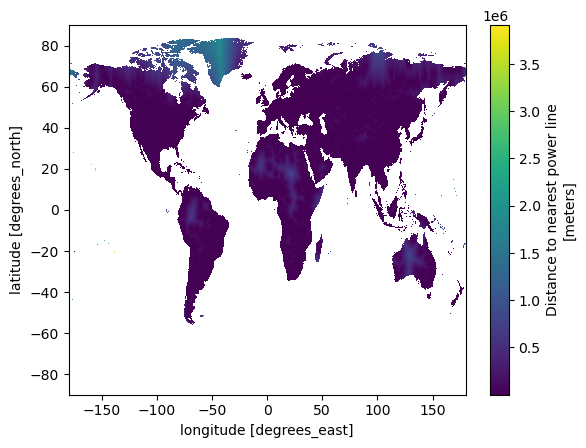

In [4]:
# Coarsen and plot the dataset
# Use boundary='trim' to handle dimensions that aren't exactly divisible by window size
coarsened = ca_ds.Powerdist.coarsen(lat=10, lon=10, boundary='trim').mean()
coarsened.plot()
plt.show()


In [14]:
# Save directly to netCDF without trying to drop spatial_ref since it doesn't exist
ds = xr.open_dataset(r'D:\xarray\aligned2\Feature_all\GURdist_2015.nc')

ds

<xarray.Dataset> Size: 4GB
Dimensions:      (time: 1, lon: 43200, lat: 21600)
Coordinates:
  * time         (time) datetime64[ns] 8B 2015-01-01
    spatial_ref  int32 4B ...
  * lon          (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat          (lat) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    band         int32 4B ...
Data variables:
    GURdist      (time, lat, lon) float32 4GB ...

## 居民点修正

In [8]:
import os
import tempfile
import numpy as np
import xarray as xr
import rioxarray  # noqa: F401
from osgeo import gdal
import rasterio
from rasterio.vrt import WarpedVRT
from rasterio.windows import Window
import dask.array as da
from rasterio.transform import from_origin
import warnings
from tqdm.auto import tqdm

warnings.filterwarnings('ignore', category=UserWarning, message='CRS mismatch')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered')


def compute_gurs_distance_with_blocks(
    template_path: str,
    gurs_paths: list[str],
    output_dir: str,
    *,
    block_size: int = 5000,
    overlap: int = 500,
    land_mask_var: str = "land_mask",
    land_value: int = 1,
    proj_crs: str = "EPSG:6933",
    dtype: str = "float32",
    compress: bool = True
):
    """
    使用分块+WarpedVRT方式计算到最近GURS (值==1或2) 像元的距离，避免一次性重投影导致的内存暴涨。
    输出每个年份一个 NetCDF 文件，变量名 GURdist，坐标 (time, lat, lon)，time=YYYY-01-01。
    """

    # 1. 创建输出目录
    os.makedirs(output_dir, exist_ok=True)

    # 2. 读取并检查模板 NetCDF，确保含 CRS 和 land_mask_var
    print("🔄 读取原始模板并写入 CRS…")
    ds_orig = xr.open_dataset(template_path)
    try:
        ds_orig = ds_orig.rio.write_crs("EPSG:4326", inplace=False)
    except Exception:
        ds_orig = ds_orig

    if land_mask_var not in ds_orig:
        raise KeyError(f"模板中未找到 '{land_mask_var}' 变量")

    # 3. 将模板投影到目标 CRS，获取投影后掩膜 da_mask_proj
    print(f"🌐 将模板投影到 {proj_crs}…")
    try:
        ds_proj = ds_orig.rio.reproject(proj_crs)
    except Exception:
        ds_orig = ds_orig.rio.write_crs("EPSG:4326")
        ds_proj = ds_orig.rio.reproject(proj_crs)

    da_mask_proj = ds_proj[land_mask_var]
    transform_proj = da_mask_proj.rio.transform()       # 投影 CRS 下的 Affine
    crs_proj = da_mask_proj.rio.crs                   # 投影 CRS
    crs_proj_wkt = crs_proj.to_wkt()                   # 投影 CRS WKT 字符串
    height_proj, width_proj = da_mask_proj.shape
    pixel_size_proj = abs(da_mask_proj.rio.resolution()[0])  # 单位：米

    print(f"🗺 投影后网格大小: {height_proj} 行 × {width_proj} 列；像元大小 ≈ {pixel_size_proj:.2f} m")

    # 4. 遍历每个 GURS 文件
    for gurs_path in tqdm(gurs_paths, desc="处理年份", unit="年"):
        # 从文件名中提取年份
        year_str = os.path.splitext(os.path.basename(gurs_path))[0]
        if "_" in year_str and year_str.split("_")[-1].isdigit():
            yyyy = year_str.split("_")[-1]
        else:
            raise ValueError(f"无法从文件名 '{year_str}' 中提取年份，请确保格式如 'GURS_YYYY.tif'。")

        print(f"\n—— 处理年份 {yyyy} ——")

        # 4.1 打开 GURS 源文件，读取原始 CRS 和分辨率
        with rasterio.open(gurs_path) as src:
            orig_crs = src.crs.to_string()
            res_gurs = src.res
            print(f"   原始 GURS CRS: {orig_crs}")
            print(f"   原始 GURS 分辨率: {res_gurs[0]:.6f} × {res_gurs[1]:.6f} ({src.dtypes[0]})")

            # 4.2 创建 WarpedVRT，将其虚拟为投影 CRS + 投影网格对齐
            vrt_options = {
                "crs": proj_crs,                   # 目标 CRS
                "transform": transform_proj,       # 目标 Affine（Affine 对象）
                "width": width_proj,               # 目标宽度
                "height": height_proj,             # 目标高度
                "resampling": rasterio.enums.Resampling.nearest,
                # 如果 GURS 有 nodata，可以额外传 "dst_nodata": src.nodata
            }
            with WarpedVRT(src, **vrt_options) as vrt:
                """
                vrt: 虚拟文件，代表 GURS 重投影到 EPSG:6933 并对齐到 da_mask_proj 网格后的样子，
                     但并不实际占用全部内存。之后针对每个块用 `vrt.read(window=…)` 逐块读取。
                """

                # 4.3 准备一个全图大小的距离数组，后面分块计算再写入
                dist_m = np.zeros((height_proj, width_proj), dtype=np.float32)

                # 4.4 计算分块数目
                n_blocks_y = (height_proj + block_size - 1) // block_size
                n_blocks_x = (width_proj + block_size - 1) // block_size
                print(f"   ↳ 分块处理: 共 {n_blocks_y} 行块 × {n_blocks_x} 列块")

                driver = gdal.GetDriverByName("GTiff")

                def process_block(start_y: int, start_x: int, h: int, w: int) -> np.ndarray:
                    """
                    处理一个块（带 overlap）：
                    1. 用 vrt.read 读取该投影下块的数据
                    2. 将值==1 或 ==2 转为 1，其余为 0，生成 mask_uint8
                    3. 用 GDAL ComputeProximity 计算像素距离，再乘像元大小得到米距离
                    4. 裁剪 overlap 后返回核心 h×w 大小的距离块
                    """
                    # 4.5.1 计算带 overlap 的区域坐标
                    y0 = max(0, start_y - overlap)
                    x0 = max(0, start_x - overlap)
                    y1 = min(height_proj, start_y + h + overlap)
                    x1 = min(width_proj, start_x + w + overlap)
                    win_h = y1 - y0
                    win_w = x1 - x0

                    # 4.5.2 用 WarpedVRT 在该 window 里读取投影后值
                    window = Window(col_off=x0, row_off=y0, width=win_w, height=win_h)
                    arr_proj = vrt.read(1, window=window)

                    # 4.5.3 生成 0/1 掩膜
                    mask_bool = np.logical_or(arr_proj == 1, arr_proj == 2)
                    mask_uint8 = mask_bool.astype("uint8")

                    # 4.5.4 用 GDAL ComputeProximity 计算像素距离
                    with tempfile.TemporaryDirectory() as tmpdir:
                        mask_tif = os.path.join(tmpdir, "mask_block.tif")
                        dist_tif = os.path.join(tmpdir, "dist_block.tif")

                        # 4.5.4.1 构造该块在投影空间的 Affine
                        block_transform = from_origin(
                            transform_proj.c + x0 * transform_proj.a,
                            transform_proj.f + y0 * transform_proj.e,
                            transform_proj.a,
                            transform_proj.e
                        )

                        # 4.5.4.2 写入 mask_block.tif
                        ds_mask = driver.Create(mask_tif, win_w, win_h, 1, gdal.GDT_Byte)
                        ds_mask.SetGeoTransform(block_transform.to_gdal())
                        ds_mask.SetProjection(crs_proj_wkt)
                        band = ds_mask.GetRasterBand(1)
                        band.WriteArray(mask_uint8)
                        band.FlushCache()
                        ds_mask = None

                        # 4.5.4.3 创建 dist_block.tif 并 ComputeProximity
                        ds_dist = driver.Create(dist_tif, win_w, win_h, 1, gdal.GDT_Float32)
                        ds_dist.SetGeoTransform(block_transform.to_gdal())
                        ds_dist.SetProjection(crs_proj_wkt)

                        src_ds = gdal.Open(mask_tif)
                        src_band = src_ds.GetRasterBand(1)
                        dst_band = ds_dist.GetRasterBand(1)
                        gdal.ComputeProximity(src_band, dst_band, ["VALUES=1"])
                        ds_dist.FlushCache()
                        ds_dist = None
                        src_ds = None

                        # 4.5.4.4 读取 dist_block 并乘像元大小转换为米
                        with rasterio.open(dist_tif) as src_dist:
                            dist_block = src_dist.read(1)
                        dist_block = dist_block.astype(np.float32) * pixel_size_proj

                    # 4.5.5 裁剪掉 overlap 区域，只留核心部分
                    top = overlap if start_y > 0 else 0
                    left = overlap if start_x > 0 else 0
                    bottom = dist_block.shape[0] - (overlap if start_y + h < height_proj else 0)
                    right = dist_block.shape[1] - (overlap if start_x + w < width_proj else 0)

                    return dist_block[top:bottom, left:right]

                # 4.6 遍历所有块，调用 process_block 并写回 dist_m
                for by in range(n_blocks_y):
                    for bx in range(n_blocks_x):
                        sy = by * block_size
                        sx = bx * block_size
                        hh = min(block_size, height_proj - sy)
                        ww = min(block_size, width_proj - sx)

                        dist_m[sy: sy + hh, sx: sx + ww] = process_block(sy, sx, hh, ww)

        # 5. dist_m 填满后，下面把它变为 DataArray 并输出
        # 5.1 包装成投影空间下的 DataArray
        dist_da = xr.DataArray(
            da.from_array(dist_m, chunks=(block_size, block_size)),
            dims=("y", "x"),
            coords={
                "y": da_mask_proj.coords["y"].values,
                "x": da_mask_proj.coords["x"].values,
            },
            name="GURdist"
        ).rio.write_crs(proj_crs)

        # 5.2 将其重投影到原始模板的经纬度网格
        print("   ↳ 将距离场重投影回经纬度网格…")
        template_mask = ds_orig[land_mask_var]
        dist_da_latlon = dist_da.rio.reproject_match(template_mask)

        # 5.3 在经纬度网格上应用土地掩膜（非 land_value 设 NaN）
        print("   ↳ 应用土地掩膜…")
        mask_orig = (template_mask.values == land_value)
        dist_da_latlon = dist_da_latlon.where(mask_orig)

        # 5.4 添加 time 维度
        print("   ↳ 构造带时间维度的 DataArray…")
        time_coord = np.array([np.datetime64(f"{yyyy}-01-01")])
        dist_da_with_time = dist_da_latlon.expand_dims({"time": time_coord}, axis=0)
        dist_da_with_time.name = "GURdist"
        dist_da_with_time.attrs.update({
            "units": "meters",
            "long_name": f"Distance to GURS {yyyy} pixels (value=1 or 2)"
        })
        dist_da_with_time = dist_da_with_time.rio.write_crs(ds_orig.rio.crs)

        # 5.5 写出 NetCDF
        out_filename = os.path.join(output_dir, f"GURdist_{yyyy}.nc")
        print(f"   ↳ 保存结果到 {out_filename} …")
        encoding = {
            "GURdist": {
                "dtype": dtype,
                "zlib": compress,
                "complevel": 4 if compress else 0,
                "chunksizes": (1, block_size, block_size)
            }
        }
        write_task = dist_da_with_time.to_netcdf(
            out_filename,
            encoding=encoding,
            compute=False,
            engine="netcdf4"
        )
        write_task.compute()
        print(f"   ✅ {yyyy} 年处理完成\n")

    print("🎉 所有年份处理完毕。")


# ===== 使用示例 =====
if __name__ == "__main__":
    template_nc = "D:/xarray/aligned2/master_final.nc"
    gurs2015 = "D:/xarray/pre-process/GURS_2015.tif"
    gurs2020 = "D:/xarray/pre-process/GURS_2020.tif"
    output_dir = "D:/xarray/aligned2/GURdist"

    compute_gurs_distance_with_blocks(
        template_path=template_nc,
        gurs_paths=[gurs2020],
        output_dir=output_dir,
        block_size=1000,    # 根据内存调整
        overlap=300,        # 根据预期距离调整
        land_mask_var="land_mask",
        land_value=1,
        proj_crs="EPSG:6933",
        dtype="float32",
        compress=True
    )


🔄 读取原始模板并写入 CRS…
🌐 将模板投影到 EPSG:6933…
🗺 投影后网格大小: 18807 行 × 44487 列；像元大小 ≈ 780.79 m


处理年份:   0%|          | 0/1 [00:00<?, ?年/s]


—— 处理年份 2020 ——
   原始 GURS CRS: ESRI:54009
   原始 GURS 分辨率: 100.000000 × 100.000000 (uint8)
   ↳ 分块处理: 共 19 行块 × 45 列块
   ↳ 将距离场重投影回经纬度网格…
   ↳ 应用土地掩膜…
   ↳ 构造带时间维度的 DataArray…
   ↳ 保存结果到 D:/xarray/aligned2/GURdist\GURdist_2020.nc …


处理年份: 100%|██████████| 1/1 [09:46<00:00, 586.07s/年]

   ✅ 2020 年处理完成

🎉 所有年份处理完毕。



Clipped dataset info:
<xarray.Dataset> Size: 6MB
Dimensions:      (time: 1, lon: 1248, lat: 1140)
Coordinates:
  * time         (time) datetime64[ns] 8B 2020-01-01
  * lon          (lon) float64 10kB -124.5 -124.5 -124.5 ... -114.1 -114.1
  * lat          (lat) float64 9kB 42.0 41.99 41.98 41.97 ... 32.52 32.51 32.5
Data variables:
    spatial_ref  int32 4B ...
    GURdist      (time, lat, lon) float32 6MB ...

GURdist data type: float32
GURdist shape: (1, 1140, 1248)

GURdist statistics:
Min value: 0.0
Max value: 105409.52
Mean value: 20038.58


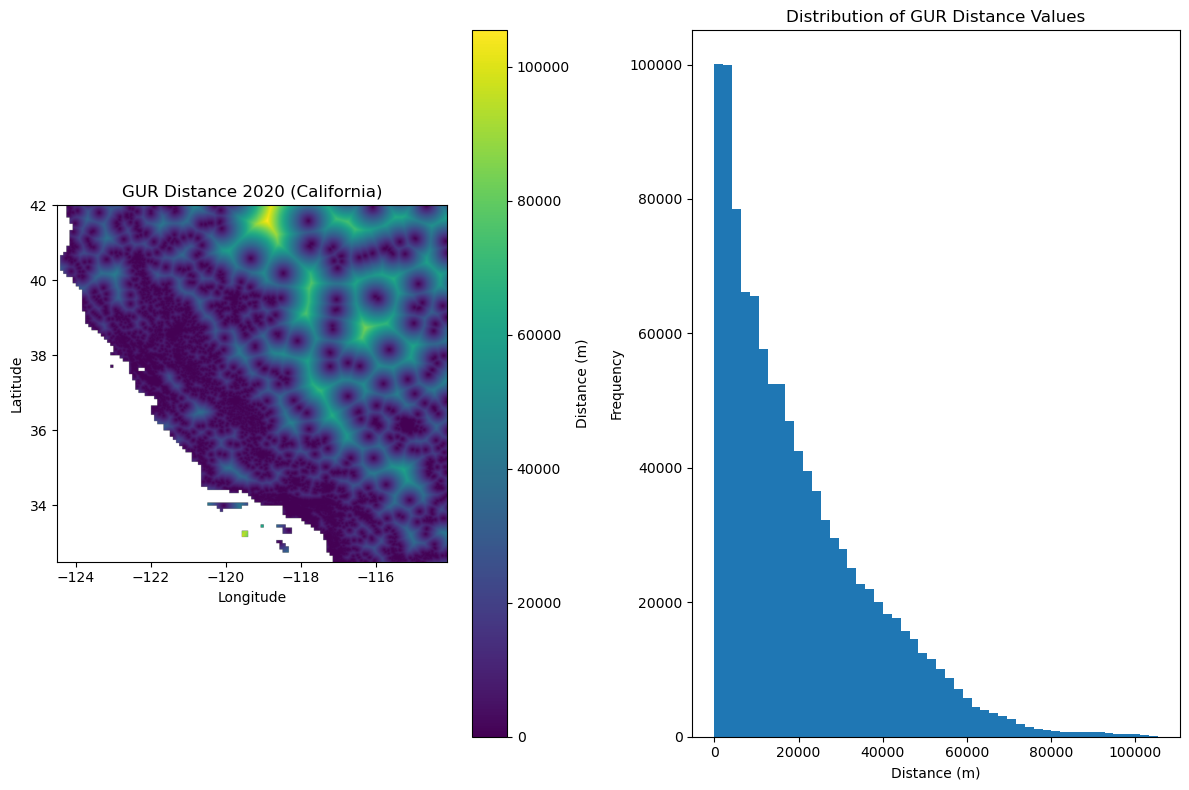

In [38]:
# Read the file
ca_bounds = {
    "minx": -124.5,
    "miny": 32.5,
    "maxx": -114.1,
    "maxy": 42.0
}

# Read and clip the data to California bounds
ds = xr.open_dataset(os.path.join(output_dir, "GURdist_2020_renamed.nc"))

# 注意：因为纬度是从北到南排序的，所以我们需要反转miny和maxy的顺序
ds_ca = ds.sel(
    lat=slice(ca_bounds["maxy"], ca_bounds["miny"]),  # 反转纬度范围的顺序
    lon=slice(ca_bounds["minx"], ca_bounds["maxx"])
)

# 打印裁剪后的数据信息
print("\nClipped dataset info:")
print(ds_ca)
print("\nGURdist data type:", ds_ca.GURdist.dtype)
print("GURdist shape:", ds_ca.GURdist.shape)

# 检查数据是否包含有效值
print("\nGURdist statistics:")
print("Min value:", ds_ca.GURdist.isel(time=0).min().values)
print("Max value:", ds_ca.GURdist.isel(time=0).max().values)
print("Mean value:", ds_ca.GURdist.isel(time=0).mean().values)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

# Plot spatial distribution
plot_data = ds_ca.GURdist.isel(time=0)

# 使用imshow而不是plot，这样可以更好地控制显示
im = ax1.imshow(
    plot_data,
    extent=[ca_bounds["minx"], ca_bounds["maxx"], ca_bounds["miny"], ca_bounds["maxy"]],
    aspect='equal',
    cmap='viridis'
)
plt.colorbar(im, ax=ax1, label='Distance (m)')
ax1.set_title("GUR Distance 2020 (California)")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# Plot histogram of values
ax2.hist(plot_data.values.flatten(), bins=50)
ax2.set_title("Distribution of GUR Distance Values")
ax2.set_xlabel("Distance (m)")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Level 1 (0-5561m): 20.0%
Level 2 (5561-17031m): 20.0%
Level 3 (17031-46280m): 20.0%
Level 4 (46280-127147m): 20.0%
Level 5 (>127147m): 20.0%
Maximum distance value: 51169072m


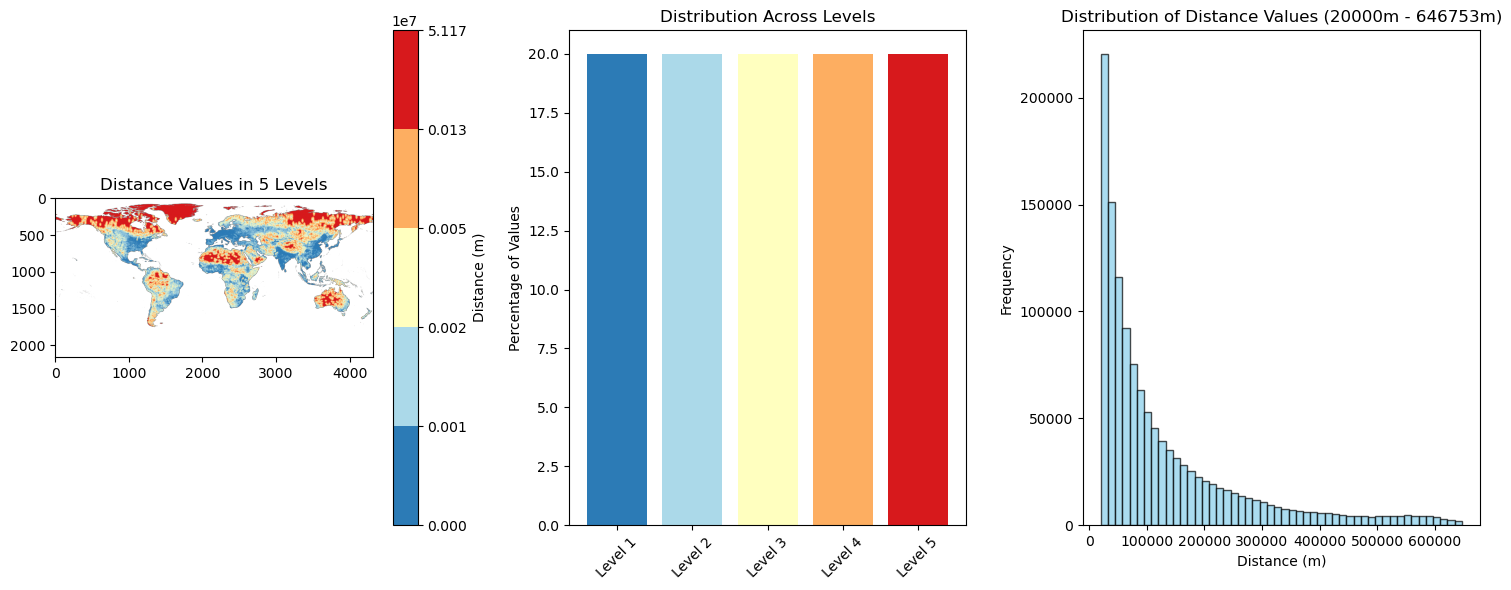

In [53]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import os

# Load the dataset
ds = xr.open_dataset(os.path.join(output_dir, "GURdist_2020_renamed.nc"))

# Coarsen the data by taking mean over blocks
coarse_ds = ds.coarsen(lat=10, lon=10).mean()

# Convert to numpy array and get valid data
data = coarse_ds.GURdist.isel(time=0).values
valid_data = data[~np.isnan(data)].flatten()

# Calculate percentiles for 5 levels
percentiles = np.percentile(valid_data[valid_data > 0], [20, 40, 60, 80])
levels = [0] + list(percentiles) + [valid_data.max()]

# Create level labels
level_labels = [
    f'Level 1 (0-{levels[1]:.0f}m)',
    f'Level 2 ({levels[1]:.0f}-{levels[2]:.0f}m)',
    f'Level 3 ({levels[2]:.0f}-{levels[3]:.0f}m)', 
    f'Level 4 ({levels[3]:.0f}-{levels[4]:.0f}m)',
    f'Level 5 (>{levels[4]:.0f}m)'
]

# Create custom colormap for 5 levels
colors = ['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c']
cmap = ListedColormap(colors)
norm = BoundaryNorm(levels, cmap.N)

# Calculate percentage in each level
level_counts = []
for i in range(len(levels)-1):
    count = np.sum((valid_data > levels[i]) & (valid_data <= levels[i+1]))
    percentage = (count / len(valid_data)) * 100
    level_counts.append(percentage)
    print(f"{level_labels[i]}: {percentage:.1f}%")

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

# Plot 1: Data with 5 levels
im1 = ax1.imshow(data, cmap=cmap, norm=norm)
cbar = plt.colorbar(im1, ax=ax1)
cbar.set_label('Distance (m)')
ax1.set_title('Distance Values in 5 Levels')

# Plot 2: Distribution of levels
ax2.bar(range(5), level_counts, color=colors)
ax2.set_xticks(range(5))
ax2.set_xticklabels(['Level '+str(i+1) for i in range(5)], rotation=45)
ax2.set_ylabel('Percentage of Values')
ax2.set_title('Distribution Across Levels')

# Plot 3: Histogram with level boundaries
# Print maximum value
print(f"Maximum distance value: {valid_data.max():.0f}m")

# Calculate 99th percentile and plot histogram up to that value
percentile_99 = np.percentile(valid_data, 99)
filtered_data = valid_data[valid_data >= 20000]
filtered_data = filtered_data[filtered_data <= percentile_99]
ax3.hist(filtered_data, bins=50, edgecolor='black', color='skyblue', alpha=0.7)
ax3.set_title(f'Distribution of Distance Values (20000m - {percentile_99:.0f}m)')
ax3.set_xlabel('Distance (m)')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Processing years:   0%|          | 0/5 [00:00<?, ?it/s]

Processing rows:   0%|          | 0/149 [00:00<?, ?it/s]


Year 2000:
Urban area (Value 1): 38,160,900 pixels (381,609.00 km2)
Rural area (Value 2): 60,713,608 pixels (607,136.08 km2)


Processing rows:   0%|          | 0/149 [00:00<?, ?it/s]


Year 2005:
Urban area (Value 1): 45,183,607 pixels (451,836.07 km2)
Rural area (Value 2): 65,605,284 pixels (656,052.84 km2)


Processing rows:   0%|          | 0/149 [00:00<?, ?it/s]


Year 2010:
Urban area (Value 1): 51,516,489 pixels (515,164.89 km2)
Rural area (Value 2): 71,036,885 pixels (710,368.85 km2)


Processing rows:   0%|          | 0/149 [00:00<?, ?it/s]


Year 2015:
Urban area (Value 1): 58,242,585 pixels (582,425.85 km2)
Rural area (Value 2): 74,982,052 pixels (749,820.52 km2)


Processing rows:   0%|          | 0/149 [00:00<?, ?it/s]


Year 2020:
Urban area (Value 1): 62,951,188 pixels (629,511.88 km2)
Rural area (Value 2): 82,801,523 pixels (828,015.23 km2)


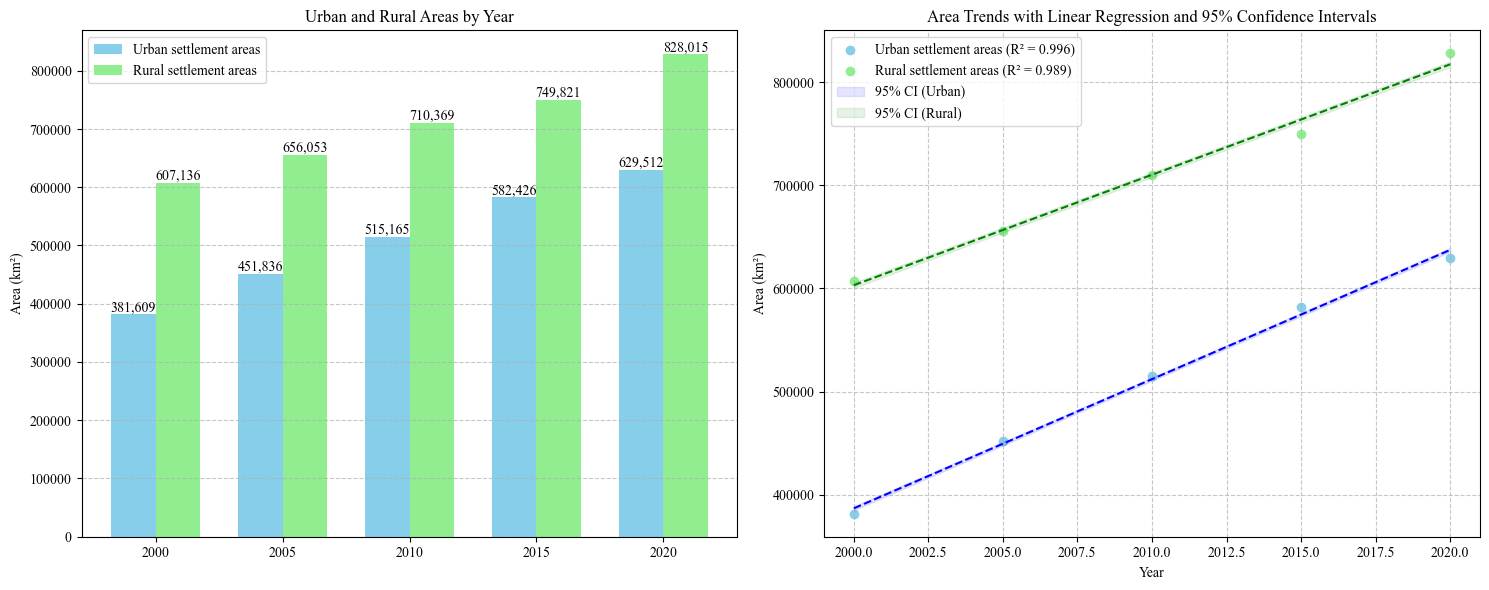


Trend Analysis:
Urban area change rate: 12527.91 km²/year
Rural area change rate: 10710.52 km²/year


In [2]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm
import matplotlib.font_manager as fm

# Set Times New Roman font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # For math text

# Define file paths and years - Updated to include 2000
gurs_files = {
    2000: "D:/xarray/pre-process/GURS_2000.tif",
    2005: "D:/xarray/pre-process/GURS_2005.tif",
    2010: "D:/xarray/pre-process/GURS_2010.tif", 
    2015: "D:/xarray/pre-process/GURS_2015.tif",
    2020: "D:/xarray/pre-process/GURS_2020.tif"
}

# Initialize lists to store results
years = []
urban_areas = []  # Value 1
rural_areas = []  # Value 2

# Process each year
for year, filepath in tqdm(gurs_files.items(), desc="Processing years"):
    with rasterio.open(filepath) as src:
        # Process in chunks to avoid memory issues
        urban_count = 0
        rural_count = 0
        window_size = 1000  # Adjust based on available memory
        
        for j in tqdm(range(0, src.height, window_size), desc="Processing rows", leave=False):
            height = min(window_size, src.height - j)
            for i in range(0, src.width, window_size):
                width = min(window_size, src.width - i)
                window = rasterio.windows.Window(i, j, width, height)
                data = src.read(1, window=window)
                
                urban_count += np.sum(data == 1)
                rural_count += np.sum(data == 2)
                
        urban_area = urban_count * 0.01  # km2
        rural_area = rural_count * 0.01  # km2
    
    years.append(year)
    urban_areas.append(urban_area)
    rural_areas.append(rural_area)
    
    print(f"\nYear {year}:")
    print(f"Urban area (Value 1): {urban_count:,} pixels ({urban_area:,.2f} km2)")
    print(f"Rural area (Value 2): {rural_count:,} pixels ({rural_area:,.2f} km2)")



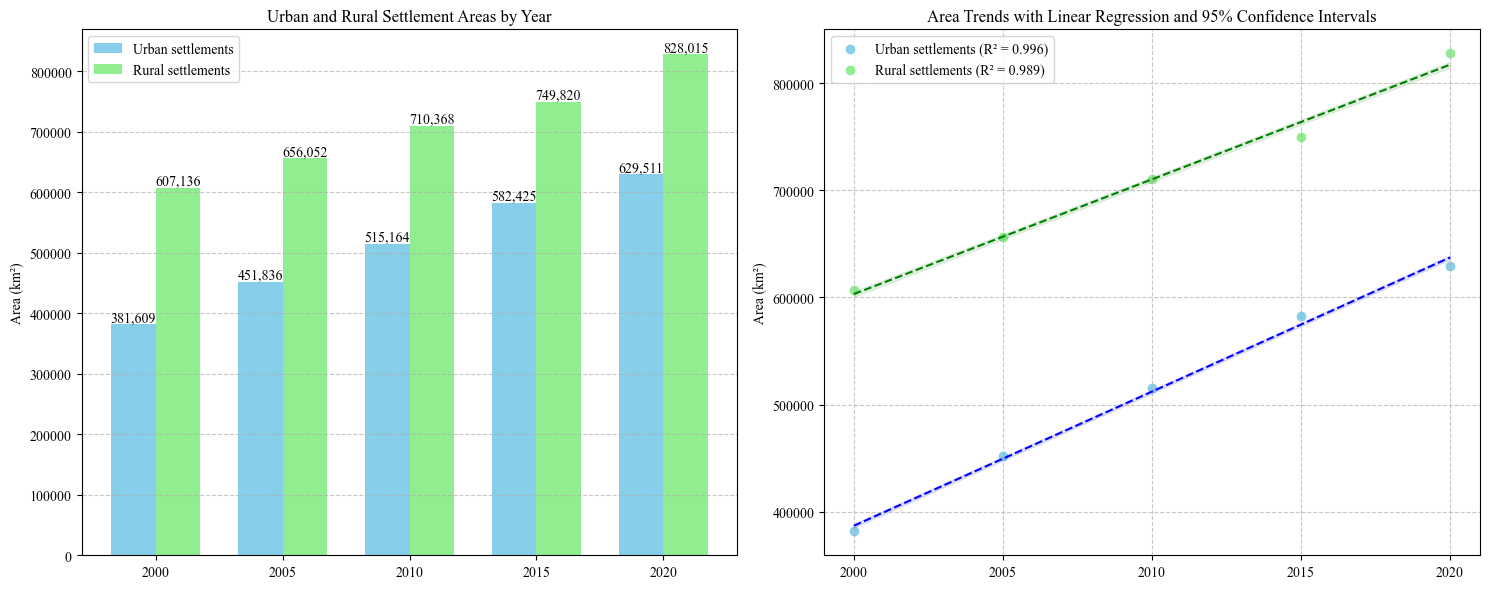


Trend Analysis:
Urban area change rate: 12527.91 km²/year
Rural area change rate: 10710.52 km²/year


: 

In [ ]:
years_0 = [2000, 2005, 2010, 2015, 2020]
urban_areas_0 = [381,609.00, 451,836.07 , 515,164.89 , 582,425.85 , 629,511.88 ]
rural_areas_0 = [607,136.08, 656,052.84 ,710,368.85 ,749,820.52 , 828,015.23 ]




# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Bar chart showing both areas over years
x = np.arange(len(years))
width = 0.35

ax1.bar(x - width/2, urban_areas, width, label='Urban settlements', color='skyblue')
ax1.bar(x + width/2, rural_areas, width, label='Rural settlements', color='lightgreen')

ax1.set_ylabel('Area (km²)', fontfamily='Times New Roman')
ax1.set_title('Urban and Rural Settlement Areas by Year', fontfamily='Times New Roman')
ax1.set_xticks(x)
ax1.set_xticklabels(years, fontfamily='Times New Roman')
ax1.legend(prop={'family': 'Times New Roman'})
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels with Times New Roman font
for i, v in enumerate(urban_areas):
    ax1.text(i - width/2, v, f'{int(v):,}', ha='center', va='bottom', fontfamily='Times New Roman')
for i, v in enumerate(rural_areas):
    ax1.text(i + width/2, v, f'{int(v):,}', ha='center', va='bottom', fontfamily='Times New Roman')

# Plot 2: Trend analysis with confidence intervals
years_array = np.array(years)

# Calculate confidence intervals for urban areas
urban_slope, urban_intercept, urban_r, _, urban_stderr = stats.linregress(years_array, urban_areas)
urban_y_pred = urban_slope * years_array + urban_intercept

# Calculate confidence intervals
urban_ci = urban_stderr * stats.t.ppf(0.975, len(years_array)-2)
urban_pi = urban_ci * np.sqrt(1 + 1/len(years_array) + 
                             (years_array - np.mean(years_array))**2 / 
                             np.sum((years_array - np.mean(years_array))**2))

# Calculate confidence intervals for rural areas
rural_slope, rural_intercept, rural_r, _, rural_stderr = stats.linregress(years_array, rural_areas)
rural_y_pred = rural_slope * years_array + rural_intercept

rural_ci = rural_stderr * stats.t.ppf(0.975, len(years_array)-2)
rural_pi = rural_ci * np.sqrt(1 + 1/len(years_array) + 
                             (years_array - np.mean(years_array))**2 / 
                             np.sum((years_array - np.mean(years_array))**2))

# Plot data points and trend lines with confidence intervals
ax2.scatter(years, urban_areas, color='skyblue', label=f'Urban settlements (R² = {urban_r**2:.3f})')
ax2.scatter(years, rural_areas, color='lightgreen', label=f'Rural settlements (R² = {rural_r**2:.3f})')

ax2.plot(years, urban_y_pred, '--', color='blue')
ax2.fill_between(years, urban_y_pred - urban_pi, urban_y_pred + urban_pi, 
                 color='blue', alpha=0.1)

ax2.plot(years, rural_y_pred, '--', color='green')
ax2.fill_between(years, rural_y_pred - rural_pi, rural_y_pred + rural_pi,
                 color='green', alpha=0.1)

ax2.set_ylabel('Area (km²)', fontfamily='Times New Roman')
# ax2.set_xlabel('Year', fontfamily='Times New Roman')
ax2.set_title('Area Trends with Linear Regression and 95% Confidence Intervals', fontfamily='Times New Roman')
ax2.legend(prop={'family': 'Times New Roman'})
ax2.grid(True, linestyle='--', alpha=0.7)

ax2.set_xticks(years)  # 设置刻度位置
ax2.set_xticklabels(years, fontfamily='Times New Roman')  # 设置刻度标签

# Set Times New Roman font for tick labels
for ax in [ax1, ax2]:
    ax.tick_params(axis='both', which='major', labelsize=10)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('Times New Roman')

plt.tight_layout()
plt.show()

# Print trend analysis results
print("\nTrend Analysis:")
print(f"Urban area change rate: {urban_slope:.2f} km²/year")
print(f"Rural area change rate: {rural_slope:.2f} km²/year")




# 自然保护地数据修正

In [4]:
import numpy as np
import xarray as xr
import rasterio
from rasterio import features
import gc
from tqdm.auto import tqdm
import geopandas as gpd
from pathlib import Path

def print_memory_usage(label):
    """Print current memory usage with a label."""
    import psutil
    process = psutil.Process()
    memory_gb = process.memory_info().rss / 1024 / 1024 / 1024
    print(f"Memory usage ({label}): {memory_gb:.2f} GB")


def rasterize_chunk(chunk_gdf, transform, height, width):
    """Rasterize a single (possibly unioned) geometry into a boolean array."""
    try:
        # Use union_all() instead of deprecated unary_union
        geom = chunk_gdf.geometry.union_all()
        return features.rasterize(
            [(geom, 1)],
            out_shape=(height, width),
            transform=transform,
            all_touched=True,
            dtype='uint8',
        )
    except Exception as e:
        print(f"[rasterize_chunk] Error: {e}")
        return np.zeros((height, width), dtype=bool)


def process_protected_areas(gdfs, master_path, output_path, chunk_size=500):
    """Convert multiple GeoDataFrames into a single boolean mask NetCDF."""
    print_memory_usage("Initial")
    
    with xr.open_dataset(master_path) as master:
        lat = master.lat.values
        lon = master.lon.values
        mask_template = master.land_mask.values.astype(bool)
    
        height, width = len(lat), len(lon)
        dx = (lon[-1] - lon[0]) / (width  - 1)
        dy = (lat[-1] - lat[0]) / (height - 1)
    
        # Pre-allocate final boolean mask
        protected = np.zeros((height, width), dtype=bool)
    
        for i, gdf in enumerate(gdfs, start=1):
            print(f"\n→ Processing GDF {i}/{len(gdfs)}")
            if gdf.crs.to_string() != "EPSG:4326":
                gdf = gdf.to_crs("EPSG:4326")
    
            for y in tqdm(range(0, height, chunk_size), desc="Lat chunks"):
                y_end = min(y + chunk_size, height)
                maxy = lat[y_end-1] + dy/2  # chunk top edge
                for x in range(0, width, chunk_size):
                    x_end = min(x + chunk_size, width)
                    minx = lon[x] - dx/2      # chunk left edge
    
                    # Clip and union
                    small = gdf.cx[minx : lon[x_end-1] + dx/2, 
                                   lat[y] - dy/2 : maxy]
                    if small.empty:
                        continue
    
                    # Rasterize into chunk
                    transform_chunk = rasterio.transform.from_origin(
                        minx, maxy, dx, dy
                    )
                    tile = rasterize_chunk(
                        small, transform_chunk,
                        y_end - y, x_end - x
                    )
    
                    # In-place OR
                    np.logical_or(
                        protected[y:y_end, x:x_end], 
                        tile,
                        out=protected[y:y_end, x:x_end]
                    )
    
                    # clean up per‐tile
                    del small, tile
                    gc.collect()
    
                if (y // chunk_size) % 5 == 0:
                    print_memory_usage(f"After lat {lat[y]:.2f}")
    
        # Mask out non-land and build xarray
        protected &= mask_template
        ds = xr.Dataset(
            {"protected_area": (("lat","lon"), protected)},
            coords={"lat":lat, "lon":lon},
        )
        ds.protected_area.attrs = {
            "long_name":"Protected Area",
            "description":"Boolean mask of protected areas",
            "units":"1",
            "dtype":"bool",
        }
    
        # Write with compression + chunking
        enc = {
            "protected_area": {
                "dtype":"int8", "zlib":True, "complevel":5,
                "_FillValue":-1,
                "chunksizes":(chunk_size, chunk_size),
            }
        }
        print("\nSaving to NetCDF…")
        ds.to_netcdf(output_path, engine="netcdf4", encoding=enc)
        print(f"✅ Saved to {output_path}")
        print_memory_usage("Final")


# Usage example
if __name__ == "__main__":
    # Paths
    MASTER = Path(r"D:\xarray\aligned2\master_final.nc")
    OUTPUT = Path(r"D:\xarray\aligned2\protect\protected_areas.nc")
    
    # Load GeoDataFrames
    shp_paths = [
        r"D:\Photovoltaic_data\Reference_data\PA\Global_PA\shp1\WDPA_Apr2025_Public_shp-polygons.shp",
        r"D:\Photovoltaic_data\Reference_data\PA\Global_PA\shp2\WDPA_Apr2025_Public_shp-polygons.shp",
        r"D:\Photovoltaic_data\Reference_data\PA\Global_PA\shp3\WDPA_Apr2025_Public_shp-polygons.shp"
    ]
    
    gdfs = []
    for path in shp_paths:
        print(f"Loading {Path(path).name}...")
        gdf = gpd.read_file(path)
        gdfs.append(gdf)
    
    # Process all GeoDataFrames
    process_protected_areas(
        gdfs=gdfs,
        master_path=MASTER,
        output_path=OUTPUT,
        chunk_size=500
    )


Loading WDPA_Apr2025_Public_shp-polygons.shp...
Loading WDPA_Apr2025_Public_shp-polygons.shp...
Loading WDPA_Apr2025_Public_shp-polygons.shp...
Memory usage (Initial): 17.15 GB

→ Processing GDF 1/3


Lat chunks:   0%|          | 0/44 [00:00<?, ?it/s]

Memory usage (After lat 90.00): 18.87 GB
Memory usage (After lat 69.16): 18.81 GB
Memory usage (After lat 48.33): 14.08 GB
Memory usage (After lat 27.50): 14.17 GB
Memory usage (After lat 6.66): 14.25 GB
Memory usage (After lat -14.17): 14.33 GB
Memory usage (After lat -35.00): 14.40 GB
Memory usage (After lat -55.84): 14.33 GB
Memory usage (After lat -76.67): 14.33 GB

→ Processing GDF 2/3


Lat chunks:   0%|          | 0/44 [00:00<?, ?it/s]

Memory usage (After lat 90.00): 14.33 GB
Memory usage (After lat 69.16): 8.92 GB


c:\Users\zpy10\Anaconda3\envs\geo\Lib\site-packages\shapely\set_operations.py:419: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


Memory usage (After lat 48.33): 3.76 GB
Memory usage (After lat 27.50): 4.51 GB
Memory usage (After lat 6.66): 4.66 GB
Memory usage (After lat -14.17): 4.49 GB
Memory usage (After lat -35.00): 4.66 GB
Memory usage (After lat -55.84): 4.83 GB
Memory usage (After lat -76.67): 4.86 GB

→ Processing GDF 3/3


Lat chunks:   0%|          | 0/44 [00:00<?, ?it/s]

Memory usage (After lat 90.00): 4.91 GB
Memory usage (After lat 69.16): 4.77 GB
Memory usage (After lat 48.33): 6.56 GB
Memory usage (After lat 27.50): 6.99 GB
Memory usage (After lat 6.66): 7.06 GB
Memory usage (After lat -14.17): 7.11 GB
Memory usage (After lat -35.00): 7.16 GB
Memory usage (After lat -55.84): 7.35 GB
Memory usage (After lat -76.67): 7.35 GB

Saving to NetCDF…
✅ Saved to D:\xarray\aligned2\protect\protected_areas.nc
Memory usage (Final): 8.45 GB


# 森林碳累积速率预处理

## 累积速率预处理

In [9]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
import rasterio
from tqdm import tqdm

# ───────── 配置 ─────────

MASTER   = r"D:\xarray\aligned2\master_final.nc"
SRC_DIR  = Path(r"D:\xarray\pre-process")
OUT_DIR  = Path(r"D:\xarray\aligned2\emission")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# 文件路径
file_path = SRC_DIR / "sequestration_rate__mean__aboveground__full_extent__Mg_C_ha_yr.tif"

# ───────── 1. 读取模板 & 掩膜 ─────────
print("读取模板和掩膜...")
tmpl = xr.open_dataset(MASTER)
lat  = tmpl["lat"]
lon  = tmpl["lon"]
mask = tmpl["land_mask"]

# 设置分块大小 - 较小的块以避免内存溢出
chunk_lat = 1000
chunk_lon = 1000

# ───────── 2. 读取数据 ─────────
print("读取数据...")
try:
    out_nc = OUT_DIR / "sequestration.nc"
    
    # 检查文件是否已存在
    if out_nc.exists():
        print(f"文件已存在，跳过: {out_nc.name}")
    else:
        # 创建结果数组
        result_shape = (len(lat), len(lon))
        result = np.full(result_shape, np.nan, dtype=np.float32)
        
        # 分块处理
        lat_chunks = np.array_split(np.arange(len(lat)), max(1, len(lat) // chunk_lat))
        lon_chunks = np.array_split(np.arange(len(lon)), max(1, len(lon) // chunk_lon))
        
        total_chunks = len(lat_chunks) * len(lon_chunks)
        with tqdm(total=total_chunks, desc="处理数据") as pbar:
            for i, lat_indices in enumerate(lat_chunks):
                lat_values = lat.values[lat_indices]
                lat_start, lat_end = lat_indices[0], lat_indices[-1] + 1
                
                for j, lon_indices in enumerate(lon_chunks):
                    lon_values = lon.values[lon_indices]
                    lon_start, lon_end = lon_indices[0], lon_indices[-1] + 1
                    
                    # 读取原始数据的这一块
                    with rasterio.open(file_path) as src:
                        da = (
                            rxr.open_rasterio(file_path, masked=True)
                            .isel(band=0)
                            .rio.set_spatial_dims("x", "y", inplace=False)
                            .rename({"x": "lon", "y": "lat"})
                        )
                        
                        # 只对当前块进行插值
                        chunk_result = da.interp(
                            lon=lon_values, 
                            lat=lat_values, 
                            method="nearest"
                        ).compute()
                        
                        # 将结果放入结果数组
                        result[lat_start:lat_end, lon_start:lon_end] = chunk_result.values
                        
                        # 清理内存
                        del da, chunk_result
                        gc.collect()
                    
                    pbar.update(1)
        
        # 创建新的DataArray
        print("创建最终数据集...")
        da_result = xr.DataArray(
            result,
            coords={"lat": lat, "lon": lon},
            dims=["lat", "lon"],
            name="sequestration"
        )
        
        # 应用掩膜
        da_masked = da_result.where(mask)
        
        # 构造输出数据集
        out_ds = da_masked.to_dataset()
        
        # 设置压缩和分块参数
        encoding = {
            "sequestration": {
                "zlib": True,
                "complevel": 5,
                "chunksizes": (chunk_lat, chunk_lon),
                "_FillValue": np.nan
            }
        }
        
        # 保存为NetCDF文件
        print(f"保存到 {out_nc}...")
        out_ds.to_netcdf(out_nc, encoding=encoding)
        out_ds.close()
        
        # 清理内存
        del da_result, da_masked, out_ds, result
        gc.collect()
        
except Exception as e:
    print(f"处理时出错: {str(e)}")
    if out_nc.exists() and out_nc.is_file():
        out_nc.unlink()  # 删除可能部分写入的文件
finally:
    gc.collect()

# 清理模板数据
del tmpl, lat, lon, mask
gc.collect()

print("✅ 森林累积速率:", OUT_DIR)

读取模板和掩膜...
读取数据...


处理数据: 100%|██████████| 903/903 [7:28:16<00:00, 29.79s/it]  


创建最终数据集...
保存到 D:\xarray\aligned2\emission\sequestration.nc...
✅ 森林累积速率: D:\xarray\aligned2\emission


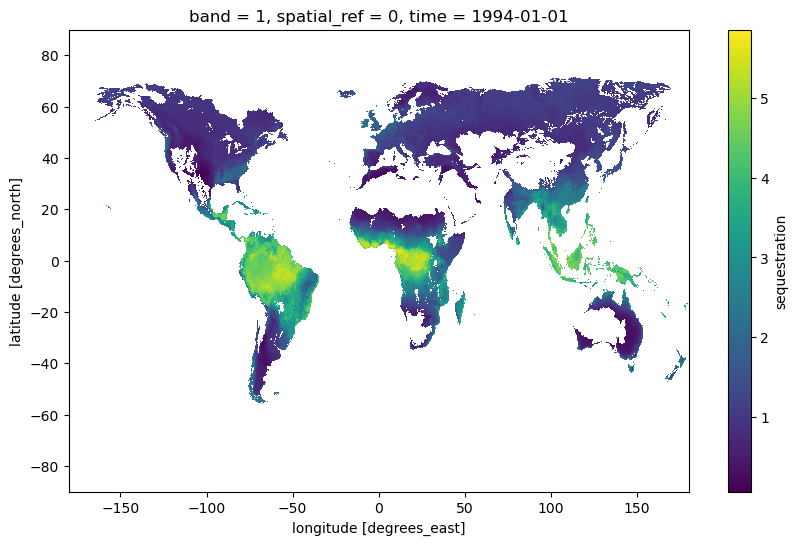

In [1]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
import rasterio
from tqdm import tqdm

MASTER   = r"D:\xarray\aligned2\master_final.nc"
SRC_DIR  = Path(r"D:\xarray\pre-process")
OUT_DIR  = Path(r"D:\xarray\aligned2\emission")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# 文件路径
file_path = OUT_DIR / "Forest_sequestration_rate.nc"

# Open dataset with coarse resolution to avoid memory error
ds_car = xr.open_dataset(file_path)

# Coarsen the data by taking mean over 10x10 grid cells
ds_coarse = ds_car.coarsen(lat=10, lon=10, boundary='trim').mean()

# Plot the coarsened data
ds_coarse.sequestration.plot(figsize=(10,6))


In [2]:
ds_car

<xarray.Dataset> Size: 4GB
Dimensions:        (lat: 21600, lon: 43200)
Coordinates:
  * lat            (lat) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
  * lon            (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0
    band           int32 4B 1
    spatial_ref    int32 4B 0
    time           datetime64[ns] 8B 1994-01-01
Data variables:
    sequestration  (lat, lon) float32 4GB ...

In [3]:
import rioxarray as rxr

# Read and print info about the SOCS tiff file
socs_tif = rxr.open_rasterio(r"D:\xarray\aligned2\emission\SOC_source\SOCS_0_200cm_1km_Present.tif")
print("\nSOCS Tiff Information:")
print("----------------------")
print(f"Dimensions: {socs_tif.dims}")
print(f"Coordinates: {socs_tif.coords}")
print(f"Data type: {socs_tif.dtype}")
print(f"No data value: {socs_tif.rio.nodata}")
print(f"CRS: {socs_tif.rio.crs}")
print(f"Resolution: {socs_tif.rio.resolution()}")
print(f"Bounds: {socs_tif.rio.bounds()}")


SOCS Tiff Information:
----------------------
Dimensions: ('band', 'y', 'x')
Coordinates: Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    spatial_ref  int32 4B 0
Data type: float32
No data value: -3.3999999521443642e+38
CRS: EPSG:4326
Resolution: (0.00833333, -0.00833333)
Bounds: (-180.0, -89.99992800000001, 179.99985600000002, 90.0)


## 土壤碳潜力修正

In [1]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc

def process_tif_to_netcdf(
    tif_path: Path,
    master_nc: str,
    out_dir: Path,
    var_name: str = None,
    chunksizes: tuple = (1000, 1000),
    compress_level: int = 5
):
    """
    将单波段 GeoTIFF 对齐到 master_nc 的投影/分辨率/网格，
    并输出到 out_dir/<tif_stem>.nc。

    参数
    ----
    tif_path : Path
        待处理的 GeoTIFF 文件路径（单波段）。
    master_nc : str
        模板 NetCDF 文件路径，包含 lat, lon, land_mask。
    out_dir : Path
        输出目录。
    var_name : str, optional
        变量名；若为 None，则取 tif 文件名（不含扩展）。
    chunksizes : tuple of int
        在 NetCDF 中的分块大小 (lat_chunks, lon_chunks)。
    compress_level : int
        zlib 压缩等级 (0-9)。
    """
    # 构造输出路径
    stem = tif_path.stem
    out_path = out_dir / f"{stem}.nc"
    if out_path.exists():
        print(f"Skip (exists): {out_path.name}")
        return

    # 读取 master
    ds_master = xr.open_dataset(master_nc)
    mask = ds_master["land_mask"]

    # 读取原 GeoTIFF，取第一个 band，并命名、维度匹配
    da = (
        rxr.open_rasterio(str(tif_path), masked=True)
           .isel(band=0)
    )

    # 一键重投影、重网格：对齐到 master（投影、分辨率、经纬度坐标）
    da_matched = da.rio.reproject_match(ds_master)
    da_matched = da_matched.rename({"x": "lon", "y": "lat"})

    # 应用掩膜
    da_masked = da_matched.where(mask)

    # 设定变量名
    name = var_name or stem
    da_masked.name = name

    # 转为 Dataset 并写出
    ds_out = da_masked.to_dataset()

    encoding = {
        name: {
            "zlib": True,
            "complevel": compress_level,
            "chunksizes": chunksizes,
            "_FillValue": np.nan
        }
    }

    print(f"Writing: {out_path.name} ...")
    ds_out.to_netcdf(str(out_path), encoding=encoding)
    ds_out.close()

    # 清理
    ds_master.close()
    gc.collect()

# ───────── 主流程 ─────────
# if __name__ == "__main__":
#     from tqdm import tqdm

#     MASTER   = r"D:\xarray\aligned2\master_final.nc"
#     SOC_DIR  = Path(r"D:\xarray\aligned2\emission\SOC_source")
#     OUT_DIR  = Path(r"D:\xarray\aligned2\emission")
#     OUT_DIR.mkdir(exist_ok=True, parents=True)

#     tif_files = list(SOC_DIR.glob("*.tif"))
#     with tqdm(tif_files, desc="处理文件") as pbar:
#         for tif in pbar:
#             pbar.set_description(f"处理 {tif.name}")
#             process_tif_to_netcdf(
#                 tif_path=tif,
#                 master_nc=MASTER,
#                 out_dir=OUT_DIR,
#                 var_name=None,           # 或者自定义每个文件的变量名
#                 chunksizes=(1000, 1000), # 根据内存调整
#                 compress_level=5
#             )


In [2]:
# if __name__ == "__main__":
from tqdm import tqdm

MASTER   = r"D:\xarray\aligned2\master_final.nc"
SOC_DIR  = Path(r"D:\xarray\aligned2\emission\SOC_source")
OUT_DIR  = Path(r"D:\xarray\aligned2\emission")
OUT_DIR.mkdir(exist_ok=True, parents=True)

tif_files = list(SOC_DIR.glob("*.tif"))
with tqdm(tif_files, desc="处理文件") as pbar:
    for tif in pbar:
        pbar.set_description(f"处理 {tif.name}")
        process_tif_to_netcdf(
            tif_path=tif,
            master_nc=MASTER,
            out_dir=OUT_DIR,
            var_name=None,           # 或者自定义每个文件的变量名
            chunksizes=(1000, 1000), # 根据内存调整
            compress_level=5
        )


处理 GSOCSEQ_SOCS_BAU.tif:   0%|          | 0/12 [00:00<?, ?it/s]                     

Skip (exists): DATA_GSOCSEQ_MAP_GSOCSEQ.GSOCMAP1-5-0.nc
Skip (exists): GSOCSEQ_RSR_SSM1.nc
Skip (exists): GSOCSEQ_RSR_SSM2.nc
Skip (exists): GSOCSEQ_RSR_SSM3.nc
Writing: GSOCSEQ_SOCS_BAU.nc ...


处理 SOCS_0_200cm_Diff_1km_Present_subtract_NoLU_Upper.tif: 100%|██████████| 12/12 [02:22<00:00, 11.84s/it]

Skip (exists): GSOCSEQ_SOCS_SM1.nc
Skip (exists): GSOCSEQ_SOCS_SM2.nc
Skip (exists): GSOCSEQ_SOCS_SM3.nc
Skip (exists): GSOCSEQ_SOCS_T0X.nc
Skip (exists): SOCS_0_200cm_1km_Present.nc
Skip (exists): SOCS_0_200cm_Diff_1km_Present_subtract_NoLU_Lower.nc
Skip (exists): SOCS_0_200cm_Diff_1km_Present_subtract_NoLU_Upper.nc


## 农作物修正

In [ ]:
import pandas as pd
import requests
from pathlib import Path
import os
from urllib.parse import urlparse

def download_gaez4_crop_data():
    """
    Download GAEZ4 crop data based on specific criteria from CSV file
    """
    # Read the CSV file
    csv_path = r'D:\xarray\aligned2\emission\GAEZ4_crop_source\Suitability and Attainable_content.csv'
    df = pd.read_csv(csv_path)
    
    # Define target crops and time periods
    target_crops = ['Alfalfa', 'Banana', 'Citrus', 'Cocoa', 'Coffee', 'Coconut', 'Oil palm', 'Rubber', 'Sugarcane', 'Tea']
    target_periods = ['2011-2040', '1981-2010']
    
    # Filter the dataframe based on criteria
    filtered_df = df[
        (df['Crop'].isin(target_crops)) & 
        (df['Time Period'].isin(target_periods))
    ]
    
    # Create output directory
    output_dir = Path(r'D:\xarray\aligned2\emission\GAEZ4_crop_source')
    output_dir.mkdir(exist_ok=True, parents=True)
    
    print(f"Found {len(filtered_df)} files to download")
    
    # Download each file
    for index, row in filtered_df.iterrows():
        crop = row['Crop']
        time_period = row['Time Period']
        rcp = row['RCP']
        co2_fertilization = row['CO2 Fertilization']
        download_url = row['Download URL']
        
        # Create filename
        filename = f"{crop}_{time_period}_{rcp}_{co2_fertilization}.tif"
        filepath = output_dir / filename
        
        # Skip if file already exists
        if filepath.exists():
            print(f"File already exists, skipping: {filename}")
            continue
        
        try:
            print(f"Downloading: {filename}")
            print(f"URL: {download_url}")
            
            # Download the file
            response = requests.get(download_url, stream=True)
            response.raise_for_status()
            
            # Save the file
            with open(filepath, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            
            print(f"Successfully downloaded: {filename}")
            
        except Exception as e:
            print(f"Error downloading {filename}: {str(e)}")
            continue
    
    print("Download process completed!")

# Execute the function
if __name__ == "__main__":
    download_gaez4_crop_data()

Found 60 files to download
File already exists, skipping: Alfalfa_2011-2040_RCP8.5_Without CO2 Fertilization.tif
File already exists, skipping: Banana_2011-2040_RCP8.5_Without CO2 Fertilization.tif
File already exists, skipping: Citrus_2011-2040_RCP8.5_Without CO2 Fertilization.tif
File already exists, skipping: Cocoa_2011-2040_RCP8.5_Without CO2 Fertilization.tif
File already exists, skipping: Coffee_2011-2040_RCP8.5_Without CO2 Fertilization.tif
File already exists, skipping: Coconut_2011-2040_RCP8.5_Without CO2 Fertilization.tif
File already exists, skipping: Oil palm_2011-2040_RCP8.5_Without CO2 Fertilization.tif
File already exists, skipping: Rubber_2011-2040_RCP8.5_Without CO2 Fertilization.tif
Downloading: Sugarcane_2011-2040_RCP8.5_Without CO2 Fertilization.tif
URL: https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res05/NorESM1-M/rcp8p5/2020sH/siHr0_suc.tif
Successfully downloaded: Sugarcane_2011-2040_RCP8.5_Without CO2 Fertilization.tif
File already exists, skipping

In [15]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc

def process_tif_to_netcdf(
    tif_path: Path,
    master_nc: str,
    out_dir: Path,
    var_name: str = None,
    chunksizes: tuple = (1000, 1000),
    compress_level: int = 5
):
    """
    将单波段 GeoTIFF 对齐到 master_nc 的投影/分辨率/网格，
    并输出到 out_dir/<tif_stem>.nc。

    参数
    ----
    tif_path : Path
        待处理的 GeoTIFF 文件路径（单波段）。
    master_nc : str
        模板 NetCDF 文件路径，包含 lat, lon, land_mask。
    out_dir : Path
        输出目录。
    var_name : str, optional
        变量名；若为 None，则取 tif 文件名（不含扩展）。
    chunksizes : tuple of int
        在 NetCDF 中的分块大小 (lat_chunks, lon_chunks)。
    compress_level : int
        zlib 压缩等级 (0-9)。
    """
    # 构造输出路径
    stem = tif_path.stem
    out_path = out_dir / f"{stem}.nc"
    if out_path.exists():
        print(f"Skip (exists): {out_path.name}")
        return

    # 读取 master
    ds_master = xr.open_dataset(master_nc)
    mask = ds_master["land_mask"]

    # 读取原 GeoTIFF，取第一个 band，并命名、维度匹配
    da = (
        rxr.open_rasterio(str(tif_path), masked=True)
           .isel(band=0)
    )

    # Remove all encoding-related attributes to prevent conflicts
    for attr in ['_FillValue', 'scale_factor', 'add_offset', 'grid_mapping']:
        if attr in da.attrs:
            del da.attrs[attr]
        if attr in da.encoding:
            del da.encoding[attr]

    # 一键重投影、重网格：对齐到 master（投影、分辨率、经纬度坐标）
    da_matched = da.rio.reproject_match(ds_master)
    da_matched = da_matched.rename({"x": "lon", "y": "lat"})

    # 应用掩膜
    da_masked = da_matched.where(mask)

    # 设定变量名
    name = var_name or stem
    da_masked.name = name

    # 转为 Dataset 并写出
    ds_out = da_masked.to_dataset()

    encoding = {
        name: {
            "zlib": True,
            "complevel": compress_level,
            "chunksizes": chunksizes
            # "_FillValue": np.nan
        }
    }

    print(f"Writing: {out_path.name} ...")
    ds_out.to_netcdf(str(out_path), encoding=encoding)
    ds_out.close()

    # 清理
    ds_master.close()
    gc.collect()

# ───────── 主流程 ─────────
if __name__ == "__main__":
    from tqdm import tqdm

    MASTER   = Path(r"D:\xarray\aligned2\master_final.nc")
    SRC_DIR  = Path(r"D:\xarray\aligned2\emission\GAEZ4_crop_source") 
    OUT_DIR  = Path(r"D:\xarray\aligned2\crop_type")
    OUT_DIR.mkdir(exist_ok=True, parents=True)

    tif_files = [f for f in SRC_DIR.glob("*.tif") if 'Historical' in f.name]
    print(tif_files)
    with tqdm(tif_files, desc="处理文件") as pbar:
        for tif in pbar:
            pbar.set_description(f"处理 {tif.name}")
            process_tif_to_netcdf(
                tif_path=tif,
                master_nc=MASTER,
                out_dir=OUT_DIR,
                var_name=None,           # 或者自定义每个文件的变量名
                chunksizes=(1000, 1000), # 根据内存调整
                compress_level=5
            )

[WindowsPath('D:/xarray/aligned2/emission/GAEZ4_crop_source/Alfalfa_1981-2010_Historical_With CO2 Fertilization.tif'), WindowsPath('D:/xarray/aligned2/emission/GAEZ4_crop_source/Banana_1981-2010_Historical_With CO2 Fertilization.tif'), WindowsPath('D:/xarray/aligned2/emission/GAEZ4_crop_source/Citrus_1981-2010_Historical_With CO2 Fertilization.tif'), WindowsPath('D:/xarray/aligned2/emission/GAEZ4_crop_source/Cocoa_1981-2010_Historical_With CO2 Fertilization.tif'), WindowsPath('D:/xarray/aligned2/emission/GAEZ4_crop_source/Coconut_1981-2010_Historical_With CO2 Fertilization.tif'), WindowsPath('D:/xarray/aligned2/emission/GAEZ4_crop_source/Coffee_1981-2010_Historical_With CO2 Fertilization.tif'), WindowsPath('D:/xarray/aligned2/emission/GAEZ4_crop_source/Oil palm_1981-2010_Historical_With CO2 Fertilization.tif'), WindowsPath('D:/xarray/aligned2/emission/GAEZ4_crop_source/Rubber_1981-2010_Historical_With CO2 Fertilization.tif'), WindowsPath('D:/xarray/aligned2/emission/GAEZ4_crop_source/S

处理 Sugarcane_1981-2010_Historical_With CO2 Fertilization.tif:   0%|          | 0/10 [00:00<?, ?it/s]

Skip (exists): Alfalfa_1981-2010_Historical_With CO2 Fertilization.nc
Skip (exists): Banana_1981-2010_Historical_With CO2 Fertilization.nc
Skip (exists): Citrus_1981-2010_Historical_With CO2 Fertilization.nc
Skip (exists): Cocoa_1981-2010_Historical_With CO2 Fertilization.nc
Skip (exists): Coconut_1981-2010_Historical_With CO2 Fertilization.nc
Skip (exists): Coffee_1981-2010_Historical_With CO2 Fertilization.nc
Skip (exists): Oil palm_1981-2010_Historical_With CO2 Fertilization.nc
Skip (exists): Rubber_1981-2010_Historical_With CO2 Fertilization.nc
Writing: Sugarcane_1981-2010_Historical_With CO2 Fertilization.nc ...


处理 Tea_1981-2010_Historical_With CO2 Fertilization.tif: 100%|██████████| 10/10 [01:01<00:00,  6.16s/it]     

Skip (exists): Tea_1981-2010_Historical_With CO2 Fertilization.nc


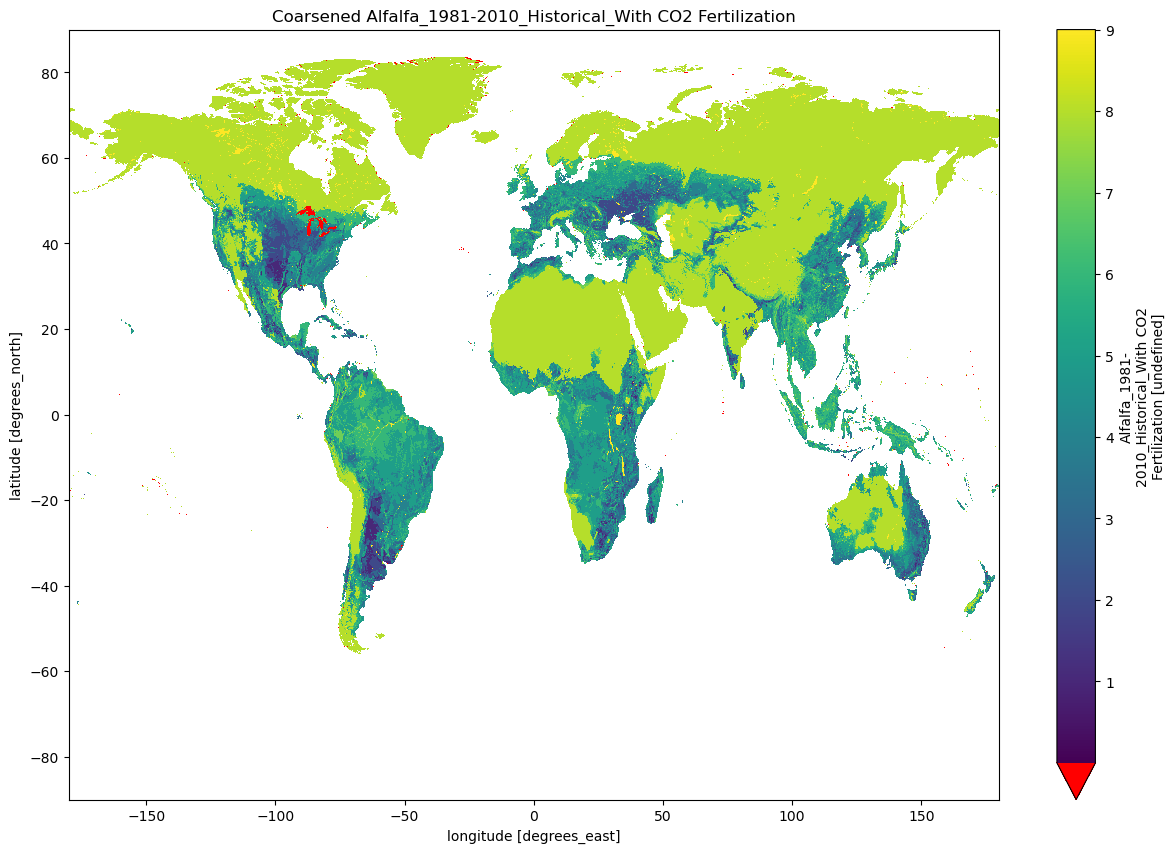

<xarray.Dataset> Size: 4GB
Dimensions:                                              (lon: 43200, lat: 21600)
Coordinates:
    band                                                 int32 4B ...
    spatial_ref                                          int32 4B ...
  * lon                                                  (lon) float64 346kB ...
  * lat                                                  (lat) float64 173kB ...
    time                                                 datetime64[ns] 8B ...
Data variables:
    Alfalfa_1981-2010_Historical_With CO2 Fertilization  (lat, lon) float32 4GB ...

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Get all netCDF files in OUT_DIR
files = list(OUT_DIR.glob('*.nc'))

# Plot first file as example
if files:
    ds = xr.open_dataset(files[0])
    
    plt.figure(figsize=(15,10))
    # Coarsen and plot first variable
    var_name = list(ds.data_vars)[0]
    data = ds[var_name].coarsen(lat=10, lon=10).mean()
    
    # Create custom colormap with red for zeros
    cmap = plt.cm.viridis.copy()
    cmap.set_bad('white')
    cmap.set_under('red')
    
    # Plot with custom colormap and vmin slightly above 0 to color zeros red
    data.plot(cmap=cmap, vmin=0.000001)
    plt.title(f'Coarsened {files[0].stem}')
    plt.show()
    ds.close()
ds

In [10]:
# Get first variable name
var_name = list(ds.data_vars)[0]

# Get data values 
data = ds[var_name].values

# Remove NaN values
non_nan_data = data[~np.isnan(data)].flatten()

# Get unique values and their frequencies
unique_vals, counts = np.unique(non_nan_data, return_counts=True)

# Print number of unique values
print(f"Number of unique values: {len(unique_vals)}")

# List the unique values and their frequencies
print("\nUnique values and frequencies:")
for val, count in zip(unique_vals, counts):
    print(f"Value: {val}, Frequency: {count}")

Number of unique values: 10

Unique values and frequencies:
Value: 0.0, Frequency: 778000
Value: 1.0, Frequency: 1353800
Value: 2.0, Frequency: 5696400
Value: 3.0, Frequency: 10036800
Value: 4.0, Frequency: 18515100
Value: 5.0, Frequency: 34616200
Value: 6.0, Frequency: 21855800
Value: 7.0, Frequency: 5184300
Value: 8.0, Frequency: 127504500
Value: 9.0, Frequency: 2042600


## 森林AGC+BGC潜力数据对齐

In [20]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc

def process_tif_to_netcdf(
    tif_path: Path,
    master_nc: str,
    out_dir: Path,
    var_name: str = None,
    chunksizes: tuple = (1000, 1000),
    compress_level: int = 5
):
    """
    将单波段 GeoTIFF 对齐到 master_nc 的投影/分辨率/网格，
    并输出到 out_dir/<tif_stem>.nc。

    参数
    ----
    tif_path : Path
        待处理的 GeoTIFF 文件路径（单波段）。
    master_nc : str
        模板 NetCDF 文件路径，包含 lat, lon, land_mask。
    out_dir : Path
        输出目录。
    var_name : str, optional
        变量名；若为 None，则取 tif 文件名（不含扩展）。
    chunksizes : tuple of int
        在 NetCDF 中的分块大小 (lat_chunks, lon_chunks)。
    compress_level : int
        zlib 压缩等级 (0-9)。
    """
    # 构造输出路径
    stem = tif_path.stem
    out_path = out_dir / f"{stem}.nc"
    if out_path.exists():
        print(f"Skip (exists): {out_path.name}")
        return

    # 读取 master
    ds_master = xr.open_dataset(master_nc)
    mask = ds_master["land_mask"]

    # 读取原 GeoTIFF，取第一个 band，并命名、维度匹配
    da = (
        rxr.open_rasterio(str(tif_path), masked=True)
           .isel(band=0)
    )

    # 一键重投影、重网格：对齐到 master（投影、分辨率、经纬度坐标）
    da_matched = da.rio.reproject_match(ds_master)
    da_matched = da_matched.rename({"x": "lon", "y": "lat"})

    # 应用掩膜
    da_masked = da_matched.where(mask)

    # 设定变量名
    name = var_name or stem
    da_masked.name = name

    # 转为 Dataset 并写出
    ds_out = da_masked.to_dataset()

    encoding = {
        name: {
            "zlib": True,
            "complevel": compress_level,
            "chunksizes": chunksizes,
            "_FillValue": np.nan
        }
    }

    print(f"Writing: {out_path.name} ...")
    ds_out.to_netcdf(str(out_path), encoding=encoding)
    ds_out.close()

    # 清理
    ds_master.close()
    gc.collect()

# ───────── 主流程 ─────────
if __name__ == "__main__":
    from tqdm import tqdm

    MASTER   = r"D:\xarray\aligned2\master_final.nc"
    SOC_DIR  = Path(r"D:\xarray\pre-process\Forest_carbon\Natural_climate_solutions")
    OUT_DIR  = Path(r"D:\xarray\aligned2\emission_potential")
    OUT_DIR.mkdir(exist_ok=True, parents=True)

    tif_files = list(SOC_DIR.glob("*.tif"))
    with tqdm(tif_files, desc="处理文件") as pbar:
        for tif in pbar:
            pbar.set_description(f"处理 {tif.name}")
            process_tif_to_netcdf(
                tif_path=tif,
                master_nc=MASTER,
                out_dir=OUT_DIR,
                var_name=None,           # 或者自定义每个文件的变量名
                chunksizes=(1000, 1000), # 根据内存调整
                compress_level=5
            )


处理 Base_Con_Unr_AGB_BGB_MgCha_500m.tif:   0%|          | 0/74 [00:00<?, ?it/s]

Writing: Base_Con_Unr_AGB_BGB_MgCha_500m.nc ...


处理 Base_Con_Unr_AGB_BGB_SOC_MgCha_500m.tif:   1%|▏         | 1/74 [05:08<6:15:56, 308.99s/it]

Writing: Base_Con_Unr_AGB_BGB_SOC_MgCha_500m.nc ...


处理 Base_Con_Unr_AGB_MgCha_500m.tif:   3%|▎         | 2/74 [10:22<6:14:12, 311.84s/it]        

Writing: Base_Con_Unr_AGB_MgCha_500m.nc ...


处理 Base_Con_Unr_BGB_MgCha_500m.tif:   4%|▍         | 3/74 [14:39<5:39:09, 286.61s/it]

Writing: Base_Con_Unr_BGB_MgCha_500m.nc ...


处理 Base_Con_Unr_SOC_MgCha_500m.tif:   5%|▌         | 4/74 [18:48<5:16:59, 271.71s/it]

Writing: Base_Con_Unr_SOC_MgCha_500m.nc ...


处理 RCP85y50bc_Pot_AGB_MgCha_500m.tif:   7%|▋         | 5/74 [22:35<4:54:03, 255.70s/it]  

Skip (exists): Base_Cur_AGB_BGB_MgCha_500m.nc
Skip (exists): Base_Cur_AGB_BGB_SOC_MgCha_500m.nc
Skip (exists): Base_Cur_AGB_MgCha_500m.nc
Skip (exists): Base_Cur_AGB_UI_500m.nc
Skip (exists): Base_Cur_BGB_MgCha_500m.nc
Skip (exists): Base_Cur_SOC_MgCha_500m.nc
Skip (exists): Base_Pot_AGB_BGB_MgCha_500m.nc
Skip (exists): Base_Pot_AGB_BGB_SOC_MgCha_500m.nc
Skip (exists): Base_Pot_AGB_MgCha_500m.nc
Skip (exists): Base_Pot_AGB_UI_500m.nc
Skip (exists): Base_Pot_BGB_MgCha_500m.nc
Skip (exists): Base_Pot_SOC_MgCha_500m.nc
Skip (exists): Base_Unr_AGB_BGB_MgCha_500m.nc
Skip (exists): Base_Unr_AGB_BGB_SOC_MgCha_500m.nc
Skip (exists): Base_Unr_AGB_MgCha_500m.nc
Skip (exists): Base_Unr_BGB_MgCha_500m.nc
Skip (exists): Base_Unr_SOC_MgCha_500m.nc
Skip (exists): Bioclimate_Zones_500m.nc
Skip (exists): NCS_Opportunity_Categories_500m.nc
Writing: RCP85y50bc_Pot_AGB_MgCha_500m.nc ...


处理 RCP85y50bc_Pot_BGB_MgCha_500m.tif:  34%|███▍      | 25/74 [27:02<28:23, 34.77s/it]  

Writing: RCP85y50bc_Pot_BGB_MgCha_500m.nc ...


处理 RCP85y50bc_Unr_AGB_MgCha_500m.tif:  35%|███▌      | 26/74 [31:09<38:14, 47.79s/it]

Writing: RCP85y50bc_Unr_AGB_MgCha_500m.nc ...


处理 RCP85y50bc_Unr_BGB_MgCha_500m.tif:  36%|███▋      | 27/74 [35:34<51:04, 65.20s/it]

Writing: RCP85y50bc_Unr_BGB_MgCha_500m.nc ...


处理 RCP85y50cc_Pot_AGB_MgCha_500m.tif:  38%|███▊      | 28/74 [39:58<1:05:38, 85.62s/it]

Writing: RCP85y50cc_Pot_AGB_MgCha_500m.nc ...


处理 RCP85y50cc_Pot_BGB_MgCha_500m.tif:  39%|███▉      | 29/74 [44:46<1:23:43, 111.63s/it]

Writing: RCP85y50cc_Pot_BGB_MgCha_500m.nc ...


处理 RCP85y50cc_Unr_AGB_MgCha_500m.tif:  41%|████      | 30/74 [51:05<1:52:13, 153.04s/it]

Writing: RCP85y50cc_Unr_AGB_MgCha_500m.nc ...


处理 RCP85y50cc_Unr_BGB_MgCha_500m.tif:  42%|████▏     | 31/74 [55:24<2:03:23, 172.18s/it]

Writing: RCP85y50cc_Unr_BGB_MgCha_500m.nc ...


处理 RCP85y50gs_Pot_AGB_MgCha_500m.tif:  43%|████▎     | 32/74 [1:00:20<2:18:20, 197.62s/it]

Writing: RCP85y50gs_Pot_AGB_MgCha_500m.nc ...


处理 RCP85y50gs_Pot_BGB_MgCha_500m.tif:  45%|████▍     | 33/74 [1:05:30<2:32:30, 223.18s/it]

Writing: RCP85y50gs_Pot_BGB_MgCha_500m.nc ...


处理 RCP85y50gs_Unr_AGB_MgCha_500m.tif:  46%|████▌     | 34/74 [1:10:23<2:40:05, 240.13s/it]

Writing: RCP85y50gs_Unr_AGB_MgCha_500m.nc ...


处理 RCP85y50gs_Unr_BGB_MgCha_500m.tif:  47%|████▋     | 35/74 [1:15:05<2:43:12, 251.10s/it]

Writing: RCP85y50gs_Unr_BGB_MgCha_500m.nc ...


处理 RCP85y50hd_Pot_AGB_MgCha_500m.tif:  49%|████▊     | 36/74 [1:19:02<2:36:32, 247.17s/it]

Writing: RCP85y50hd_Pot_AGB_MgCha_500m.nc ...


处理 RCP85y50hd_Pot_BGB_MgCha_500m.tif:  50%|█████     | 37/74 [1:22:55<2:30:05, 243.38s/it]

Writing: RCP85y50hd_Pot_BGB_MgCha_500m.nc ...


处理 RCP85y50hd_Unr_AGB_MgCha_500m.tif:  51%|█████▏    | 38/74 [1:26:37<2:22:18, 237.18s/it]

Writing: RCP85y50hd_Unr_AGB_MgCha_500m.nc ...


处理 RCP85y50hd_Unr_BGB_MgCha_500m.tif:  53%|█████▎    | 39/74 [1:30:25<2:16:51, 234.61s/it]

Writing: RCP85y50hd_Unr_BGB_MgCha_500m.nc ...


处理 RCP85y50he_Pot_AGB_MgCha_500m.tif:  54%|█████▍    | 40/74 [1:34:19<2:12:54, 234.53s/it]

Writing: RCP85y50he_Pot_AGB_MgCha_500m.nc ...


处理 RCP85y50he_Pot_BGB_MgCha_500m.tif:  55%|█████▌    | 41/74 [1:38:29<2:11:28, 239.04s/it]

Writing: RCP85y50he_Pot_BGB_MgCha_500m.nc ...


处理 RCP85y50he_Unr_AGB_MgCha_500m.tif:  57%|█████▋    | 42/74 [1:42:41<2:09:33, 242.91s/it]

Writing: RCP85y50he_Unr_AGB_MgCha_500m.nc ...


处理 RCP85y50he_Unr_BGB_MgCha_500m.tif:  58%|█████▊    | 43/74 [1:46:37<2:04:22, 240.71s/it]

Writing: RCP85y50he_Unr_BGB_MgCha_500m.nc ...


处理 RCP85y50ip_Pot_AGB_MgCha_500m.tif:  59%|█████▉    | 44/74 [1:50:43<2:01:06, 242.20s/it]

Writing: RCP85y50ip_Pot_AGB_MgCha_500m.nc ...


处理 RCP85y50ip_Pot_BGB_MgCha_500m.tif:  61%|██████    | 45/74 [1:54:57<1:58:45, 245.71s/it]

Writing: RCP85y50ip_Pot_BGB_MgCha_500m.nc ...


处理 RCP85y50ip_Unr_AGB_MgCha_500m.tif:  62%|██████▏   | 46/74 [1:59:12<1:56:00, 248.57s/it]

Writing: RCP85y50ip_Unr_AGB_MgCha_500m.nc ...


处理 RCP85y50ip_Unr_BGB_MgCha_500m.tif:  64%|██████▎   | 47/74 [2:03:09<1:50:18, 245.14s/it]

Writing: RCP85y50ip_Unr_BGB_MgCha_500m.nc ...


处理 RCP85y50mc_Pot_AGB_MgCha_500m.tif:  65%|██████▍   | 48/74 [2:06:57<1:43:58, 239.95s/it]

Writing: RCP85y50mc_Pot_AGB_MgCha_500m.nc ...


处理 RCP85y50mc_Pot_BGB_MgCha_500m.tif:  66%|██████▌   | 49/74 [2:10:49<1:38:58, 237.56s/it]

Writing: RCP85y50mc_Pot_BGB_MgCha_500m.nc ...


处理 RCP85y50mc_Unr_AGB_MgCha_500m.tif:  68%|██████▊   | 50/74 [2:14:49<1:35:24, 238.51s/it]

Writing: RCP85y50mc_Unr_AGB_MgCha_500m.nc ...


处理 RCP85y50mc_Unr_BGB_MgCha_500m.tif:  69%|██████▉   | 51/74 [2:18:40<1:30:30, 236.10s/it]

Writing: RCP85y50mc_Unr_BGB_MgCha_500m.nc ...


处理 RCP85y50mean_Pot_AGB_MgCha_500m.tif:  70%|███████   | 52/74 [2:22:26<1:25:26, 233.04s/it]

Writing: RCP85y50mean_Pot_AGB_MgCha_500m.nc ...


处理 RCP85y50mean_Pot_BGB_MgCha_500m.tif:  72%|███████▏  | 53/74 [2:26:15<1:21:11, 231.96s/it]

Writing: RCP85y50mean_Pot_BGB_MgCha_500m.nc ...


处理 RCP85y50mean_Unr_AGB_MgCha_500m.tif:  73%|███████▎  | 54/74 [2:29:58<1:16:21, 229.06s/it]

Writing: RCP85y50mean_Unr_AGB_MgCha_500m.nc ...


处理 RCP85y50mean_Unr_BGB_MgCha_500m.tif:  74%|███████▍  | 55/74 [2:34:00<1:13:49, 233.11s/it]

Writing: RCP85y50mean_Unr_BGB_MgCha_500m.nc ...


处理 RCP85y50mg_Pot_AGB_MgCha_500m.tif:  76%|███████▌  | 56/74 [2:37:53<1:09:54, 233.05s/it]  

Writing: RCP85y50mg_Pot_AGB_MgCha_500m.nc ...


处理 RCP85y50mg_Pot_BGB_MgCha_500m.tif:  77%|███████▋  | 57/74 [2:41:51<1:06:27, 234.54s/it]

Writing: RCP85y50mg_Pot_BGB_MgCha_500m.nc ...


处理 RCP85y50mg_Unr_AGB_MgCha_500m.tif:  78%|███████▊  | 58/74 [2:45:58<1:03:31, 238.24s/it]

Writing: RCP85y50mg_Unr_AGB_MgCha_500m.nc ...


处理 RCP85y50mg_Unr_BGB_MgCha_500m.tif:  80%|███████▉  | 59/74 [2:49:57<59:37, 238.49s/it]  

Writing: RCP85y50mg_Unr_BGB_MgCha_500m.nc ...


处理 RCP85y50mi_Pot_AGB_MgCha_500m.tif:  81%|████████  | 60/74 [2:53:42<54:41, 234.37s/it]

Writing: RCP85y50mi_Pot_AGB_MgCha_500m.nc ...


处理 RCP85y50mi_Pot_BGB_MgCha_500m.tif:  82%|████████▏ | 61/74 [2:57:46<51:26, 237.44s/it]

Writing: RCP85y50mi_Pot_BGB_MgCha_500m.nc ...


处理 RCP85y50mi_Unr_AGB_MgCha_500m.tif:  84%|████████▍ | 62/74 [3:01:33<46:52, 234.34s/it]

Writing: RCP85y50mi_Unr_AGB_MgCha_500m.nc ...


处理 RCP85y50mi_Unr_BGB_MgCha_500m.tif:  85%|████████▌ | 63/74 [3:05:23<42:41, 232.87s/it]

Writing: RCP85y50mi_Unr_BGB_MgCha_500m.nc ...


处理 RCP85y50mr_Pot_AGB_MgCha_500m.tif:  86%|████████▋ | 64/74 [3:09:11<38:35, 231.53s/it]

Writing: RCP85y50mr_Pot_AGB_MgCha_500m.nc ...


处理 RCP85y50mr_Pot_BGB_MgCha_500m.tif:  88%|████████▊ | 65/74 [3:12:45<33:56, 226.26s/it]

Writing: RCP85y50mr_Pot_BGB_MgCha_500m.nc ...


处理 RCP85y50mr_Unr_AGB_MgCha_500m.tif:  89%|████████▉ | 66/74 [3:16:39<30:28, 228.57s/it]

Writing: RCP85y50mr_Unr_AGB_MgCha_500m.nc ...


处理 RCP85y50mr_Unr_BGB_MgCha_500m.tif:  91%|█████████ | 67/74 [3:21:05<27:57, 239.70s/it]

Writing: RCP85y50mr_Unr_BGB_MgCha_500m.nc ...


处理 RCP85y50no_Pot_AGB_MgCha_500m.tif:  92%|█████████▏| 68/74 [3:25:20<24:25, 244.17s/it]

Writing: RCP85y50no_Pot_AGB_MgCha_500m.nc ...


处理 RCP85y50no_Pot_BGB_MgCha_500m.tif:  93%|█████████▎| 69/74 [3:29:15<20:08, 241.65s/it]

Writing: RCP85y50no_Pot_BGB_MgCha_500m.nc ...


处理 RCP85y50no_Unr_AGB_MgCha_500m.tif:  95%|█████████▍| 70/74 [3:33:16<16:05, 241.30s/it]

Writing: RCP85y50no_Unr_AGB_MgCha_500m.nc ...


处理 RCP85y50no_Unr_BGB_MgCha_500m.tif:  96%|█████████▌| 71/74 [3:37:21<12:07, 242.44s/it]

Writing: RCP85y50no_Unr_BGB_MgCha_500m.nc ...


处理 Root2Shoot_Ratios_Scaled1e3_500m.tif:  97%|█████████▋| 72/74 [3:41:31<08:09, 244.77s/it]

Writing: Root2Shoot_Ratios_Scaled1e3_500m.nc ...


处理 Societal_Constraints_500m.tif:  99%|█████████▊| 73/74 [3:44:44<03:49, 229.27s/it]       

Writing: Societal_Constraints_500m.nc ...


处理 Societal_Constraints_500m.tif: 100%|██████████| 74/74 [3:47:24<00:00, 184.38s/it]


In [2]:
import rasterio
from pathlib import Path

# Print information about all TIF files in the given directory
def print_tif_info(path):
    tif_files = list(path.glob("*.tif"))
    print(f"\nFound {len(tif_files)} TIF files in {path}:")
    for tif in tif_files:
        with rasterio.open(tif) as src:
            print(f"\nFile: {tif.name}")
            print(f"Size: {src.width} x {src.height}")
            print(f"CRS: {src.crs}")
            print(f"Bounds: {src.bounds}")
            print(f"Data type: {src.dtypes[0]}")
            print(f"Number of bands: {src.count}")

SOC_DIR = Path(r"D:\xarray\aligned2\emission\Potential_source")
print_tif_info(SOC_DIR)



Found 18 TIF files in D:\xarray\aligned2\emission\Potential_source:

File: Base_Cur_AGB_BGB_MgCha_500m.tif
Size: 86400 x 36000
CRS: PROJCS["Sinusoidal",GEOGCS["GCS_unnamed ellipse",DATUM["unknown",SPHEROID["Unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Bounds: BoundingBox(left=-20015109.354, bottom=-6671703.117900055, right=20015109.353760134, top=10007554.677)
Data type: int16
Number of bands: 1

File: Base_Cur_AGB_BGB_SOC_MgCha_500m.tif
Size: 86400 x 36000
CRS: PROJCS["Sinusoidal",GEOGCS["GCS_unnamed ellipse",DATUM["unknown",SPHEROID["Unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_eastin

## 根茎数据对齐

In [19]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from collections import defaultdict
import rioxarray as rxr




def process_tif_to_netcdf(
    tif_path: Path,
    master_nc: str,
    out_dir: Path,
    var_name: str = None,
    chunksizes: tuple = (1000, 1000),
    compress_level: int = 5
):
    """
    将单波段 GeoTIFF 对齐到 master_nc 的投影/分辨率/网格，
    并输出到 out_dir/<tif_stem>.nc。

    参数
    ----
    tif_path : Path
        待处理的 GeoTIFF 文件路径（单波段）。
    master_nc : str
        模板 NetCDF 文件路径，包含 lat, lon, land_mask。
    out_dir : Path
        输出目录。
    var_name : str, optional
        变量名；若为 None，则取 tif 文件名（不含扩展）。
    chunksizes : tuple of int
        在 NetCDF 中的分块大小 (lat_chunks, lon_chunks)。
    compress_level : int
        zlib 压缩等级 (0-9)。
    """
    # 构造输出路径
    stem = tif_path.stem
    out_path = out_dir / f"{stem}.nc"
    if out_path.exists():
        print(f"Skip (exists): {out_path.name}")
        return

    # 读取 master
    ds_master = xr.open_dataset(master_nc)
    mask = ds_master["land_mask"]

    # 读取原 GeoTIFF，取第一个 band，并命名、维度匹配
    da = (
        rxr.open_rasterio(str(tif_path), masked=True)
           .isel(band=0)
    )

    # 一键重投影、重网格：对齐到 master（投影、分辨率、经纬度坐标）
    da_matched = da.rio.reproject_match(ds_master)
    da_matched = da_matched.rename({"x": "lon", "y": "lat"})

    # 应用掩膜
    da_masked = da_matched.where(mask)

    # 设定变量名
    name = var_name or stem
    da_masked.name = name

    if '_FillValue' in da_masked.attrs:
        del da_masked.attrs['_FillValue']

    # 转为 Dataset 并写出
    ds_out = da_masked.to_dataset()

    encoding = {
        name: {
            "zlib": True,
            "complevel": compress_level,
            "chunksizes": chunksizes,
            "_FillValue": np.nan
        }
    }

    print(f"Writing: {out_path.name} ...")
    ds_out.to_netcdf(str(out_path), encoding=encoding)
    ds_out.close()

    # 清理
    ds_master.close()
    gc.collect()

    
def mosaic_tifs_by_prefix(src_dir: Path, out_dir: Path, prefixes: list):
    """
    对指定前缀的tif文件进行mosaic，输出到out_dir，返回mosaic后的tif路径列表
    """
    import rasterio
    from rasterio.merge import merge
    out_dir.mkdir(exist_ok=True, parents=True)
    mosaiced_files = []
    for prefix in prefixes:
        tifs = sorted(src_dir.glob(f"{prefix}*.tif"))
        if len(tifs) < 2:
            print(f"Prefix {prefix}: 找到的tif文件不足2个，跳过")
            continue
        out_path = out_dir / f"{prefix}_mosaic.tif"
        if out_path.exists():
            print(f"Skip (exists): {out_path.name}")
            mosaiced_files.append(out_path)
            continue
        # 用 rasterio 打开所有tif
        src_files_to_mosaic = [rasterio.open(str(tif)) for tif in tifs]
        mosaic_arr, out_trans = merge(src_files_to_mosaic)
        out_meta = src_files_to_mosaic[0].meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": mosaic_arr.shape[1],
            "width": mosaic_arr.shape[2],
            "transform": out_trans,
            "count": mosaic_arr.shape[0]
        })
        # out_path = out_dir / f"{prefix}_mosaic.tif"
        with rasterio.open(str(out_path), "w", **out_meta) as dest:
            dest.write(mosaic_arr)
        for src in src_files_to_mosaic:
            src.close()
        mosaiced_files.append(out_path)
        print(f"Mosaic完成: {out_path}")
    return mosaiced_files

# ───────── 主流程 ─────────
if __name__ == "__main__":
    from tqdm import tqdm

    MASTER   = r"D:\xarray\aligned2\master_final.nc"
    SOC_DIR  = Path(r"D:\xarray\aligned2\emission\RMF_source")
    MOSAIC_DIR = Path(r"D:\xarray\aligned2\emission\RMF_mosaic")
    OUT_DIR  = Path(r"D:\xarray\aligned2\RMF")
    OUT_DIR.mkdir(exist_ok=True, parents=True)

    # 1. 先mosaic
    prefixes = ["forest_rmf", "grass_rmf", "shrub_rmf", "rmf_all"]
    mosaiced_tifs = mosaic_tifs_by_prefix(SOC_DIR, MOSAIC_DIR, prefixes)

    # 2. 再转netcdf
    with tqdm(mosaiced_tifs, desc="处理mosaic文件") as pbar:
        for tif in pbar:
            pbar.set_description(f"处理 {tif.name}")
            process_tif_to_netcdf(
                tif_path=tif,
                master_nc=MASTER,
                out_dir=OUT_DIR,
                var_name=None,
                chunksizes=(1000, 1000),
                compress_level=5
            )


Skip (exists): forest_rmf_mosaic.tif
Skip (exists): grass_rmf_mosaic.tif
Skip (exists): shrub_rmf_mosaic.tif
Skip (exists): rmf_all_mosaic.tif


处理 forest_rmf_mosaic.tif:   0%|          | 0/4 [00:00<?, ?it/s]

Writing: forest_rmf_mosaic.nc ...


处理 rmf_all_mosaic.tif: 100%|██████████| 4/4 [01:54<00:00, 28.74s/it]    

Skip (exists): grass_rmf_mosaic.nc
Skip (exists): shrub_rmf_mosaic.nc
Skip (exists): rmf_all_mosaic.nc


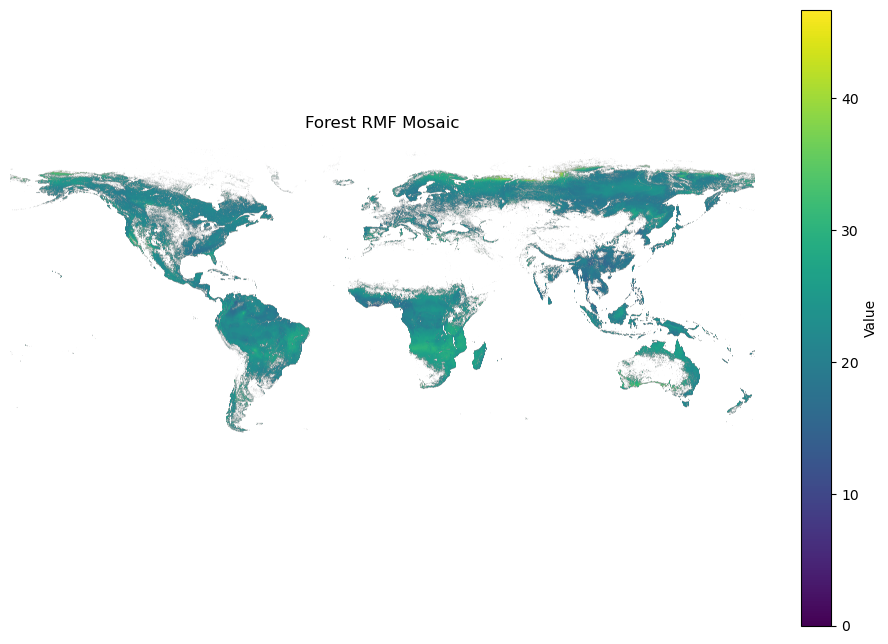

In [16]:
# Read and plot the forest RMF mosaic TIF file
import rasterio
import matplotlib.pyplot as plt

# Open the TIF file
tif_path = r"D:\xarray\aligned2\emission\RMF_mosaic\forest_rmf_mosaic.tif"
with rasterio.open(tif_path) as src:
    data = src.read(1)  # Read first band
    
# Create figure and plot
plt.figure(figsize=(12,8))
plt.imshow(data, cmap='viridis')
plt.colorbar(label='Value')
plt.title('Forest RMF Mosaic')
plt.axis('off')
plt.show()

# 成本产量Potential处理

## 潜在产能数据处理

In [12]:
import pandas as pd
import requests
from pathlib import Path
import os
from urllib.parse import urlparse
import re

def download_gaez4_crop_data():
    """
    Download GAEZ4 crop data based on specific criteria from CSV file
    """
    # Read the CSV file
    # csv_path = r'D:\xarray\aligned2\economic_cost\GAEZ_croppotential_source\Agro-climatic Potential Yield_RCP2.6.csv'
    csv_paths = [
        r'D:\xarray\aligned2\economic_cost\GAEZ_croppotential_source\Agro-climatic Potential Yield_RCP2.6.csv',
        r'D:\xarray\aligned2\economic_cost\GAEZ_croppotential_source\Agro-climatic Potential Yield_RCP4.5.csv',
        r'D:\xarray\aligned2\economic_cost\GAEZ_croppotential_source\Agro-climatic Potential Yield_RCP8.5.csv', 
        r'D:\xarray\aligned2\economic_cost\GAEZ_croppotential_source\Agro-climatic Potential Yield_RCP6.0.csv'
    ]

    df_list = []
    for csv_path in csv_paths:
        df = pd.read_csv(csv_path)
        df_list.append(df)
    df = pd.concat(df_list)
    
    # Define target crops and time periods
 
    target_periods = ['2011-2040']
    
    # Filter the dataframe based on criteria
    filtered_df = df[
        (df['Time Period'].isin(target_periods))
    ]
    
    # Create output directory
    output_dir = Path(r'D:\xarray\aligned2\economic_cost\GAEZ_croppotential_source')
    output_dir.mkdir(exist_ok=True, parents=True)
    
    print(f"Found {len(filtered_df)} files to download")
    
    # Download each file
    for index, row in filtered_df.iterrows():
        crop = row['Crop']
        time_period = row['Time Period']
        rcp = row['RCP']
        model=row['Climate Model']
        unit=row['Data  Units']
        water_supply=row['Water Supply']
        download_url = row['Download URL']
        
        # Create filename
        filename = f"{crop}_{rcp}_{model}_{unit}_{water_supply}.tif"
        filename = re.sub(r'[\\/:"*?<>|]+', '_', filename)
        filepath = output_dir / filename
        
        # Skip if file already exists
        if filepath.exists():
            print(f"File already exists, skipping: {filename}")
            continue
        
        try:
            print(f"Downloading: {filename}")
            print(f"URL: {download_url}")
            
            # Download the file
            response = requests.get(download_url, stream=True)
            response.raise_for_status()
            
            # Save the file
            with open(filepath, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            
            print(f"Successfully downloaded: {filename}")
            
        except Exception as e:
            print(f"Error downloading {filename}: {str(e)}")
            continue
    
    print("Download process completed!")

# Execute the function
if __name__ == "__main__":
    download_gaez4_crop_data()

Found 3080 files to download
Downloading: Alfalfa_RCP2.6_NorESM1-M_10kg DW_ha_Available water content of 200 mm_m (under irrigation conditions).tif
URL:  https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res02/NorESM1-M/rcp2p6/2020sH/alfa200a_yld.tif
Successfully downloaded: Alfalfa_RCP2.6_NorESM1-M_10kg DW_ha_Available water content of 200 mm_m (under irrigation conditions).tif
Downloading: Alfalfa_RCP2.6_NorESM1-M_10kg DW_ha_Available water content of 200 mm_m (under rain-fed conditions).tif
URL:  https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res02/NorESM1-M/rcp2p6/2020sH/alfa200b_yld.tif
Successfully downloaded: Alfalfa_RCP2.6_NorESM1-M_10kg DW_ha_Available water content of 200 mm_m (under rain-fed conditions).tif
Downloading: Banana_RCP2.6_NorESM1-M_kg DW_ha_Available water content of 200 mm_m (under irrigation conditions).tif
URL:  https://s3.eu-west-1.amazonaws.com/data.gaezdev.aws.fao.org/res02/NorESM1-M/rcp2p6/2020sH/bana200a_yld.tif
Successfully downloa

In [18]:
import pandas as pd
import os
import glob
import re
import pandas as pd
import numpy as np
import xarray as xr
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import re
import requests
import gc
import tqdm
df=pd.read_csv(r'data\4.1_prediction_net_weighted.csv')
tif_path="D:/xarray/aligned2/economic_cost/GAEZ_croppotential_source/Alfalfa_RCP2.6_NorESM1-M_10kg DW_ha_Available water content of 200 mm_m (under irrigation conditions).tif"

# Load and print metadata of the TIFF file
with rasterio.open(tif_path) as src:
    print("\nTIFF Metadata:")
    print("-" * 50)
    print(f"Driver: {src.driver}")
    print(f"Width: {src.width}")
    print(f"Height: {src.height}") 
    print(f"Number of bands: {src.count}")
    print(f"Coordinate Reference System: {src.crs}")
    print(f"Transform: {src.transform}")
    print(f"Bounds: {src.bounds}")
    print(f"Nodata value: {src.nodata}")
    print(f"Data type: {src.dtypes[0]}")


    # 提取经度23度,纬度46度的数据
    lon, lat = 23, 46
    row, col = src.index(lon, lat)  # 将地理坐标转换为像素索引
    value = src.read(1)[row, col]  # 从第一个波段读取值
    
    print(f"\n经度{lon}度,纬度{lat}度的值:")
    print(f"值: {value}")



def parse_gaez_tifs(tif_dir):
    """
    Parse GAEZ crop potential TIF files to extract metadata.
    Only includes files containing 'NorESM' and 'irrigation' in filename.
    
    Args:
        tif_dir (str): Directory containing GAEZ TIF files
        
    Returns:
        pd.DataFrame: DataFrame with columns for crop_name, RCP_value, and tif_path
    """
    # Get all tif files in directory
    tif_files = glob.glob(os.path.join(tif_dir, "*.tif"))

    # Create empty lists to store data
    crop_names = []
    rcps = []
    paths = []
    units = []

    # Parse filenames to extract crop name and RCP
    for tif_file in tif_files:
        filename = os.path.basename(tif_file)
        
        # Only process files containing NorESM and irrigation
        if 'NorESM' not in filename or 'irrigation' not in filename:
            continue
            
        # Extract crop name (everything before first _RCP)
        crop_name = filename.split("_RCP")[0]
        
        # Extract RCP value (between _RCP and _)
        rcp_match = re.search(r"_RCP(\d+\.\d+)_", filename)
        rcp = rcp_match.group(1) if rcp_match else None

        # Extract unit (10kg DW_ha or kg DW_ha)
        unit_match = re.search(r'_(10kg DW_ha|kg DW_ha)', filename)
        unit = unit_match.group(1) if unit_match else None
        
        crop_names.append(crop_name)
        rcps.append(rcp)
        paths.append(tif_file)
        units.append(unit)

    # Create dataframe
    df_tifs = pd.DataFrame({
        'crop_name': crop_names,
        'RCP_value': rcps,
        'unit': units,
        'tif_path': paths
    })
    df_tifs = df_tifs[df_tifs['RCP_value'].isin(['2.6', '4.5', '6.0', '8.5'])]
        
    df_tifs['Crop_RCP'] = df_tifs['crop_name'] + '_' + df_tifs['RCP_value'] + '_' + df_tifs['unit']
    
    return df_tifs[['Crop_RCP', 'tif_path']]




# Test the function
df_tifs = parse_gaez_tifs(tif_dir=r"D:\xarray\aligned2\economic_cost\GAEZ_croppotential_source")
# Filter for specific RCP values



TIFF Metadata:
--------------------------------------------------
Driver: GTiff
Width: 4320
Height: 2160
Number of bands: 1
Coordinate Reference System: EPSG:4326
Transform: | 0.08, 0.00,-180.00|
| 0.00,-0.08, 90.00|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
Nodata value: -9.0
Data type: int16

经度23度,纬度46度的值:
值: 1836


In [20]:
df_tifs

,Crop_RCP,tif_path
0,Alfalfa_2.6_10kg DW_ha,D:\xarray\aligned2\economic_cost\GAEZ_croppote...
1,Alfalfa_4.5_10kg DW_ha,D:\xarray\aligned2\economic_cost\GAEZ_croppote...
2,Alfalfa_6.0_10kg DW_ha,D:\xarray\aligned2\economic_cost\GAEZ_croppote...
3,Alfalfa_8.5_10kg DW_ha,D:\xarray\aligned2\economic_cost\GAEZ_croppote...
4,Banana_2.6_kg DW_ha,D:\xarray\aligned2\economic_cost\GAEZ_croppote...
...,...,...
303,Yam_8.5_kg DW_ha,D:\xarray\aligned2\economic_cost\GAEZ_croppote...
304,Yellow yam_2.6_kg DW_ha,D:\xarray\aligned2\economic_cost\GAEZ_croppote...
305,Yellow yam_4.5_kg DW_ha,D:\xarray\aligned2\economic_cost\GAEZ_croppote...
306,Yellow yam_6.0_kg DW_ha,D:\xarray\aligned2\economic_cost\GAEZ_croppote...


In [21]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
from tqdm.auto import tqdm

# 准备坐标对列表并转换为numpy数组
coords = list(zip(df['lon'], df['lat']))
coords_array = np.array(coords)

def process_tif_vectorized(row_data):
    """使用向量化操作处理单个TIFF文件"""
    crop_rcp, tif_path = row_data
    try:
        with rasterio.open(tif_path) as src:
            # 向量化转换坐标到像素索引
            rows, cols = rasterio.transform.rowcol(src.transform, 
                                                  coords_array[:, 0], 
                                                  coords_array[:, 1])
            
            # 确保rows和cols是numpy数组
            rows = np.array(rows)
            cols = np.array(cols)
            
            # 读取整个数据数组
            data = src.read(1)
            
            # 创建有效索引的掩码
            valid_mask = ((rows >= 0) & (rows < data.shape[0]) & 
                         (cols >= 0) & (cols < data.shape[1]))
            
            # 初始化结果数组为NaN
            values = np.full(len(coords), np.nan, dtype=np.float64)
            
            # 向量化索引：只对有效坐标进行索引
            if np.any(valid_mask):
                valid_rows = rows[valid_mask].astype(int)
                valid_cols = cols[valid_mask].astype(int)
                values[valid_mask] = data[valid_rows, valid_cols]
            
            return crop_rcp, values
            
    except Exception as e:
        print(f"Error processing {crop_rcp}: {e}")
        return crop_rcp, np.full(len(coords), np.nan, dtype=np.float64)

# 并行处理所有TIFF文件
with ThreadPoolExecutor(max_workers=4) as executor:
    # 提交所有任务
    futures = []
    for idx, row in df_tifs.iterrows():
        future = executor.submit(process_tif_vectorized, (row['Crop_RCP'], row['tif_path']))
        futures.append(future)
    
    # 收集结果并添加到DataFrame
    for future in tqdm(futures, desc="Processing TIFF files with vectorization"):
        crop_rcp, values = future.result()
        df[crop_rcp] = values

print(f"Successfully added {len(df_tifs)} crop production columns to DataFrame using vectorized operations")

# 显示结果概览
print(f"DataFrame shape: {df.shape}")
print(f"New columns added: {[col for col in df.columns if col in df_tifs['Crop_RCP'].values]}") 

Processing TIFF files with vectorization:   0%|          | 0/308 [00:00<?, ?it/s]

C:\Users\zpy10\AppData\Local\Temp\ipykernel_49732\1623509559.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[crop_rcp] = values
C:\Users\zpy10\AppData\Local\Temp\ipykernel_49732\1623509559.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[crop_rcp] = values
C:\Users\zpy10\AppData\Local\Temp\ipykernel_49732\1623509559.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

Successfully added 308 crop production columns to DataFrame using vectorized operations
DataFrame shape: (70312, 331)
New columns added: ['Alfalfa_2.6_10kg DW_ha', 'Alfalfa_4.5_10kg DW_ha', 'Alfalfa_6.0_10kg DW_ha', 'Alfalfa_8.5_10kg DW_ha', 'Banana_2.6_kg DW_ha', 'Banana_4.5_kg DW_ha', 'Banana_6.0_kg DW_ha', 'Banana_8.5_kg DW_ha', 'Barley_2.6_kg DW_ha', 'Barley_4.5_kg DW_ha', 'Barley_6.0_kg DW_ha', 'Barley_8.5_kg DW_ha', 'Biomass highland sorghum_2.6_kg DW_ha', 'Biomass highland sorghum_4.5_kg DW_ha', 'Biomass highland sorghum_6.0_kg DW_ha', 'Biomass highland sorghum_8.5_kg DW_ha', 'Biomass lowland sorghum_2.6_kg DW_ha', 'Biomass lowland sorghum_4.5_kg DW_ha', 'Biomass lowland sorghum_6.0_kg DW_ha', 'Biomass lowland sorghum_8.5_kg DW_ha', 'Biomass sorghum_2.6_kg DW_ha', 'Biomass sorghum_4.5_kg DW_ha', 'Biomass sorghum_6.0_kg DW_ha', 'Biomass sorghum_8.5_kg DW_ha', 'Biomass temperate sorghum_2.6_kg DW_ha', 'Biomass temperate sorghum_4.5_kg DW_ha', 'Biomass temperate sorghum_6.0_kg DW_h

C:\Users\zpy10\AppData\Local\Temp\ipykernel_49732\1623509559.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[crop_rcp] = values
C:\Users\zpy10\AppData\Local\Temp\ipykernel_49732\1623509559.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[crop_rcp] = values
C:\Users\zpy10\AppData\Local\Temp\ipykernel_49732\1623509559.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.c

In [24]:
df.to_csv(r'data\5.1_prediction_production_with_gaez.csv', index=False)

In [23]:
df

,Unnamed: 0.1,Unnamed: 0,time,lat,lon,abandonment_year,abandonment_duration,current_abandonment,landcover,DEM,...,Winter wheat_6.0_kg DW_ha,Winter wheat_8.5_kg DW_ha,Yam_2.6_kg DW_ha,Yam_4.5_kg DW_ha,Yam_6.0_kg DW_ha,Yam_8.5_kg DW_ha,Yellow yam_2.6_kg DW_ha,Yellow yam_4.5_kg DW_ha,Yellow yam_6.0_kg DW_ha,Yellow yam_8.5_kg DW_ha
0,0,2094,2020-01-01,25.004168,-107.545830,2018.0,6.0,1,2.0,128.7500,...,4756.0,4715.0,10201.0,10127.0,10126.0,10196.0,10201.0,10127.0,10126.0,10196.0
1,1,4586,2020-01-01,25.012500,-107.612500,2017.0,7.0,1,2.0,96.3125,...,3685.0,3668.0,9972.0,10041.0,9899.0,10090.0,9972.0,10041.0,9899.0,10090.0
2,2,4601,2020-01-01,25.012500,-107.487500,2017.0,7.0,1,2.0,176.3750,...,4634.0,3785.0,10110.0,10034.0,10029.0,10106.0,10110.0,10034.0,10029.0,10106.0
3,3,9586,2020-01-01,25.029167,-107.612500,2017.0,7.0,1,2.0,77.1250,...,3685.0,3668.0,9972.0,10041.0,9899.0,10090.0,9972.0,10041.0,9899.0,10090.0
4,4,9850,2020-01-01,25.029167,-105.412500,2017.0,7.0,1,2.0,1730.6250,...,7944.0,7976.0,8149.0,8126.0,8160.0,8382.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70307,70307,20522499,2020-01-01,48.187500,-65.837500,1998.0,26.0,1,3.0,46.5000,...,7955.0,7721.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70308,70308,20625641,2020-01-01,48.579166,-67.987500,1998.0,26.0,1,2.0,228.4375,...,6961.0,7289.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70309,70309,20669107,2020-01-01,48.745834,-72.437500,2012.0,12.0,1,2.0,105.2500,...,8004.0,7860.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70310,70310,20673507,2020-01-01,48.762500,-72.437500,2009.0,15.0,1,2.0,106.8125,...,8009.0,7864.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 森林成本数据校核

In [5]:
from pathlib import Path
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc
from tqdm.auto import tqdm

def process_multiband_tif_to_netcdf(
    tif_path: Path,
    master_nc: str,
    out_dir: Path,
    band_names: dict = None,
    chunksizes: tuple = (1000, 1000),
    compress_level: int = 5
):
    """
    将多波段 GeoTIFF 对齐到 master_nc 并输出为 NetCDF。
    """
    stem = tif_path.stem
    out_path = out_dir / f"{stem}.nc"
    if out_path.exists():
        print(f"Skip (exists): {out_path.name}")
        return

    # 读取数据
    ds_master = xr.open_dataset(master_nc)
    mask = ds_master["land_mask"]
    da_all_bands = rxr.open_rasterio(str(tif_path), masked=True)
    
    print(f"Processing {tif_path.name}: {da_all_bands.sizes['band']} bands")
    
    ds_out = xr.Dataset()
    
    # 处理每个波段
    for band_idx in range(1, da_all_bands.sizes['band'] + 1):
        da_band = da_all_bands.isel(band=band_idx - 1)
        da_matched = da_band.rio.reproject_match(ds_master)
        da_matched = da_matched.rename({"x": "lon", "y": "lat"})
        da_masked = da_matched.where(mask)
        
        var_name = band_names.get(band_idx, f"band_{band_idx}") if band_names else f"band_{band_idx}"
        da_masked.name = var_name
        ds_out[var_name] = da_masked
        print(f"  Band {band_idx} -> {var_name}")

    # 编码并保存
    encoding = {var: {"zlib": True, "complevel": compress_level, 
                      "chunksizes": chunksizes, "_FillValue": np.nan} 
                for var in ds_out.data_vars}
    
    print(f"Writing: {out_path.name} ...")
    ds_out.to_netcdf(str(out_path), encoding=encoding)
    ds_out.close()
    ds_master.close()
    gc.collect()

def process_tif_to_netcdf(tif_path: Path, master_nc: str, out_dir: Path, 
                         var_name: str = None, chunksizes: tuple = (1000, 1000), 
                         compress_level: int = 5):
    """单波段 GeoTIFF 处理（向后兼容）"""
    stem = tif_path.stem
    out_path = out_dir / f"{stem}.nc"
    if out_path.exists():
        print(f"Skip (exists): {out_path.name}")
        return

    ds_master = xr.open_dataset(master_nc)
    mask = ds_master["land_mask"]
    da = rxr.open_rasterio(str(tif_path), masked=True).isel(band=0)
    da_matched = da.rio.reproject_match(ds_master)
    da_matched = da_matched.rename({"x": "lon", "y": "lat"})
    da_masked = da_matched.where(mask)
    
    name = var_name or stem
    da_masked.name = name
    ds_out = da_masked.to_dataset()
    
    encoding = {name: {"zlib": True, "complevel": compress_level, 
                       "chunksizes": chunksizes, "_FillValue": np.nan}}
    
    print(f"Writing: {out_path.name} ...")
    ds_out.to_netcdf(str(out_path), encoding=encoding)
    ds_out.close()
    ds_master.close()
    gc.collect()

def inspect_netcdf_output(file_path: Path, file_type: str = "auto"):
    """通用NetCDF文件检查函数"""
    if not file_path.exists():
        print(f"❌ Output file not found: {file_path}")
        return
    
    print(f"🔍 Inspecting: {file_path.name}")
    ds = xr.open_dataset(file_path)
    
    print(f"\n📊 Dataset Info:")
    print(f"Variables: {list(ds.data_vars)}")
    print(f"Dimensions: {dict(ds.dims)}")
    
    # 根据文件类型提供专门的统计
    if "costEffectiveness" in file_path.name or file_type == "cost_effectiveness":
        print(f"\n💰 Cost-Effectiveness Statistics:")
        
        if "nr_wohrv_costeff" in ds.data_vars:
            data = ds["nr_wohrv_costeff"].where(~np.isnan(ds["nr_wohrv_costeff"]))
            print(f"\n🌱 Natural Regeneration (2020 USD/tCO2):")
            print(f"  Range: ${data.min().values:.2f} - ${data.max().values:.2f}")
            print(f"  Mean: ${data.mean().values:.2f}, Valid: {data.count().values:,}")
        
        if "pl_whrv_costeff" in ds.data_vars:
            data = ds["pl_whrv_costeff"].where(~np.isnan(ds["pl_whrv_costeff"]))
            profitable = data.where(data < 0)
            print(f"\n🌲 Plantation (2020 USD/tCO2):")
            print(f"  Range: ${data.min().values:.2f} - ${data.max().values:.2f}")
            print(f"  Mean: ${data.mean().values:.2f}, Valid: {data.count().values:,}")
            print(f"  Profitable areas: {profitable.count().values:,}")
        
        if "rel_costeff_2col" in ds.data_vars:
            data = ds["rel_costeff_2col"].where(~np.isnan(ds["rel_costeff_2col"]))
            nr_better = data.where(data == 1).count().values
            pl_better = data.where(data == 0).count().values
            total = data.count().values
            print(f"\n🔄 Relative Preference:")
            print(f"  Natural regeneration: {nr_better:,} ({nr_better/total*100:.1f}%)")
            print(f"  Plantation: {pl_better:,} ({pl_better/total*100:.1f}%)")
    
    elif "implementation_cost" in file_path.name or file_type == "implementation_cost":
        print(f"\n💰 Implementation Cost Statistics (2020 USD/ha):")
        descriptions = {"natRegen": "Natural regeneration", "native": "Native species", "exotic": "Exotic species"}
        
        for var_name in ds.data_vars:
            data = ds[var_name].where(~np.isnan(ds[var_name]))
            desc = descriptions.get(var_name, var_name)
            print(f"\n{desc}:")
            print(f"  Range: ${data.min().values:.2f} - ${data.max().values:.2f}/ha")
            print(f"  Mean: ${data.mean().values:.2f}/ha, Valid: {data.count().values:,}")
    
    else:
        # 通用统计
        print(f"\n📈 General Statistics:")
        for var_name in ds.data_vars:
            data = ds[var_name].where(~np.isnan(ds[var_name]))
            print(f"\n{var_name}:")
            print(f"  Range: {data.min().values:.2f} - {data.max().values:.2f}")
            print(f"  Mean: {data.mean().values:.2f}, Valid: {data.count().values:,}")
    
    ds.close()
    print("\n✅ Inspection completed!")

# 主流程
if __name__ == "__main__":
    MASTER = r"D:\xarray\aligned2\master_final.nc"
    BASE_DIR = Path(r"D:\xarray\aligned2\economic_cost\afforestation_cost")
    BASE_DIR.mkdir(exist_ok=True, parents=True)
    
    # 定义文件配置
    files_config = {
        "07_costEffectiveness.tif": {
            1: "nr_wohrv_costeff",    # Natural regeneration cost-effectiveness (2020 USD/tCO2)
            2: "pl_whrv_costeff",     # Plantation cost-effectiveness (2020 USD/tCO2, negative=profitable)
            3: "rel_costeff_2col"     # Binary: 1=natural regeneration better, 0=plantation better
        },
        "03_implementation_cost.tif": {
            1: "natRegen",    # Natural regeneration costs (2020 USD/ha)
            2: "native",      # Native tree species costs (2020 USD/ha)
            3: "exotic"       # Exotic tree species costs (2020 USD/ha)
        }
    }
    
    # 处理文件
    for filename, band_names in files_config.items():
        tif_file = BASE_DIR / filename
        if tif_file.exists():
            print(f"\n{'='*50}")
            print(f"Processing {filename}")
            print(f"{'='*50}")
            
            process_multiband_tif_to_netcdf(
                tif_path=tif_file,
                master_nc=MASTER,
                out_dir=BASE_DIR,
                band_names=band_names,
                chunksizes=(1000, 1000),
                compress_level=5
            )
            
            # 自动检查输出
            output_file = BASE_DIR / f"{tif_file.stem}.nc"
            if output_file.exists():
                print(f"\n🔍 Auto-inspecting output...")
                file_type = "cost_effectiveness" if "costEffectiveness" in filename else "implementation_cost"
                inspect_netcdf_output(output_file, file_type)
        else:
            print(f"⚠️ File not found: {tif_file}")
    
    print(f"\n🎉 All processing completed!")

# 便捷检查函数（可选调用）
def check_all_outputs():
    """检查所有输出文件"""
    base_dir = Path(r"D:\xarray\aligned2\economic_cost\afforestation_cost")
    nc_files = list(base_dir.glob("*.nc"))
    
    print(f"🔍 Found {len(nc_files)} NetCDF files:")
    for nc_file in nc_files:
        print(f"\n{'='*60}")
        inspect_netcdf_output(nc_file)


Processing 07_costEffectiveness.tif
Processing 07_costEffectiveness.tif: 3 bands
  Band 1 -> nr_wohrv_costeff
  Band 2 -> pl_whrv_costeff
  Band 3 -> rel_costeff_2col
Writing: 07_costEffectiveness.nc ...

🔍 Auto-inspecting output...
🔍 Inspecting: 07_costEffectiveness.nc

📊 Dataset Info:
Variables: ['nr_wohrv_costeff', 'pl_whrv_costeff', 'rel_costeff_2col']
Dimensions: {'lon': 43200, 'lat': 21600}

💰 Cost-Effectiveness Statistics:


C:\Users\zpy10\AppData\Local\Temp\ipykernel_59440\1965726138.py:98: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Dimensions: {dict(ds.dims)}")



🌱 Natural Regeneration (2020 USD/tCO2):
  Range: $0.00 - $5067.00
  Mean: $28.60, Valid: 55,952,775

🌲 Plantation (2020 USD/tCO2):
  Range: $-45.00 - $32766.00
  Mean: $619.39, Valid: 45,449,206
  Profitable areas: 18,265,665

🔄 Relative Preference:
  Natural regeneration: 31,788,151 (51.0%)
  Plantation: 30,520,839 (49.0%)

✅ Inspection completed!

Processing 03_implementation_cost.tif
Skip (exists): 03_implementation_cost.nc

🔍 Auto-inspecting output...
🔍 Inspecting: 03_implementation_cost.nc

📊 Dataset Info:
Variables: ['natRegen', 'native', 'exotic']
Dimensions: {'lon': 43200, 'lat': 21600}

💰 Implementation Cost Statistics (2020 USD/ha):


C:\Users\zpy10\AppData\Local\Temp\ipykernel_59440\1965726138.py:98: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Dimensions: {dict(ds.dims)}")



Natural regeneration:
  Range: $14.00 - $485.00/ha
  Mean: $115.37/ha, Valid: 103,698,121

Native species:
  Range: $138.00 - $4656.00/ha
  Mean: $1107.17/ha, Valid: 103,698,121

Exotic species:
  Range: $196.00 - $6645.00/ha
  Mean: $1580.27/ha, Valid: 103,698,121

✅ Inspection completed!

🎉 All processing completed!


In [3]:
ds

<xarray.Dataset> Size: 11GB
Dimensions:      (lon: 43200, lat: 21600)
Coordinates:
    band         int32 4B ...
    spatial_ref  int32 4B ...
  * lon          (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat          (lat) float64 173kB 90.0 89.99 89.98 ... -89.98 -89.99 -90.0
    time         datetime64[ns] 8B ...
Data variables:
    natRegen     (lat, lon) float32 4GB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    native       (lat, lon) float32 4GB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    exotic       (lat, lon) float32 4GB dask.array<chunksize=(1000, 1000), meta=np.ndarray>

In [6]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import gc

ds = xr.open_dataset(r"D:\xarray\aligned2\emission\SOC_source\DATA_GSOCSEQ_MAP_GSOCSEQ.GSOCMAP1-5-0.nc")
ds

# Metadata information
DATA_SOURCE = "D:\\xarray\\aligned2\\emission\\SOC_source"
FILENAME = "DATA_GSOCSEQ_MAP_GSOCSEQ.GSOCMAP1-5-0.tif"

# Open the TIFF file and get band information
with rxr.open_rasterio(f"{DATA_SOURCE}/{FILENAME}") as src:
    # Get basic information
    band_count = src.shape[0]  # Number of bands is first dimension
    width = src.shape[2]       # Width is last dimension
    height = src.shape[1]      # Height is middle dimension
    res = src.rio.resolution() # Get resolution from rio accessor
    
    print(f"\n=== TIFF File Information ===")
    print(f"Path: {DATA_SOURCE}/{FILENAME}")
    print(f"Number of bands: {band_count}")
    print(f"Resolution: {abs(res[0])}° x {abs(res[1])}° (approximately {abs(res[0])*111000:.0f}m x {abs(res[1])*111000:.0f}m)")
    print(f"Dimensions: {width} x {height} pixels")
    
    print(f"\n=== Band Information ===")
    for i in range(band_count):
        band = src[i]  # Use array indexing instead of read()
        print(f"Band {i+1}:")
        print(f"  - Name: GSOC Sequestration Rate Layer {i+1}")
        print(f"  - Shape: {band.shape}")
        print(f"  - Data type: {band.dtype}")
        print(f"  - No data value: {src.rio.nodata}")



=== TIFF File Information ===
Path: D:\xarray\aligned2\emission\SOC_source/DATA_GSOCSEQ_MAP_GSOCSEQ.GSOCMAP1-5-0.tif
Number of bands: 1
Resolution: 0.0083333333° x 0.008333333299989214° (approximately 925m x 925m)
Dimensions: 43200 x 18544 pixels

=== Band Information ===
Band 1:
  - Name: GSOC Sequestration Rate Layer 1
  - Shape: (18544, 43200)
  - Data type: float32
  - No data value: -3.3999999521443642e+38
